In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, time
sys.path.append('/Users/shiyunqiu/')
from utils.misc import getConfigFile, readPickle, displayTime, loadHDF5,getLowestError
from   model_th.dmm import DMM
import model_th.learning as DMM_learn
import model_th.evaluate as DMM_evaluate
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20

/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load and Transform Data

In [2]:
df = pd.read_csv('/Users/shiyunqiu/AM231_Project/data/coinbaseUSD.csv')

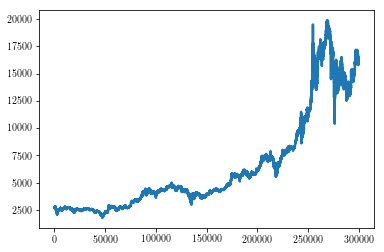

In [3]:
plt.plot(range(len(df.Close[-300000:])), df.Close[-300000:])

In [4]:
# choose the data from the previous 208 days
df = df.Close[-300000:].reshape(-1,1)
print(df.shape)

(300000, 1)


/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [5]:
# split into train and test sets
train_size = 298000
train_all, test_all = df[:train_size, :], df[train_size:, :]
print(len(train_all), len(test_all))

(298000, 2000)


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_all)
train_all = scaler.transform(train_all)
test_all = scaler.transform(test_all)

In [7]:
def generate_sample(T, start_indx, end_indx, df):
    sample = []
    idx = range(start_indx, end_indx, 1)
    for val in idx:
        piece = df[val:val+T, :]
        sample.append(piece)
    return np.array(sample), idx

In [8]:
# create dataset to pass into DKF
# Train: T=10, 296000 samples
train, train_idx = generate_sample(10, 0, 296000, train_all)

# Valid: T=10, 1989 samples
valid, valid_idx = generate_sample(10, 296000, len(train_all)-11, train_all)

# # Test: T=10, 1989 sample
test, test_idx = generate_sample(10, 0, len(test_all)-11, test_all)


train_dict = {}
train_dict['tensor'] = train
train_dict['mask'] = np.ones((296000, 10))

valid_dict = {}
valid_dict['tensor'] = valid
valid_dict['mask'] = np.ones((1989, 10))

test_dict = {}
test_dict['tensor'] = test
test_dict['mask'] = np.ones((1989, 10))

dataset = {}
dataset['dim_observations'] = 1
dataset['data_type'] = 'real'
dataset['train'] = train_dict
dataset['valid'] = valid_dict
dataset['test'] = test_dict

print 'Dimensionality of the observations: ', dataset['dim_observations']
print 'Data type of features:', dataset['data_type']
for dtype in ['train','valid','test']:
    print 'dtype: ',dtype, ' type(dataset[dtype]): ',type(dataset[dtype])
    print [(k,type(dataset[dtype][k]), dataset[dtype][k].shape) for k in dataset[dtype]]
    print '--------\n'

Dimensionality of the observations:  1
Data type of features: real
dtype:  train  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (296000, 10)), ('tensor', <type 'numpy.ndarray'>, (296000, 10, 1))]
--------

dtype:  valid  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1989, 10)), ('tensor', <type 'numpy.ndarray'>, (1989, 10, 1))]
--------

dtype:  test  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1989, 10)), ('tensor', <type 'numpy.ndarray'>, (1989, 10, 1))]
--------



## Parameter Tuning and Model Training

In [9]:
# load parameter
params = readPickle('default.pkl')[0]
for k in params:
    print k, '\t',params[k]

Read  1  objects
dataset 	mm
epochs 	2000
seed 	1
init_weight 	0.1
dim_stochastic 	100
expt_name 	uid
reg_value 	0.05
reloadFile 	./NOSUCHFILE
reg_spec 	_
dim_hidden 	200
lr 	0.0008
reg_type 	l2
init_scheme 	uniform
optimizer 	adam
use_generative_prior 	approx
maxout_stride 	4
batch_size 	20
savedir 	./chkpt
forget_bias 	-5.0
inference_model 	R
emission_layers 	2
savefreq 	10
rnn_cell 	lstm
rnn_size 	600
paramFile 	./NOSUCHFILE
nonlinearity 	relu
rnn_dropout 	0.1
transition_layers 	2
anneal_rate 	2.0
debug 	False
validate_only 	False
transition_type 	mlp
unique_id 	DMM_lr-0_0008-dh-200-ds-100-nl-relu-bs-20-ep-2000-rs-600-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid
leaky_param 	0.0


In [10]:
# modify parameters
params['data_type'] = dataset['data_type']
params['dim_observations'] = dataset['dim_observations']

# Change parameters and the unique ID
params['dim_stochastic'] = 4
params['dim_hidden']     = 4
params['rnn_size']       = 64
params['epochs']         = 500
params['batch_size']     = 1000
params['lr'] = 0.001

params['unique_id'] = params['unique_id'].replace('ds-100','ds-4').replace('dh-200','dh-4').replace('rs-600','rs-64')
params['unique_id'] = params['unique_id'].replace('ep-2000','ep-500').replace('bs-20','bs-1000')
params['unique_id'] = params['unique_id'].replace('lr-0_0008','lr-0_001')

#Create a temporary directory to save checkpoints
params['savedir']   = params['savedir']+'-ipython-sliding-new/'
os.system('mkdir -p '+params['savedir'])

#Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile

Checkpoint prefix:  ./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl


In [11]:
# build dmm
dmm  = DMM(params, paramFile = pfile)

	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 34122>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 regularization for U_lstm_r >>>>>>
<<<<<< Adding l2 re

In [12]:
# parameter estimation
# savef specifies the prefix for the checkpoints - we'll use the same save directory as before 
savef    = os.path.join(params['savedir'],params['unique_id'])
savedata = DMM_learn.learn(dmm, dataset['train'], epoch_start =0 ,
                                epoch_end = params['epochs'],
                                batch_size = params['batch_size'],
                                savefreq   = params['savefreq'],
                                savefile   = savef,
                                dataset_eval=dataset['valid'],
                                shuffle    = True )

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: 0.9935, |w|: 29.2962, |dw|: 1.0000, |w_opt|: 0.0000>>
	<<-veCLL:9925.9559, KL:912.5518, anneal:0.0100>>
	<<Bnum: 10, Batch Bound: 1.0065, |w|: 29.0510, |dw|: 1.0000, |w_opt|: 0.6335>>
	<<-veCLL:9830.9351, KL:234.3823, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: 0.9967, |w|: 28.8659, |dw|: 1.0000, |w_opt|: 0.8219>>
	<<-veCLL:9823.1207, KL:144.0536, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: 0.9861, |w|: 28.6304, |dw|: 1.0000, |w_opt|: 0.9192>>
	<<-veCLL:9745.6842, KL:115.5474, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: 0.9753, |w|: 28.4048, |dw|: 1.0000, |w_opt|: 0.9694>>
	<<-veCLL:9649.2523, KL:103.8382, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: 0.9658, |w|: 28.1970, |dw|: 1.0000, |w_opt|: 0.9890>>
	<<-veCLL:9563.5212, KL:94.1437, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: 0.9583, |w|: 27.9988, |dw|: 1.0000, |w_opt|: 0.9961>>
	<<-veCLL:9494.9891, KL:87.9940, anneal:1.0000>>
	<<Bnum

	<<Bnum: 270, Batch Bound: -0.3414, |w|: 29.6088, |dw|: 1.0000, |w_opt|: 0.3010>>
	<<-veCLL:-7206.5039, KL:3792.2945, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.3090, |w|: 29.6348, |dw|: 1.0000, |w_opt|: 0.3677>>
	<<-veCLL:-6853.9059, KL:3763.5894, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.3996, |w|: 29.6468, |dw|: 1.0000, |w_opt|: 0.2988>>
	<<-veCLL:-7521.3493, KL:3525.0308, anneal:1.0000>>
	<<(Ep 1) Bound: -0.2297 [Took 114.0359 seconds] >>
	<<Bnum: 0, Batch Bound: -0.3925, |w|: 29.6548, |dw|: 1.0000, |w_opt|: 0.3162>>
	<<-veCLL:-7714.8033, KL:3790.0743, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.3555, |w|: 29.6639, |dw|: 1.0000, |w_opt|: 0.2994>>
	<<-veCLL:-7286.3894, KL:3731.4158, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3780, |w|: 29.6725, |dw|: 1.0000, |w_opt|: 0.3125>>
	<<-veCLL:-7426.9127, KL:3646.4919, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.3062, |w|: 29.6823, |dw|: 1.0000, |w_opt|: 0.3207>>
	<<-veCLL:-6865.8688, KL:3803.9353, anneal:1.0000>>
	<<Bnum: 40, Ba

	<<Bnum: 280, Batch Bound: -0.4945, |w|: 30.7533, |dw|: 1.0000, |w_opt|: 0.5621>>
	<<-veCLL:-9355.1319, KL:4410.3585, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.4939, |w|: 30.7695, |dw|: 1.0000, |w_opt|: 0.5882>>
	<<-veCLL:-9499.5888, KL:4560.9882, anneal:1.0000>>
	<<(Ep 3) Bound: -0.4530 [Took 110.9000 seconds] >>
	<<Bnum: 0, Batch Bound: -0.4737, |w|: 30.7815, |dw|: 1.0000, |w_opt|: 0.5670>>
	<<-veCLL:-9359.8754, KL:4623.3125, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.5992, |w|: 30.8025, |dw|: 1.0000, |w_opt|: 0.5847>>
	<<-veCLL:-10776.4770, KL:4784.4468, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.5058, |w|: 30.8250, |dw|: 1.0000, |w_opt|: 0.5763>>
	<<-veCLL:-9478.4027, KL:4420.1548, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.4687, |w|: 30.8402, |dw|: 1.0000, |w_opt|: 0.5966>>
	<<-veCLL:-9240.7840, KL:4553.7584, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.5578, |w|: 30.8566, |dw|: 1.0000, |w_opt|: 0.6322>>
	<<-veCLL:-10355.3573, KL:4777.6862, anneal:1.0000>>
	<<Bnum: 50, B

	<<Bnum: 290, Batch Bound: -0.6337, |w|: 31.5709, |dw|: 1.0000, |w_opt|: 0.7469>>
	<<-veCLL:-11524.5114, KL:5187.9619, anneal:1.0000>>
	<<(Ep 5) Bound: -0.5827 [Took 110.7411 seconds] >>
	<<Bnum: 0, Batch Bound: -0.6341, |w|: 31.5904, |dw|: 1.0000, |w_opt|: 0.7484>>
	<<-veCLL:-11460.3188, KL:5119.5469, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.4179, |w|: 31.6050, |dw|: 1.0000, |w_opt|: 0.7620>>
	<<-veCLL:-9986.4567, KL:5807.7245, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.6400, |w|: 31.6116, |dw|: 1.0000, |w_opt|: 0.8200>>
	<<-veCLL:-12225.5564, KL:5825.7901, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.6265, |w|: 31.6171, |dw|: 1.0000, |w_opt|: 0.7502>>
	<<-veCLL:-11262.4831, KL:4997.6629, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.6165, |w|: 31.6228, |dw|: 1.0000, |w_opt|: 0.7769>>
	<<-veCLL:-11461.3594, KL:5295.9164, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.6333, |w|: 31.6250, |dw|: 1.0000, |w_opt|: 0.7554>>
	<<-veCLL:-11590.8130, KL:5257.5410, anneal:1.0000>>
	<<Bnum: 60

	<<(Ep 7) Bound: -0.6667 [Took 1310.5642 seconds] >>
	<<Bnum: 0, Batch Bound: -0.7237, |w|: 32.0759, |dw|: 1.0000, |w_opt|: 0.8422>>
	<<-veCLL:-12923.0044, KL:5685.8230, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.7054, |w|: 32.0881, |dw|: 1.0000, |w_opt|: 0.8447>>
	<<-veCLL:-12708.4054, KL:5654.6511, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3880, |w|: 32.0950, |dw|: 1.0000, |w_opt|: 0.8512>>
	<<-veCLL:-10318.3907, KL:6438.3777, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7165, |w|: 32.0957, |dw|: 1.0000, |w_opt|: 0.9766>>
	<<-veCLL:-12803.3881, KL:5637.9490, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.7240, |w|: 32.0987, |dw|: 1.0000, |w_opt|: 0.9110>>
	<<-veCLL:-12860.6629, KL:5620.9498, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.6216, |w|: 32.0956, |dw|: 1.0000, |w_opt|: 0.8494>>
	<<-veCLL:-11937.6085, KL:5721.7755, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -0.7381, |w|: 32.1035, |dw|: 1.0000, |w_opt|: 0.8459>>
	<<-veCLL:-13150.5464, KL:5769.4144, anneal:1.0000>>
	<<Bnum: 7

	<<Bnum: 0, Batch Bound: -0.7080, |w|: 32.4283, |dw|: 1.0000, |w_opt|: 0.9084>>
	<<-veCLL:-13075.5613, KL:5995.4012, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.7912, |w|: 32.4253, |dw|: 1.0000, |w_opt|: 0.9055>>
	<<-veCLL:-13686.9196, KL:5775.1988, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.8020, |w|: 32.4232, |dw|: 1.0000, |w_opt|: 0.8891>>
	<<-veCLL:-14203.7315, KL:6184.0314, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7897, |w|: 32.4252, |dw|: 1.0000, |w_opt|: 0.8903>>
	<<-veCLL:-13821.9172, KL:5924.5478, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.7987, |w|: 32.4424, |dw|: 1.0000, |w_opt|: 0.8900>>
	<<-veCLL:-14317.4474, KL:6330.5268, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.8248, |w|: 32.4500, |dw|: 1.0000, |w_opt|: 0.8916>>
	<<-veCLL:-14380.6299, KL:6132.7909, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -0.7179, |w|: 32.4579, |dw|: 1.0000, |w_opt|: 0.9067>>
	<<-veCLL:-13355.1497, KL:6175.9902, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -0.7085, |w|: 32.4683, |dw|: 1.0000, 

	<<Bnum: 260, Batch Bound: -0.7688, |w|: 32.7700, |dw|: 1.0000, |w_opt|: 0.9206>>
	<<-veCLL:-14093.6708, KL:6406.0560, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.7761, |w|: 32.7726, |dw|: 1.0000, |w_opt|: 0.9202>>
	<<-veCLL:-14684.3342, KL:6923.0306, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.7578, |w|: 32.7857, |dw|: 1.0000, |w_opt|: 0.9191>>
	<<-veCLL:-14016.0562, KL:6437.7906, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.8278, |w|: 32.7890, |dw|: 1.0000, |w_opt|: 0.9332>>
	<<-veCLL:-14656.0397, KL:6378.0845, anneal:1.0000>>
	<<(Ep 11) Bound: -0.7890 [Took 113.4497 seconds] >>
	<<Bnum: 0, Batch Bound: -0.8405, |w|: 32.7905, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-15208.5993, KL:6804.0658, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.8417, |w|: 32.7941, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-15098.0114, KL:6680.6919, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.8317, |w|: 32.8061, |dw|: 1.0000, |w_opt|: 0.9203>>
	<<-veCLL:-15156.6857, KL:6839.4720, anneal:1.0000>>
	<<Bnu

	<<Bnum: 270, Batch Bound: -0.9557, |w|: 33.1355, |dw|: 1.0000, |w_opt|: 0.9347>>
	<<-veCLL:-16737.9154, KL:7180.8473, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.6285, |w|: 33.1558, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-14269.4511, KL:7984.0897, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.7778, |w|: 33.1495, |dw|: 1.0000, |w_opt|: 0.9280>>
	<<-veCLL:-14730.6916, KL:6952.2830, anneal:1.0000>>
	<<(Ep 13) Bound: -0.8171 [Took 113.3572 seconds] >>
	<<Bnum: 0, Batch Bound: -0.7473, |w|: 33.1390, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-13993.9223, KL:6520.8858, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: 0.3520, |w|: 33.1156, |dw|: 1.0000, |w_opt|: 0.9977>>
	<<-veCLL:-6281.1398, KL:9800.9011, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3172, |w|: 33.0668, |dw|: 1.0000, |w_opt|: 0.9935>>
	<<-veCLL:-9621.2298, KL:6449.3412, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7998, |w|: 33.0504, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-14053.4025, KL:6054.9995, anneal:1.0000>>
	<<Bnum: 4

	<<Bnum: 280, Batch Bound: -0.9677, |w|: 33.3754, |dw|: 1.0000, |w_opt|: 0.9326>>
	<<-veCLL:-17543.7881, KL:7867.1568, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.7950, |w|: 33.3838, |dw|: 1.0000, |w_opt|: 0.9521>>
	<<-veCLL:-16341.3093, KL:8391.1454, anneal:1.0000>>
	<<(Ep 15) Bound: -0.9101 [Took 113.6329 seconds] >>
	<<Bnum: 0, Batch Bound: -0.9218, |w|: 33.3857, |dw|: 1.0000, |w_opt|: 0.9418>>
	<<-veCLL:-17152.3823, KL:7933.9399, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.5986, |w|: 33.3805, |dw|: 1.0000, |w_opt|: 0.9885>>
	<<-veCLL:-16004.8192, KL:10018.7997, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.9403, |w|: 33.3698, |dw|: 1.0000, |w_opt|: 1.0203>>
	<<-veCLL:-16830.7674, KL:7427.6973, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.9204, |w|: 33.3616, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-16397.2603, KL:7193.6580, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.9917, |w|: 33.3680, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-17350.1186, KL:7433.3134, anneal:1.0000>>
	<<Bnum

	<<Bnum: 290, Batch Bound: -1.0553, |w|: 33.6812, |dw|: 1.0000, |w_opt|: 0.9514>>
	<<-veCLL:-19816.8876, KL:9263.7582, anneal:1.0000>>
	<<(Ep 17) Bound: -0.9611 [Took 113.4918 seconds] >>
	<<Bnum: 0, Batch Bound: -1.0528, |w|: 33.6852, |dw|: 1.0000, |w_opt|: 0.9507>>
	<<-veCLL:-19557.1703, KL:9029.5772, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.9795, |w|: 33.6922, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-19711.2763, KL:9916.5655, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0525, |w|: 33.6898, |dw|: 1.0000, |w_opt|: 0.9459>>
	<<-veCLL:-19494.7106, KL:8969.6277, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.0056, |w|: 33.6864, |dw|: 1.0000, |w_opt|: 0.9438>>
	<<-veCLL:-18903.3315, KL:8847.4207, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.0670, |w|: 33.6910, |dw|: 1.0000, |w_opt|: 0.9472>>
	<<-veCLL:-19357.9168, KL:8687.5189, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.0431, |w|: 33.7058, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-19359.4070, KL:8928.8024, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 19) Bound: -1.0767 [Took 177.8248 seconds] >>
	<<Bnum: 0, Batch Bound: -1.0780, |w|: 33.9312, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-20410.8257, KL:9630.7330, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.9700, |w|: 33.9338, |dw|: 1.0000, |w_opt|: 0.9513>>
	<<-veCLL:-19358.1961, KL:9658.1716, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0551, |w|: 33.9348, |dw|: 1.0000, |w_opt|: 0.9525>>
	<<-veCLL:-19981.7872, KL:9430.8064, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.1492, |w|: 33.9374, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-21143.4447, KL:9651.3164, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.1939, |w|: 33.9403, |dw|: 1.0000, |w_opt|: 0.9618>>
	<<-veCLL:-21637.9831, KL:9699.1845, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.2149, |w|: 33.9434, |dw|: 1.0000, |w_opt|: 0.9513>>
	<<-veCLL:-21755.7740, KL:9606.8030, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.3081, |w|: 33.9504, |dw|: 1.0000, |w_opt|: 0.9685>>
	<<-veCLL:-22765.4832, KL:9684.4164, anneal:1.0000>>
	<<Bnum: 7

	<<Bnum: 260, Batch Bound: -1.2878, |w|: 34.2363, |dw|: 1.0000, |w_opt|: 0.9509>>
	<<-veCLL:-23134.3789, KL:10256.8017, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.2744, |w|: 34.2456, |dw|: 1.0000, |w_opt|: 0.9609>>
	<<-veCLL:-23191.6267, KL:10447.8516, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.2414, |w|: 34.2522, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-22754.5237, KL:10340.6201, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.2544, |w|: 34.2556, |dw|: 1.0000, |w_opt|: 0.9523>>
	<<-veCLL:-23059.9781, KL:10515.6413, anneal:1.0000>>
	<<(Ep 21) Bound: -1.1536 [Took 113.9132 seconds] >>
	<<Bnum: 0, Batch Bound: -0.3138, |w|: 34.2619, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-17139.8487, KL:14002.1309, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.0115, |w|: 34.2418, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-20735.5555, KL:10620.6927, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3967, |w|: 34.2331, |dw|: 1.0000, |w_opt|: 0.9518>>
	<<-veCLL:-15825.8987, KL:11858.4703, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.3967, |w|: 34.5275, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-24606.2256, KL:10638.7618, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3943, |w|: 34.5333, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-24428.3702, KL:10485.0709, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4504, |w|: 34.5384, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-25348.4543, KL:10844.4941, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.0027, |w|: 34.5431, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-20457.3004, KL:10430.4607, anneal:1.0000>>
	<<(Ep 23) Bound: -1.2352 [Took 112.8318 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4435, |w|: 34.5455, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-24933.1221, KL:10498.1670, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3986, |w|: 34.5496, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-24587.1030, KL:10600.9324, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0774, |w|: 34.5524, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-21371.3799, KL:10597.3753, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.4700, |w|: 34.7644, |dw|: 1.0000, |w_opt|: 0.9671>>
	<<-veCLL:-25246.9298, KL:10547.0317, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3706, |w|: 34.7705, |dw|: 1.0000, |w_opt|: 0.9854>>
	<<-veCLL:-24335.1164, KL:10629.1893, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4025, |w|: 34.7733, |dw|: 1.0000, |w_opt|: 0.9678>>
	<<-veCLL:-24717.9433, KL:10692.7828, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.3850, |w|: 34.7761, |dw|: 1.0000, |w_opt|: 0.9901>>
	<<-veCLL:-24681.1597, KL:10830.7602, anneal:1.0000>>
	<<(Ep 25) Bound: -1.2883 [Took 113.4743 seconds] >>
	<<Bnum: 0, Batch Bound: -0.9652, |w|: 34.7772, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-20208.7244, KL:10556.2929, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5281, |w|: 34.7808, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-25958.6797, KL:10677.9647, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0148, |w|: 34.7867, |dw|: 1.0000, |w_opt|: 0.9681>>
	<<-veCLL:-21008.2274, KL:10860.5530, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.2279, |w|: 34.9782, |dw|: 1.0000, |w_opt|: 0.9759>>
	<<-veCLL:-22862.7201, KL:10583.5558, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.1686, |w|: 34.9853, |dw|: 1.0000, |w_opt|: 0.9754>>
	<<-veCLL:-22462.4013, KL:10776.2361, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.5277, |w|: 34.9880, |dw|: 1.0000, |w_opt|: 0.9722>>
	<<-veCLL:-25958.3132, KL:10681.4981, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.2917, |w|: 34.9966, |dw|: 1.0000, |w_opt|: 0.9727>>
	<<-veCLL:-23532.3570, KL:10615.3173, anneal:1.0000>>
	<<(Ep 27) Bound: -1.2810 [Took 113.9266 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3367, |w|: 35.0008, |dw|: 1.0000, |w_opt|: 0.9728>>
	<<-veCLL:-24036.7180, KL:10669.8968, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5434, |w|: 35.0071, |dw|: 1.0000, |w_opt|: 0.9740>>
	<<-veCLL:-26096.3491, KL:10662.4921, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.5148, |w|: 35.0119, |dw|: 1.0000, |w_opt|: 0.9847>>
	<<-veCLL:-25787.9523, KL:10639.5936, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.3882, |w|: 35.2326, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-24488.0018, KL:10605.7435, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3410, |w|: 35.2362, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-25422.0247, KL:12011.9149, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4609, |w|: 35.2489, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-25099.5898, KL:10490.5603, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.4671, |w|: 35.2521, |dw|: 1.0000, |w_opt|: 0.9760>>
	<<-veCLL:-25538.2242, KL:10866.8634, anneal:1.0000>>
	<<(Ep 29) Bound: -1.3181 [Took 113.4170 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4952, |w|: 35.2523, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-25054.5309, KL:10102.7763, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3526, |w|: 35.2532, |dw|: 1.0000, |w_opt|: 0.9654>>
	<<-veCLL:-23442.7366, KL:9917.1888, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.6676, |w|: 35.2606, |dw|: 1.0000, |w_opt|: 0.9665>>
	<<-veCLL:-17502.5270, KL:10826.0274, anneal:1.0000>>


	<<Bnum: 220, Batch Bound: -1.6866, |w|: 35.5047, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-27201.5046, KL:10335.0125, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.6083, |w|: 35.5192, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-26471.0817, KL:10387.8159, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.6178, |w|: 35.5302, |dw|: 1.0000, |w_opt|: 0.9579>>
	<<-veCLL:-26518.7457, KL:10341.0622, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6305, |w|: 35.5412, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-26732.1760, KL:10426.8045, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.7319, |w|: 35.5452, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-27698.0219, KL:10379.5029, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.6020, |w|: 35.5493, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-26371.0435, KL:10350.7625, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.3953, |w|: 35.5532, |dw|: 1.0000, |w_opt|: 0.9631>>
	<<-veCLL:-24327.7869, KL:10375.1825, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.6612, |w|: 35.5565

	<<Bnum: 220, Batch Bound: -1.1233, |w|: 35.7203, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-21195.7907, KL:9962.4268, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.2799, |w|: 35.7218, |dw|: 1.0000, |w_opt|: 0.9727>>
	<<-veCLL:-22937.7877, KL:10138.3685, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.8672, |w|: 35.7232, |dw|: 1.0000, |w_opt|: 0.9733>>
	<<-veCLL:-18406.1775, KL:9733.7337, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6931, |w|: 35.7247, |dw|: 1.0000, |w_opt|: 0.9661>>
	<<-veCLL:-26699.7979, KL:9769.1215, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6864, |w|: 35.7299, |dw|: 1.0000, |w_opt|: 0.9785>>
	<<-veCLL:-26868.6423, KL:10004.5319, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.7356, |w|: 35.7346, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-27467.6173, KL:10111.2215, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.6955, |w|: 35.7418, |dw|: 1.0000, |w_opt|: 0.9958>>
	<<-veCLL:-17696.8799, KL:10741.3926, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: 2.4564, |w|: 35.7491, |d

	<<Bnum: 220, Batch Bound: -1.4861, |w|: 35.9371, |dw|: 1.0000, |w_opt|: 0.9656>>
	<<-veCLL:-24968.2366, KL:10107.5980, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.7257, |w|: 35.9389, |dw|: 1.0000, |w_opt|: 0.9671>>
	<<-veCLL:-27125.7669, KL:9868.7674, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.8221, |w|: 35.9442, |dw|: 1.0000, |w_opt|: 0.9782>>
	<<-veCLL:-28145.1786, KL:9923.9654, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.7578, |w|: 35.9522, |dw|: 1.0000, |w_opt|: 0.9729>>
	<<-veCLL:-27530.7341, KL:9952.4947, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.2166, |w|: 35.9581, |dw|: 1.0000, |w_opt|: 1.0074>>
	<<-veCLL:-22104.4747, KL:9938.6638, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.4914, |w|: 35.9698, |dw|: 1.0000, |w_opt|: 0.9761>>
	<<-veCLL:-15615.3291, KL:10701.3619, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.3004, |w|: 35.9813, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-13983.4245, KL:10979.4327, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.7816, |w|: 35.9897, |d

	<<Bnum: 220, Batch Bound: -1.8150, |w|: 36.1680, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-27896.8098, KL:9746.4286, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.6509, |w|: 36.1720, |dw|: 1.0000, |w_opt|: 0.9803>>
	<<-veCLL:-26225.3138, KL:9715.9397, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.5788, |w|: 36.1780, |dw|: 1.0000, |w_opt|: 0.9777>>
	<<-veCLL:-15710.2359, KL:9922.1401, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6110, |w|: 36.1807, |dw|: 1.0000, |w_opt|: 0.9685>>
	<<-veCLL:-25984.0622, KL:9874.3363, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6421, |w|: 36.1823, |dw|: 1.0000, |w_opt|: 0.9913>>
	<<-veCLL:-26096.8470, KL:9676.2576, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.5586, |w|: 36.1834, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-25320.6634, KL:9735.0277, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.5995, |w|: 36.1838, |dw|: 1.0000, |w_opt|: 0.9897>>
	<<-veCLL:-25492.4218, KL:9497.2089, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.6602, |w|: 36.1877, |dw|:

	<<Bnum: 220, Batch Bound: -1.8612, |w|: 36.3664, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-28140.6508, KL:9528.5051, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.8170, |w|: 36.3682, |dw|: 1.0000, |w_opt|: 0.9766>>
	<<-veCLL:-27702.6600, KL:9532.6177, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.9045, |w|: 36.3702, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-28786.5372, KL:9741.5315, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.8894, |w|: 36.3722, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-28598.1887, KL:9703.9786, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.7943, |w|: 36.3740, |dw|: 1.0000, |w_opt|: 0.9771>>
	<<-veCLL:-27478.2641, KL:9534.8669, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.9200, |w|: 36.3758, |dw|: 1.0000, |w_opt|: 0.9655>>
	<<-veCLL:-28905.3608, KL:9705.5693, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.8162, |w|: 36.3772, |dw|: 1.0000, |w_opt|: 0.9668>>
	<<-veCLL:-27668.4645, KL:9506.3037, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.7455, |w|: 36.3785, |dw|:

	<<Bnum: 180, Batch Bound: -1.6775, |w|: 36.5761, |dw|: 1.0000, |w_opt|: 0.9841>>
	<<-veCLL:-26409.2919, KL:9634.2919, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.8131, |w|: 36.5779, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-27700.3924, KL:9569.7974, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.2678, |w|: 36.5725, |dw|: 1.0000, |w_opt|: 0.9918>>
	<<-veCLL:-23024.7117, KL:10346.3610, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.4479, |w|: 36.5745, |dw|: 1.0000, |w_opt|: 0.9586>>
	<<-veCLL:-24895.7880, KL:10416.6565, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.7867, |w|: 36.5778, |dw|: 1.0000, |w_opt|: 0.9775>>
	<<-veCLL:-26760.5119, KL:8893.5903, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.7137, |w|: 36.5753, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-26270.7369, KL:9133.9669, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.5491, |w|: 36.5780, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-14303.6337, KL:8812.7624, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6024, |w|: 36.5789, |dw

	<<Bnum: 190, Batch Bound: -2.0598, |w|: 36.8719, |dw|: 1.0000, |w_opt|: 0.9739>>
	<<-veCLL:-30347.9431, KL:9750.2228, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0150, |w|: 36.8768, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-29920.5788, KL:9771.0495, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9290, |w|: 36.8846, |dw|: 1.0000, |w_opt|: 0.9741>>
	<<-veCLL:-28944.7892, KL:9655.0003, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.4516, |w|: 36.8833, |dw|: 1.0000, |w_opt|: 0.9791>>
	<<-veCLL:-26274.7065, KL:11758.5802, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.9655, |w|: 36.8893, |dw|: 1.0000, |w_opt|: 0.9610>>
	<<-veCLL:-29434.4985, KL:9779.3371, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.6566, |w|: 36.8942, |dw|: 1.0000, |w_opt|: 0.9617>>
	<<-veCLL:-27755.7298, KL:11190.1541, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.2260, |w|: 36.8948, |dw|: 1.0000, |w_opt|: 0.9596>>
	<<-veCLL:-28351.9889, KL:16091.7933, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -0.3169, |w|: 36.8970, |d

	<<Bnum: 200, Batch Bound: -1.6545, |w|: 37.0364, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-29468.3677, KL:12923.1503, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0092, |w|: 37.0414, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-29820.5127, KL:9728.5928, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.9179, |w|: 37.0422, |dw|: 1.0000, |w_opt|: 0.9872>>
	<<-veCLL:-28942.4210, KL:9763.2118, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0729, |w|: 37.0446, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-30281.8094, KL:9552.6334, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.0859, |w|: 37.0451, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-20494.3325, KL:9635.8109, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.4899, |w|: 37.0429, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-24384.7032, KL:9485.9409, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.3036, |w|: 37.0443, |dw|: 1.0000, |w_opt|: 0.9638>>
	<<-veCLL:-22924.2479, KL:9888.4733, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.3650, |w|: 37.0423, |dw|

	<<Bnum: 200, Batch Bound: -2.0079, |w|: 37.2077, |dw|: 1.0000, |w_opt|: 0.9674>>
	<<-veCLL:-29176.6097, KL:9098.0239, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9160, |w|: 37.2167, |dw|: 1.0000, |w_opt|: 0.9640>>
	<<-veCLL:-28374.1543, KL:9213.9798, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0772, |w|: 37.2259, |dw|: 1.0000, |w_opt|: 0.9637>>
	<<-veCLL:-30040.9158, KL:9268.8581, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0844, |w|: 37.2362, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-30064.4501, KL:9220.2975, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0182, |w|: 37.2351, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-29617.5881, KL:9435.5562, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.9897, |w|: 37.2451, |dw|: 1.0000, |w_opt|: 0.9628>>
	<<-veCLL:-29356.5444, KL:9459.2159, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.0167, |w|: 37.2471, |dw|: 1.0000, |w_opt|: 0.9629>>
	<<-veCLL:-29563.5595, KL:9396.6852, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.0124, |w|: 37.2492, |dw|:

	<<Bnum: 210, Batch Bound: -1.9800, |w|: 37.4158, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-29167.7481, KL:9367.5248, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: 2.6118, |w|: 37.4665, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:3674.6440, KL:22443.6319, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: 1.0363, |w|: 37.5078, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-11560.5959, KL:21923.6657, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.3913, |w|: 37.5444, |dw|: 1.0000, |w_opt|: 1.0033>>
	<<-veCLL:-27141.1210, KL:13228.2970, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6208, |w|: 37.5622, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-27379.6467, KL:11172.0358, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6856, |w|: 37.5389, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-27057.7276, KL:10201.3036, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.7954, |w|: 37.5273, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-27483.2311, KL:9529.6224, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.8296, |w|: 37.5385, |dw|

	<<Bnum: 170, Batch Bound: -1.6224, |w|: 37.6757, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-25676.0716, KL:9451.9668, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0405, |w|: 37.6806, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-29719.2445, KL:9313.8948, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.5727, |w|: 37.6813, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-25156.9316, KL:9430.3054, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.8439, |w|: 37.6841, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-27766.1124, KL:9327.0812, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9559, |w|: 37.6869, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-28923.7664, KL:9364.5254, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1030, |w|: 37.6867, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-30324.2061, KL:9294.1879, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0994, |w|: 37.6891, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-30447.9680, KL:9453.5461, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1465, |w|: 37.6923, |dw|:

	<<Bnum: 170, Batch Bound: -1.4952, |w|: 37.8610, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-24713.3030, KL:9761.5732, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.7718, |w|: 37.8584, |dw|: 1.0000, |w_opt|: 0.9666>>
	<<-veCLL:-27776.6111, KL:10058.8855, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1023, |w|: 37.8545, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-30830.1755, KL:9807.0054, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0342, |w|: 37.8542, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-29994.6661, KL:9652.3401, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0567, |w|: 37.8558, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-30177.5967, KL:9610.0984, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1853, |w|: 37.8584, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-31608.3221, KL:9755.3261, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.1205, |w|: 37.8594, |dw|: 1.0000, |w_opt|: 0.9659>>
	<<-veCLL:-30758.4524, KL:9553.8053, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1573, |w|: 37.8619, |dw|

	<<Bnum: 170, Batch Bound: -2.0028, |w|: 37.9854, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-29812.0645, KL:9783.7180, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0235, |w|: 37.9865, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-29883.1115, KL:9648.4483, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1915, |w|: 37.9886, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-31701.3721, KL:9786.3228, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1889, |w|: 37.9886, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-31479.8658, KL:9590.5680, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9134, |w|: 38.0101, |dw|: 1.0000, |w_opt|: 0.9779>>
	<<-veCLL:-29272.3159, KL:10138.1313, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0756, |w|: 38.0113, |dw|: 1.0000, |w_opt|: 0.9702>>
	<<-veCLL:-30959.0825, KL:10203.1307, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.9161, |w|: 38.0093, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-29410.0107, KL:10249.2026, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0638, |w|: 38.0089, |d

	<<Bnum: 170, Batch Bound: -2.0872, |w|: 38.1052, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-30285.0885, KL:9413.0757, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0716, |w|: 38.1067, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-30012.2401, KL:9296.1079, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0635, |w|: 38.1091, |dw|: 1.0000, |w_opt|: 0.9697>>
	<<-veCLL:-30058.2985, KL:9422.8540, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1101, |w|: 38.1112, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-30718.1735, KL:9617.1255, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0174, |w|: 38.1107, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-29561.0675, KL:9387.1609, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0454, |w|: 38.1129, |dw|: 1.0000, |w_opt|: 0.9704>>
	<<-veCLL:-29953.2926, KL:9499.5318, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0774, |w|: 38.1156, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-30138.3100, KL:9364.2961, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0870, |w|: 38.1154, |dw|:

	<<Bnum: 170, Batch Bound: -2.0198, |w|: 38.2528, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-31039.3069, KL:10841.3132, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9603, |w|: 38.2527, |dw|: 1.0000, |w_opt|: 0.9719>>
	<<-veCLL:-29191.2140, KL:9588.5576, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0214, |w|: 38.2499, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-29836.2718, KL:9622.3594, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.7007, |w|: 38.2655, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-28346.8463, KL:11339.4802, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.7725, |w|: 38.2529, |dw|: 1.0000, |w_opt|: 0.9716>>
	<<-veCLL:-27848.7944, KL:10124.0231, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1030, |w|: 38.2550, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-30297.9414, KL:9267.9344, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0616, |w|: 38.2612, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-30083.9377, KL:9468.0621, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.9985, |w|: 38.2546, |d

	<<Bnum: 130, Batch Bound: -2.1226, |w|: 38.3910, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-30691.8236, KL:9465.6887, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1781, |w|: 38.3909, |dw|: 1.0000, |w_opt|: 0.9769>>
	<<-veCLL:-31244.6504, KL:9463.5379, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9007, |w|: 38.3909, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-28546.2079, KL:9539.2321, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2535, |w|: 38.3933, |dw|: 1.0000, |w_opt|: 0.9666>>
	<<-veCLL:-31961.0340, KL:9425.6302, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0571, |w|: 38.3945, |dw|: 1.0000, |w_opt|: 0.9773>>
	<<-veCLL:-29987.5916, KL:9416.2068, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9204, |w|: 38.3958, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-28603.8603, KL:9399.6696, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.2743, |w|: 38.3999, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-32208.7813, KL:9465.4875, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1414, |w|: 38.4018, |dw|:

	<<Bnum: 140, Batch Bound: -1.7204, |w|: 38.4892, |dw|: 1.0000, |w_opt|: 0.9729>>
	<<-veCLL:-26178.5518, KL:8974.7057, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1335, |w|: 38.4904, |dw|: 1.0000, |w_opt|: 0.9765>>
	<<-veCLL:-30487.7076, KL:9152.9771, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.9892, |w|: 38.4939, |dw|: 1.0000, |w_opt|: 0.9731>>
	<<-veCLL:-29014.7665, KL:9122.3615, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.1790, |w|: 38.4953, |dw|: 1.0000, |w_opt|: 0.9767>>
	<<-veCLL:-30896.2458, KL:9105.7582, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.7728, |w|: 38.4946, |dw|: 1.0000, |w_opt|: 0.9733>>
	<<-veCLL:-26720.5271, KL:8992.4588, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0256, |w|: 38.4959, |dw|: 1.0000, |w_opt|: 0.9768>>
	<<-veCLL:-29183.4749, KL:8927.0060, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.8671, |w|: 38.4983, |dw|: 1.0000, |w_opt|: 0.9734>>
	<<-veCLL:-27696.1786, KL:9025.3175, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2120, |w|: 38.5017, |dw|:

	<<Bnum: 140, Batch Bound: -2.1059, |w|: 38.6017, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-30459.3899, KL:9400.6984, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9824, |w|: 38.6063, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-29426.1076, KL:9601.6579, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.1885, |w|: 38.6069, |dw|: 1.0000, |w_opt|: 0.9615>>
	<<-veCLL:-31274.6349, KL:9389.9615, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0196, |w|: 38.6070, |dw|: 1.0000, |w_opt|: 0.9723>>
	<<-veCLL:-29450.5933, KL:9254.4646, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1300, |w|: 38.6130, |dw|: 1.0000, |w_opt|: 0.9606>>
	<<-veCLL:-30512.3915, KL:9212.2847, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.2231, |w|: 38.6170, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-31469.3508, KL:9237.9442, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1780, |w|: 38.6196, |dw|: 1.0000, |w_opt|: 0.9728>>
	<<-veCLL:-31020.4803, KL:9240.2415, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2228, |w|: 38.6240, |dw|:

	<<Bnum: 140, Batch Bound: -1.8429, |w|: 38.7800, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-27826.7911, KL:9398.2010, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -0.3931, |w|: 38.7778, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-13822.1725, KL:9891.0092, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0781, |w|: 38.7765, |dw|: 1.0000, |w_opt|: 0.9652>>
	<<-veCLL:-30200.7040, KL:9419.4989, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0290, |w|: 38.7804, |dw|: 1.0000, |w_opt|: 0.9559>>
	<<-veCLL:-29814.0494, KL:9523.8881, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1710, |w|: 38.7823, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-31199.0404, KL:9488.8440, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.9311, |w|: 38.7905, |dw|: 1.0000, |w_opt|: 0.9738>>
	<<-veCLL:-29460.2315, KL:10148.9221, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0964, |w|: 38.7958, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-30789.0557, KL:9825.3841, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.1079, |w|: 38.7959, |dw|

	<<Bnum: 150, Batch Bound: -2.2486, |w|: 38.8883, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-32173.9833, KL:9688.3310, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.4649, |w|: 38.8928, |dw|: 1.0000, |w_opt|: 0.9643>>
	<<-veCLL:-24195.8397, KL:9546.8933, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.7164, |w|: 38.8920, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-26774.5752, KL:9610.3471, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -0.3506, |w|: 38.8939, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-13180.6872, KL:9675.0295, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -0.6553, |w|: 38.8950, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-16307.7096, KL:9755.0021, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.5056, |w|: 38.8932, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-24578.5785, KL:9522.1743, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.1435, |w|: 38.8948, |dw|: 1.0000, |w_opt|: 0.9599>>
	<<-veCLL:-31691.6631, KL:10256.8938, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0940, |w|: 38.9025, |dw|

	<<Bnum: 110, Batch Bound: -1.9864, |w|: 39.0542, |dw|: 1.0000, |w_opt|: 0.9585>>
	<<-veCLL:-28940.1020, KL:9075.7130, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -1.9310, |w|: 39.0577, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:-31343.0183, KL:12033.0147, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.8975, |w|: 39.0553, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-28686.2910, KL:9711.2583, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1325, |w|: 39.0590, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-31058.2952, KL:9733.1318, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0744, |w|: 39.0611, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-30081.4767, KL:9337.2286, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0023, |w|: 39.0612, |dw|: 1.0000, |w_opt|: 0.9565>>
	<<-veCLL:-30404.0452, KL:10381.4227, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.1395, |w|: 39.0652, |dw|: 1.0000, |w_opt|: 0.9740>>
	<<-veCLL:-31585.3067, KL:10189.9570, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0161, |w|: 39.0617, |d

	<<Bnum: 110, Batch Bound: -2.1604, |w|: 39.1627, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-31000.2099, KL:9396.2913, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.0473, |w|: 39.1640, |dw|: 1.0000, |w_opt|: 0.9533>>
	<<-veCLL:-29939.3152, KL:9466.6317, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1920, |w|: 39.1658, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-31256.6452, KL:9336.6373, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1924, |w|: 39.1675, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-31388.6297, KL:9464.7159, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9781, |w|: 39.1683, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-29119.2221, KL:9338.0636, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2145, |w|: 39.1706, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-31633.3157, KL:9488.7939, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.2297, |w|: 39.1713, |dw|: 1.0000, |w_opt|: 0.9664>>
	<<-veCLL:-31739.7454, KL:9442.3895, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0062, |w|: 39.1723, |dw|:

	<<Bnum: 120, Batch Bound: -1.9299, |w|: 39.3616, |dw|: 1.0000, |w_opt|: 0.9735>>
	<<-veCLL:-29878.1158, KL:10579.2432, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1775, |w|: 39.3639, |dw|: 1.0000, |w_opt|: 0.9747>>
	<<-veCLL:-32143.7705, KL:10368.3036, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -1.5870, |w|: 39.3543, |dw|: 1.0000, |w_opt|: 0.9749>>
	<<-veCLL:-27551.7226, KL:11681.5965, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.7282, |w|: 39.3540, |dw|: 1.0000, |w_opt|: 0.9604>>
	<<-veCLL:-27284.7988, KL:10002.6957, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.7255, |w|: 39.3535, |dw|: 1.0000, |w_opt|: 0.9841>>
	<<-veCLL:-29058.9807, KL:11803.9837, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.2102, |w|: 39.3529, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-31770.0859, KL:9668.2730, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0942, |w|: 39.3524, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-30583.6661, KL:9641.8979, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1279, |w|: 39.3493, 

	<<Bnum: 120, Batch Bound: -1.6719, |w|: 39.5107, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-28127.4864, KL:11408.7762, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.8949, |w|: 39.5159, |dw|: 1.0000, |w_opt|: 0.9706>>
	<<-veCLL:-30305.6456, KL:11356.8485, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1275, |w|: 39.5149, |dw|: 1.0000, |w_opt|: 0.9559>>
	<<-veCLL:-31089.1328, KL:9814.4602, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1055, |w|: 39.5200, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-30262.2331, KL:9206.7355, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.6559, |w|: 39.5169, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-28360.0295, KL:11801.0581, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.9387, |w|: 39.5204, |dw|: 1.0000, |w_opt|: 0.9561>>
	<<-veCLL:-29915.3508, KL:10527.9962, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9552, |w|: 39.5286, |dw|: 1.0000, |w_opt|: 0.9637>>
	<<-veCLL:-29597.5703, KL:10045.8076, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1099, |w|: 39.5352, 

	<<Bnum: 120, Batch Bound: -1.4066, |w|: 39.6062, |dw|: 1.0000, |w_opt|: 0.9462>>
	<<-veCLL:-30603.6666, KL:16537.2204, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2349, |w|: 39.6059, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-31650.8927, KL:9301.6065, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0851, |w|: 39.6064, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-30152.4646, KL:9301.0459, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.8159, |w|: 39.6118, |dw|: 1.0000, |w_opt|: 0.9444>>
	<<-veCLL:-28104.0449, KL:9944.7386, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0908, |w|: 39.6155, |dw|: 1.0000, |w_opt|: 0.9511>>
	<<-veCLL:-31001.7974, KL:10093.6132, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0806, |w|: 39.6167, |dw|: 1.0000, |w_opt|: 0.9474>>
	<<-veCLL:-29900.6237, KL:9094.5100, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1630, |w|: 39.6190, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-30838.9538, KL:9208.9195, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.9617, |w|: 39.6213, |dw

	<<Bnum: 80, Batch Bound: -2.2457, |w|: 39.6961, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-32193.6852, KL:9736.6701, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.0537, |w|: 39.7061, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-31080.3793, KL:10543.2996, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9055, |w|: 39.7124, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-29086.6184, KL:10031.9557, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2576, |w|: 39.7127, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-32502.7318, KL:9926.4324, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2108, |w|: 39.7089, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-31783.9174, KL:9675.7562, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2373, |w|: 39.7129, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-32123.1203, KL:9749.8217, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2542, |w|: 39.7298, |dw|: 1.0000, |w_opt|: 0.9515>>
	<<-veCLL:-32211.4742, KL:9669.2779, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2587, |w|: 39.7342, |dw|:

	<<Bnum: 80, Batch Bound: -2.3317, |w|: 39.8316, |dw|: 1.0000, |w_opt|: 0.9534>>
	<<-veCLL:-32697.3900, KL:9380.7236, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3012, |w|: 39.8367, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-32482.8253, KL:9471.0294, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2809, |w|: 39.8385, |dw|: 1.0000, |w_opt|: 0.9555>>
	<<-veCLL:-32524.8410, KL:9716.0305, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3090, |w|: 39.8447, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-32806.4752, KL:9716.0441, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2205, |w|: 39.8490, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-31984.2330, KL:9779.0310, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2531, |w|: 39.8529, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32025.2358, KL:9493.8683, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -1.6719, |w|: 39.8559, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-26378.7628, KL:9659.6415, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0631, |w|: 39.8563, |dw|: 1

	<<Bnum: 90, Batch Bound: -2.1563, |w|: 39.9751, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-31119.1834, KL:9556.1312, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2870, |w|: 39.9796, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-32506.0641, KL:9635.8320, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1862, |w|: 39.9798, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-31442.9904, KL:9581.1861, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1641, |w|: 39.9823, |dw|: 1.0000, |w_opt|: 0.9696>>
	<<-veCLL:-31189.6834, KL:9548.9890, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2834, |w|: 39.9857, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-32456.6307, KL:9622.9987, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1479, |w|: 39.9861, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-31086.9349, KL:9608.4120, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1430, |w|: 39.9874, |dw|: 1.0000, |w_opt|: 0.9702>>
	<<-veCLL:-30837.9113, KL:9408.0677, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2404, |w|: 39.9895, |dw|: 

	<<Bnum: 90, Batch Bound: -2.2337, |w|: 40.0739, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-31899.4984, KL:9562.8142, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9483, |w|: 40.0745, |dw|: 1.0000, |w_opt|: 0.9831>>
	<<-veCLL:-29222.8475, KL:9739.5928, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2776, |w|: 40.0726, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-32479.8855, KL:9703.4739, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1224, |w|: 40.0691, |dw|: 1.0000, |w_opt|: 0.9753>>
	<<-veCLL:-31007.4695, KL:9783.7248, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2815, |w|: 40.0721, |dw|: 1.0000, |w_opt|: 0.9585>>
	<<-veCLL:-32474.0171, KL:9658.8267, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0618, |w|: 40.0789, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-30196.4253, KL:9578.1359, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1762, |w|: 40.0864, |dw|: 1.0000, |w_opt|: 0.9589>>
	<<-veCLL:-31302.2431, KL:9539.8292, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.9362, |w|: 40.0866, |dw|: 

	<<Bnum: 100, Batch Bound: -2.2300, |w|: 40.1657, |dw|: 1.0000, |w_opt|: 0.9831>>
	<<-veCLL:-31660.3121, KL:9359.9478, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.0615, |w|: 40.1676, |dw|: 1.0000, |w_opt|: 0.9612>>
	<<-veCLL:-29775.5411, KL:9161.0327, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1142, |w|: 40.1686, |dw|: 1.0000, |w_opt|: 0.9832>>
	<<-veCLL:-30222.7834, KL:9080.5985, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.9887, |w|: 40.1703, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-29166.6774, KL:9279.2402, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2103, |w|: 40.1741, |dw|: 1.0000, |w_opt|: 0.9837>>
	<<-veCLL:-31540.0456, KL:9437.1500, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1081, |w|: 40.1753, |dw|: 1.0000, |w_opt|: 0.9617>>
	<<-veCLL:-30377.8711, KL:9297.1649, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0677, |w|: 40.1761, |dw|: 1.0000, |w_opt|: 0.9834>>
	<<-veCLL:-29868.4836, KL:9191.3106, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.8831, |w|: 40.1777, |dw|:

	<<Bnum: 60, Batch Bound: -2.2456, |w|: 40.2482, |dw|: 1.0000, |w_opt|: 0.9678>>
	<<-veCLL:-31827.3006, KL:9371.6264, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.0497, |w|: 40.2532, |dw|: 1.0000, |w_opt|: 0.9669>>
	<<-veCLL:-31526.7461, KL:11029.7733, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1931, |w|: 40.2603, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-32215.5313, KL:10284.8475, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.7540, |w|: 40.2590, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-28247.7030, KL:10708.0774, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1810, |w|: 40.2523, |dw|: 1.0000, |w_opt|: 0.9706>>
	<<-veCLL:-31489.7888, KL:9680.0956, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9293, |w|: 40.2457, |dw|: 1.0000, |w_opt|: 0.9676>>
	<<-veCLL:-28602.8913, KL:9309.5902, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1971, |w|: 40.2424, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-31146.0314, KL:9174.6198, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0100, |w|: 40.2411, |dw|: 

	<<Bnum: 70, Batch Bound: -2.2245, |w|: 40.2988, |dw|: 1.0000, |w_opt|: 0.9687>>
	<<-veCLL:-31077.0092, KL:8832.3514, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.9404, |w|: 40.3021, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-28504.9574, KL:9101.3536, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1849, |w|: 40.3040, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-30788.2040, KL:8939.3029, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9764, |w|: 40.3045, |dw|: 1.0000, |w_opt|: 0.9656>>
	<<-veCLL:-28726.0457, KL:8962.0202, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3448, |w|: 40.3065, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-32539.0748, KL:9091.0902, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -1.9603, |w|: 40.3096, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-28676.8924, KL:9073.7045, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1946, |w|: 40.3120, |dw|: 1.0000, |w_opt|: 0.9694>>
	<<-veCLL:-30925.8108, KL:8979.8083, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0422, |w|: 40.3128, |dw|: 1.

	<<Bnum: 80, Batch Bound: -1.0365, |w|: 40.3824, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-20266.0042, KL:9900.7111, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.0179, |w|: 40.3530, |dw|: 1.0000, |w_opt|: 0.9712>>
	<<-veCLL:-29238.0632, KL:9058.6952, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9893, |w|: 40.3626, |dw|: 1.0000, |w_opt|: 0.9673>>
	<<-veCLL:-29525.8357, KL:9632.5272, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9293, |w|: 40.3610, |dw|: 1.0000, |w_opt|: 0.9882>>
	<<-veCLL:-28921.8526, KL:9628.7870, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1497, |w|: 40.3619, |dw|: 1.0000, |w_opt|: 0.9615>>
	<<-veCLL:-30801.6868, KL:9304.6837, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1886, |w|: 40.3693, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-31165.3843, KL:9279.8592, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2270, |w|: 40.3777, |dw|: 1.0000, |w_opt|: 0.9591>>
	<<-veCLL:-31382.6421, KL:9112.8237, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2631, |w|: 40.3867, |dw|: 1

	<<Bnum: 80, Batch Bound: -1.9842, |w|: 40.5355, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-31731.8207, KL:11889.3485, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6185, |w|: 40.5450, |dw|: 1.0000, |w_opt|: 0.9551>>
	<<-veCLL:-27297.6566, KL:11112.2787, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1168, |w|: 40.5454, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-31073.5798, KL:9905.6362, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9339, |w|: 40.5342, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-29769.5308, KL:10430.0512, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1101, |w|: 40.5264, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-30867.2753, KL:9766.7183, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0380, |w|: 40.5275, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-29825.7590, KL:9445.5079, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.3488, |w|: 40.5306, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-32880.5745, KL:9392.2336, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0187, |w|: 40.5331, |dw|

	<<Bnum: 90, Batch Bound: -1.9633, |w|: 40.5991, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-28773.1178, KL:9139.8499, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2100, |w|: 40.5998, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-31241.6584, KL:9141.6933, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1302, |w|: 40.6009, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-30562.2522, KL:9259.9418, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3250, |w|: 40.6000, |dw|: 1.0000, |w_opt|: 0.9672>>
	<<-veCLL:-32492.7978, KL:9242.9885, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.9394, |w|: 40.5994, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-28474.5245, KL:9080.3747, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2315, |w|: 40.6018, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-31425.5129, KL:9110.0672, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0553, |w|: 40.6049, |dw|: 1.0000, |w_opt|: 0.9641>>
	<<-veCLL:-29919.7086, KL:9366.2193, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3347, |w|: 40.6058, |dw|: 

	<<Bnum: 50, Batch Bound: -1.9638, |w|: 40.6790, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-29621.9317, KL:9984.0262, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.0946, |w|: 40.6459, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-30362.8972, KL:9417.3682, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.0343, |w|: 40.6518, |dw|: 1.0000, |w_opt|: 0.9836>>
	<<-veCLL:-29036.6935, KL:8693.9306, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0636, |w|: 40.6644, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-29279.4099, KL:8643.3115, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1591, |w|: 40.6712, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-30198.4957, KL:8607.7364, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.0399, |w|: 40.6724, |dw|: 1.0000, |w_opt|: 0.9558>>
	<<-veCLL:-29150.7334, KL:8751.9058, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9560, |w|: 40.6707, |dw|: 1.0000, |w_opt|: 0.9783>>
	<<-veCLL:-29320.4969, KL:9760.2953, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1260, |w|: 40.6738, |dw|: 1.00

	<<Bnum: 60, Batch Bound: -2.0132, |w|: 40.7412, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-29182.1899, KL:9050.4671, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2630, |w|: 40.7442, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-31591.2283, KL:8961.6643, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0968, |w|: 40.7465, |dw|: 1.0000, |w_opt|: 0.9648>>
	<<-veCLL:-30099.2324, KL:9130.9399, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.2830, |w|: 40.7472, |dw|: 1.0000, |w_opt|: 0.9684>>
	<<-veCLL:-31978.7509, KL:9148.7071, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9757, |w|: 40.7467, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-28762.6458, KL:9005.8986, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2453, |w|: 40.7466, |dw|: 1.0000, |w_opt|: 0.9686>>
	<<-veCLL:-31615.1073, KL:9161.7916, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1294, |w|: 40.7484, |dw|: 1.0000, |w_opt|: 0.9652>>
	<<-veCLL:-30494.2905, KL:9199.9757, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.3450, |w|: 40.7492, |dw|: 1.0

	<<Bnum: 60, Batch Bound: -1.9912, |w|: 40.7829, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-30452.3738, KL:10540.7873, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1671, |w|: 40.7814, |dw|: 1.0000, |w_opt|: 0.9793>>
	<<-veCLL:-31704.0889, KL:10032.6561, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2509, |w|: 40.7763, |dw|: 1.0000, |w_opt|: 0.9573>>
	<<-veCLL:-32240.9302, KL:9732.2432, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.8652, |w|: 40.7738, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-28441.7117, KL:9789.2608, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9920, |w|: 40.7707, |dw|: 1.0000, |w_opt|: 0.9808>>
	<<-veCLL:-29606.3437, KL:9685.8523, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2812, |w|: 40.7740, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32408.7663, KL:9596.9791, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -0.0438, |w|: 40.7703, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-21207.0061, KL:20769.1148, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.7077, |w|: 40.8079, |dw|: 

	<<Bnum: 60, Batch Bound: -2.3435, |w|: 40.8935, |dw|: 1.0000, |w_opt|: 0.9429>>
	<<-veCLL:-33060.6314, KL:9625.7069, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3809, |w|: 40.8941, |dw|: 1.0000, |w_opt|: 0.9541>>
	<<-veCLL:-33495.6951, KL:9686.7591, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2553, |w|: 40.8941, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-32249.5212, KL:9696.7092, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3856, |w|: 40.8954, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-33489.8835, KL:9633.5773, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3307, |w|: 40.8966, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:-32942.1408, KL:9635.1840, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1788, |w|: 40.8973, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-31435.0938, KL:9647.4224, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3416, |w|: 40.8981, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33093.1244, KL:9676.7029, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2856, |w|: 40.8989, |dw|: 1.0

	<<Bnum: 70, Batch Bound: -2.3082, |w|: 40.9343, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32972.5940, KL:9890.7126, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3116, |w|: 40.9362, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-32921.8608, KL:9806.1032, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3211, |w|: 40.9378, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-33043.3500, KL:9832.3626, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4315, |w|: 40.9382, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-34204.6990, KL:9889.2893, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3135, |w|: 40.9382, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33028.8940, KL:9894.1907, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3700, |w|: 40.9393, |dw|: 1.0000, |w_opt|: 0.9610>>
	<<-veCLL:-33673.8260, KL:9974.0877, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2049, |w|: 40.9533, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32808.1913, KL:10758.7470, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0923, |w|: 40.9613, |dw|: 1

	<<Bnum: 30, Batch Bound: -1.9518, |w|: 40.9636, |dw|: 1.0000, |w_opt|: 0.9537>>
	<<-veCLL:-30186.7993, KL:10668.8582, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.9619, |w|: 40.9689, |dw|: 1.0000, |w_opt|: 0.9512>>
	<<-veCLL:-31289.3776, KL:11670.0911, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3619, |w|: 40.9745, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-33234.2189, KL:9615.0274, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3307, |w|: 40.9742, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-33095.4855, KL:9788.6382, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.9571, |w|: 40.9713, |dw|: 1.0000, |w_opt|: 0.9507>>
	<<-veCLL:-29415.6187, KL:9844.9510, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.0162, |w|: 40.9716, |dw|: 1.0000, |w_opt|: 0.9495>>
	<<-veCLL:-20237.4320, KL:10075.5183, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6350, |w|: 40.9702, |dw|: 1.0000, |w_opt|: 0.9492>>
	<<-veCLL:-26118.3538, KL:9768.6747, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1074, |w|: 40.9685, |dw|: 1.0

	<<Bnum: 40, Batch Bound: -2.1707, |w|: 40.9776, |dw|: 1.0000, |w_opt|: 0.9569>>
	<<-veCLL:-31319.7458, KL:9612.7858, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3406, |w|: 40.9774, |dw|: 1.0000, |w_opt|: 0.9583>>
	<<-veCLL:-33169.0611, KL:9762.8144, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3924, |w|: 40.9783, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-33515.3747, KL:9591.8142, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1758, |w|: 40.9776, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-31405.7200, KL:9647.6947, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4365, |w|: 40.9775, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-34275.3603, KL:9910.3788, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4155, |w|: 40.9766, |dw|: 1.0000, |w_opt|: 0.9696>>
	<<-veCLL:-33649.6741, KL:9494.4151, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.0853, |w|: 40.9746, |dw|: 1.0000, |w_opt|: 0.9579>>
	<<-veCLL:-30480.6580, KL:9627.4698, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4336, |w|: 40.9723, |dw|: 1.000

	<<Bnum: 50, Batch Bound: -2.3390, |w|: 40.9599, |dw|: 1.0000, |w_opt|: 0.9749>>
	<<-veCLL:-33240.6229, KL:9850.3971, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1872, |w|: 40.9575, |dw|: 1.0000, |w_opt|: 0.9627>>
	<<-veCLL:-31530.4781, KL:9658.3351, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3832, |w|: 40.9572, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-33475.7558, KL:9643.2637, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3161, |w|: 40.9563, |dw|: 1.0000, |w_opt|: 0.9747>>
	<<-veCLL:-32675.7097, KL:9514.8110, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1448, |w|: 40.9547, |dw|: 1.0000, |w_opt|: 0.9629>>
	<<-veCLL:-30991.7305, KL:9543.6464, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4032, |w|: 40.9548, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-33651.9748, KL:9620.2969, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4425, |w|: 40.9564, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-34083.4962, KL:9658.8604, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1541, |w|: 40.9579, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -1.8441, |w|: 40.9311, |dw|: 1.0000, |w_opt|: 0.9684>>
	<<-veCLL:-28048.8968, KL:9608.2927, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1528, |w|: 40.9301, |dw|: 1.0000, |w_opt|: 0.9720>>
	<<-veCLL:-31305.4179, KL:9777.4401, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.5434, |w|: 40.9358, |dw|: 1.0000, |w_opt|: 0.9686>>
	<<-veCLL:-28346.1874, KL:12911.8493, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.8265, |w|: 40.9393, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-30637.2541, KL:12372.0515, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.9736, |w|: 40.9357, |dw|: 1.0000, |w_opt|: 0.9661>>
	<<-veCLL:-30780.7706, KL:11045.1758, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2209, |w|: 40.9218, |dw|: 1.0000, |w_opt|: 0.9669>>
	<<-veCLL:-31926.3563, KL:9717.2473, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2920, |w|: 40.9092, |dw|: 1.0000, |w_opt|: 0.9746>>
	<<-veCLL:-32093.0801, KL:9172.6397, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2609, |w|: 40.9161, |dw|: 1

	<<Bnum: 50, Batch Bound: -2.2867, |w|: 41.0193, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-32608.4933, KL:9741.5254, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3778, |w|: 41.0180, |dw|: 1.0000, |w_opt|: 0.9542>>
	<<-veCLL:-33521.6842, KL:9743.7290, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3849, |w|: 41.0158, |dw|: 1.0000, |w_opt|: 0.9544>>
	<<-veCLL:-33582.5726, KL:9733.6080, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4382, |w|: 41.0149, |dw|: 1.0000, |w_opt|: 0.9545>>
	<<-veCLL:-34101.9323, KL:9720.0961, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3568, |w|: 41.0162, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-33289.7142, KL:9721.5655, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4081, |w|: 41.0171, |dw|: 1.0000, |w_opt|: 0.9549>>
	<<-veCLL:-33905.9648, KL:9824.5597, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4084, |w|: 41.0169, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:-33926.8325, KL:9843.0165, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3644, |w|: 41.0176, |dw|: 1.00

	<<Bnum: 10, Batch Bound: -2.2513, |w|: 40.9948, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-32279.5972, KL:9766.1527, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2320, |w|: 40.9952, |dw|: 1.0000, |w_opt|: 0.9665>>
	<<-veCLL:-31946.5216, KL:9626.3771, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3085, |w|: 40.9980, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-32864.6930, KL:9779.2314, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4002, |w|: 40.9970, |dw|: 1.0000, |w_opt|: 0.9561>>
	<<-veCLL:-33769.0141, KL:9767.2292, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1981, |w|: 40.9976, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-31657.6017, KL:9676.6214, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3529, |w|: 40.9995, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-33062.4177, KL:9533.3463, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1222, |w|: 40.9989, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-31602.7953, KL:10380.6696, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1776, |w|: 40.9975, |dw|: 1.0000

	<<Bnum: 10, Batch Bound: -2.2357, |w|: 41.0522, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-31763.3253, KL:9406.1622, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3029, |w|: 41.0542, |dw|: 1.0000, |w_opt|: 0.9483>>
	<<-veCLL:-32602.4810, KL:9573.1355, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2787, |w|: 41.0558, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-32333.5344, KL:9546.7104, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1859, |w|: 41.0551, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-31362.7663, KL:9503.5295, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3170, |w|: 41.0561, |dw|: 1.0000, |w_opt|: 0.9488>>
	<<-veCLL:-32663.9526, KL:9494.3672, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2158, |w|: 41.0604, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-31947.0073, KL:9789.2590, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1674, |w|: 41.0651, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-31451.6556, KL:9777.7298, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.4383, |w|: 41.0652, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -1.9213, |w|: 41.1148, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-31661.9563, KL:12449.2358, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1931, |w|: 41.0989, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-31898.9151, KL:9968.2736, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.0554, |w|: 41.0875, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-30099.7186, KL:9546.1116, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2064, |w|: 41.0906, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-31373.6193, KL:9309.9336, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0512, |w|: 41.0940, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-30725.4323, KL:10213.1269, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.9409, |w|: 41.1017, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-29572.5123, KL:10163.1094, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1799, |w|: 41.0977, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-32556.7772, KL:10757.9382, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0999, |w|: 41.1029, |dw|: 1.0

	<<Bnum: 20, Batch Bound: -2.0169, |w|: 41.1098, |dw|: 1.0000, |w_opt|: 0.9489>>
	<<-veCLL:-29655.3834, KL:9486.7911, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2373, |w|: 41.1105, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-32331.1204, KL:9958.4821, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2067, |w|: 41.1118, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-31625.9665, KL:9559.4609, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1901, |w|: 41.1102, |dw|: 1.0000, |w_opt|: 0.9711>>
	<<-veCLL:-31260.9859, KL:9359.8754, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1114, |w|: 41.1101, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-30655.6454, KL:9541.1693, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3037, |w|: 41.1117, |dw|: 1.0000, |w_opt|: 0.9721>>
	<<-veCLL:-32679.3092, KL:9642.7227, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2072, |w|: 41.1095, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-31737.3598, KL:9665.6323, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.2508, |w|: 41.1090, |dw|: 1.0000,

	<<Bnum: 30, Batch Bound: -1.9501, |w|: 41.1098, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-30983.0255, KL:11482.1818, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.0777, |w|: 41.1132, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-26539.4175, KL:15761.9704, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1131, |w|: 41.1160, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-31958.5461, KL:10827.4661, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2159, |w|: 41.1079, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-31752.5516, KL:9593.7854, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1163, |w|: 41.1014, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-30384.3332, KL:9221.2734, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2847, |w|: 41.1029, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-32037.8160, KL:9191.2159, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6547, |w|: 41.1055, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-25970.2190, KL:9422.9940, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1007, |w|: 41.1037, |dw|: 1.0

	<<(Evaluate) Validation Bound: -0.3431 [Took 0.2018 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3294, |w|: 41.1447, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32843.5918, KL:9550.0297, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1087, |w|: 41.1449, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-30554.1541, KL:9466.8833, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4065, |w|: 41.1452, |dw|: 1.0000, |w_opt|: 0.9488>>
	<<-veCLL:-34004.2631, KL:9938.7883, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2133, |w|: 41.1438, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-31651.3483, KL:9518.6750, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3819, |w|: 41.1450, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-33327.8920, KL:9509.1813, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0958, |w|: 41.1441, |dw|: 1.0000, |w_opt|: 0.9462>>
	<<-veCLL:-32526.7060, KL:11568.8286, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.21

	<<(Ep 132) Bound: -2.3194 [Took 110.8653 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2468, |w|: 41.1933, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-32030.7141, KL:9562.2686, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3838, |w|: 41.1940, |dw|: 1.0000, |w_opt|: 0.9511>>
	<<-veCLL:-33409.5699, KL:9571.3436, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4278, |w|: 41.1952, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-34106.1856, KL:9828.5908, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2907, |w|: 41.1937, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-32506.6881, KL:9599.4006, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3580, |w|: 41.1938, |dw|: 1.0000, |w_opt|: 0.9517>>
	<<-veCLL:-33190.4406, KL:9610.9127, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4142, |w|: 41.1953, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-33713.3145, KL:9571.4890, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2254, |w|: 41.1969, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-31848.7418, KL:9594.2462, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.3933, |w|: 41.2412, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-33691.5259, KL:9759.0090, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3819, |w|: 41.2425, |dw|: 1.0000, |w_opt|: 0.9698>>
	<<-veCLL:-33836.7906, KL:10018.1492, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2734, |w|: 41.2426, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32496.8016, KL:9763.1735, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3250, |w|: 41.2420, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-33160.2878, KL:9910.0929, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4322, |w|: 41.2427, |dw|: 1.0000, |w_opt|: 0.9700>>
	<<-veCLL:-34040.1767, KL:9717.8327, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3373, |w|: 41.2433, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32930.5333, KL:9557.8536, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3762, |w|: 41.2440, |dw|: 1.0000, |w_opt|: 0.9591>>
	<<-veCLL:-33465.2471, KL:9703.7242, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3543, |w|: 41.2433, |dw|: 1.0000,

	<<Bnum: 0, Batch Bound: -2.1092, |w|: 41.3181, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-31736.7276, KL:10644.6728, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1585, |w|: 41.3271, |dw|: 1.0000, |w_opt|: 0.9576>>
	<<-veCLL:-31884.5827, KL:10299.1779, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2998, |w|: 41.3195, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-32972.4081, KL:9974.0212, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3843, |w|: 41.3287, |dw|: 1.0000, |w_opt|: 0.9681>>
	<<-veCLL:-33559.1026, KL:9716.2185, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1485, |w|: 41.3306, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-30965.8465, KL:9480.8232, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3826, |w|: 41.3304, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-33464.2696, KL:9638.4566, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4547, |w|: 41.3328, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-34282.6086, KL:9736.0083, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2524, |w|: 41.3339, |dw|: 1.0000

	<<Bnum: 0, Batch Bound: -2.3874, |w|: 41.3885, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-33358.7255, KL:9484.4865, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1741, |w|: 41.3853, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-31153.6575, KL:9413.1257, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3786, |w|: 41.3859, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33202.1486, KL:9415.9418, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2315, |w|: 41.3881, |dw|: 1.0000, |w_opt|: 0.9415>>
	<<-veCLL:-31744.9748, KL:9430.2000, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3528, |w|: 41.3887, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-32948.3200, KL:9419.8954, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0539, |w|: 41.3890, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-29802.4889, KL:9263.4487, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3310, |w|: 41.3899, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-32655.8166, KL:9345.6594, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1923, |w|: 41.3920, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.4718 [Took 0.1935 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3902, |w|: 41.4417, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-33140.3018, KL:9237.9729, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.0614, |w|: 41.4418, |dw|: 1.0000, |w_opt|: 0.9536>>
	<<-veCLL:-29905.3771, KL:9291.6383, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3757, |w|: 41.4433, |dw|: 1.0000, |w_opt|: 0.9573>>
	<<-veCLL:-33059.7781, KL:9302.7512, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2782, |w|: 41.4449, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-32161.1844, KL:9379.5518, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3336, |w|: 41.4459, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-32696.4947, KL:9360.0827, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0736, |w|: 41.4454, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-30251.6916, KL:9515.6949, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.384

	<<(Ep 142) Bound: -2.2765 [Took 112.1279 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3690, |w|: 41.5304, |dw|: 1.0000, |w_opt|: 0.9355>>
	<<-veCLL:-33782.6856, KL:10092.3697, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4159, |w|: 41.5325, |dw|: 1.0000, |w_opt|: 0.9469>>
	<<-veCLL:-34029.6497, KL:9870.6880, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2104, |w|: 41.5317, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-31803.2499, KL:9699.2903, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4083, |w|: 41.5350, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33802.6799, KL:9719.3897, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3352, |w|: 41.5377, |dw|: 1.0000, |w_opt|: 0.9479>>
	<<-veCLL:-32931.8867, KL:9579.6770, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2503, |w|: 41.5370, |dw|: 1.0000, |w_opt|: 0.9359>>
	<<-veCLL:-32178.7699, KL:9675.3766, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4126, |w|: 41.5390, |dw|: 1.0000, |w_opt|: 0.9374>>
	<<-veCLL:-33773.8525, KL:9647.4593, anneal:1.0000>>
	<<Bnum:

	<<Bnum: 0, Batch Bound: -2.4185, |w|: 41.5801, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33975.7224, KL:9790.6219, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2558, |w|: 41.5803, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-32335.5874, KL:9777.4880, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4358, |w|: 41.5821, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-34077.4856, KL:9719.6923, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3929, |w|: 41.5821, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-33674.5536, KL:9745.7795, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1984, |w|: 41.5831, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-31795.8444, KL:9811.4800, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3928, |w|: 41.5836, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-33677.6498, KL:9749.5888, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4231, |w|: 41.5843, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-34110.6591, KL:9879.1664, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2782, |w|: 41.5843, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.3743, |w|: 41.6201, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-33522.0290, KL:9778.7274, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4175, |w|: 41.6196, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-34147.5724, KL:9972.2350, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2314, |w|: 41.6189, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-32139.6787, KL:9826.1267, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4066, |w|: 41.6187, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-33895.2262, KL:9829.3163, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3471, |w|: 41.6189, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-33637.4445, KL:10166.2826, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2269, |w|: 41.6194, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-31969.4120, KL:9700.5306, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4159, |w|: 41.6204, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-33978.8569, KL:9819.4266, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3650, |w|: 41.6204, |dw|: 1.0000

	<<Bnum: 10, Batch Bound: -2.3894, |w|: 41.6786, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-33393.0391, KL:9498.8947, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3547, |w|: 41.6798, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-32890.2860, KL:9342.8431, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3050, |w|: 41.6851, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33000.2909, KL:9950.2725, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3603, |w|: 41.6866, |dw|: 1.0000, |w_opt|: 0.9480>>
	<<-veCLL:-33500.3487, KL:9897.2196, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3592, |w|: 41.6851, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33301.5239, KL:9709.7681, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1915, |w|: 41.6832, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-31729.9219, KL:9815.0208, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3451, |w|: 41.6823, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-33498.7163, KL:10048.1427, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3098, |w|: 41.6813, |dw|: 1.0000

	<<(Evaluate) Validation Bound: -0.5948 [Took 0.1943 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4074, |w|: 41.7400, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33629.9437, KL:9556.3343, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4499, |w|: 41.7422, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-34055.1671, KL:9555.7237, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.6638, |w|: 41.7448, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-27799.1348, KL:11161.1846, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.5729, |w|: 41.7554, |dw|: 1.0000, |w_opt|: 0.9444>>
	<<-veCLL:-27431.1287, KL:11702.4146, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1729, |w|: 41.7660, |dw|: 1.0000, |w_opt|: 0.9667>>
	<<-veCLL:-32650.0648, KL:10921.4203, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3293, |w|: 41.7684, |dw|: 1.0000, |w_opt|: 0.9447>>
	<<-veCLL:-33765.4593, KL:10472.0792, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2

	<<(Ep 152) Bound: -2.3101 [Took 113.2000 seconds] >>
	<<Bnum: 0, Batch Bound: -1.9241, |w|: 41.8627, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-28876.4006, KL:9635.4087, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4138, |w|: 41.8647, |dw|: 1.0000, |w_opt|: 0.9419>>
	<<-veCLL:-33712.0121, KL:9574.1704, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4306, |w|: 41.8693, |dw|: 1.0000, |w_opt|: 0.9400>>
	<<-veCLL:-33924.8189, KL:9618.3194, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4175, |w|: 41.8703, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-33823.4113, KL:9648.8343, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4229, |w|: 41.8800, |dw|: 1.0000, |w_opt|: 0.9445>>
	<<-veCLL:-34041.8874, KL:9812.4150, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3910, |w|: 41.8808, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-33606.2351, KL:9696.6308, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.7541, |w|: 41.8854, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-27324.4238, KL:9783.7645, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 154) Bound: -2.3266 [Took 113.4004 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4728, |w|: 41.9318, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-34470.7185, KL:9743.1539, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4111, |w|: 41.9322, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-33904.6340, KL:9793.2010, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2393, |w|: 41.9322, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-32048.0165, KL:9655.4775, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4133, |w|: 41.9341, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33687.2364, KL:9553.7375, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4029, |w|: 41.9366, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-33697.8134, KL:9668.3461, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3340, |w|: 41.9372, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-33168.4046, KL:9828.5332, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4407, |w|: 41.9379, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-34239.5626, KL:9832.0735, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4069, |w|: 41.9798, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-33730.0017, KL:9660.8168, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1966, |w|: 41.9763, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-31773.1829, KL:9806.8192, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.7543, |w|: 41.9779, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-27641.4230, KL:10098.1236, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.7303, |w|: 41.9680, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-29924.9575, KL:12621.6491, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1152, |w|: 41.9809, |dw|: 1.0000, |w_opt|: 0.9528>>
	<<-veCLL:-31627.7649, KL:10475.9617, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2151, |w|: 41.9654, |dw|: 1.0000, |w_opt|: 0.9529>>
	<<-veCLL:-32163.0874, KL:10012.4085, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3192, |w|: 41.9669, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-32543.4085, KL:9351.7113, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1816, |w|: 41.9679, |dw|: 1.00

	<<Bnum: 0, Batch Bound: -2.3565, |w|: 42.0278, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-33172.7904, KL:9607.3245, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3440, |w|: 42.0303, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-33187.1070, KL:9746.6476, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4056, |w|: 42.0326, |dw|: 1.0000, |w_opt|: 0.9516>>
	<<-veCLL:-33694.6453, KL:9639.1288, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3520, |w|: 42.0344, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-33309.6156, KL:9789.7772, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3779, |w|: 42.0371, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-33575.7447, KL:9796.2675, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3599, |w|: 42.0396, |dw|: 1.0000, |w_opt|: 0.9522>>
	<<-veCLL:-33358.8017, KL:9760.1380, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3070, |w|: 42.0406, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-32783.6396, KL:9713.8395, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3783, |w|: 42.0441, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.6873 [Took 0.1904 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3829, |w|: 42.0738, |dw|: 1.0000, |w_opt|: 0.9541>>
	<<-veCLL:-33819.5404, KL:9990.4485, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3634, |w|: 42.0740, |dw|: 1.0000, |w_opt|: 0.9648>>
	<<-veCLL:-33374.2629, KL:9740.3888, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3531, |w|: 42.0752, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-33528.4127, KL:9997.2970, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3488, |w|: 42.0759, |dw|: 1.0000, |w_opt|: 0.9545>>
	<<-veCLL:-33465.6974, KL:9977.9323, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4128, |w|: 42.0755, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:-33921.2093, KL:9792.9714, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3449, |w|: 42.0761, |dw|: 1.0000, |w_opt|: 0.9534>>
	<<-veCLL:-33487.7556, KL:10039.2313, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.36

	<<(Ep 162) Bound: -2.3069 [Took 112.5300 seconds] >>
	<<Bnum: 0, Batch Bound: -2.1495, |w|: 42.0982, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-30861.2904, KL:9366.5512, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4195, |w|: 42.0989, |dw|: 1.0000, |w_opt|: 0.9786>>
	<<-veCLL:-33555.6069, KL:9360.7496, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2864, |w|: 42.0992, |dw|: 1.0000, |w_opt|: 0.9566>>
	<<-veCLL:-32246.4804, KL:9382.3369, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3410, |w|: 42.0999, |dw|: 1.0000, |w_opt|: 0.9788>>
	<<-veCLL:-32853.0503, KL:9443.1129, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1687, |w|: 42.1023, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-31096.4452, KL:9409.7443, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3975, |w|: 42.1042, |dw|: 1.0000, |w_opt|: 0.9790>>
	<<-veCLL:-33361.4165, KL:9386.3018, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2996, |w|: 42.1061, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-32535.4417, KL:9539.8456, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 164) Bound: -2.3325 [Took 112.5974 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3872, |w|: 42.1524, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-33479.7350, KL:9607.4035, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3673, |w|: 42.1535, |dw|: 1.0000, |w_opt|: 0.9336>>
	<<-veCLL:-33258.2563, KL:9585.4587, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3946, |w|: 42.1553, |dw|: 1.0000, |w_opt|: 0.9351>>
	<<-veCLL:-33550.4170, KL:9604.7024, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3657, |w|: 42.1578, |dw|: 1.0000, |w_opt|: 0.9464>>
	<<-veCLL:-33335.6365, KL:9678.3169, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3627, |w|: 42.1587, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-33201.8528, KL:9574.7211, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3295, |w|: 42.1622, |dw|: 1.0000, |w_opt|: 0.9361>>
	<<-veCLL:-32968.0472, KL:9672.7548, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3515, |w|: 42.1679, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-33199.0469, KL:9684.3807, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 166) Bound: -2.3658 [Took 112.2840 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2751, |w|: 42.1988, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-34102.1416, KL:11351.1854, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4057, |w|: 42.1937, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-34009.3933, KL:9952.3854, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4104, |w|: 42.1915, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-34218.1212, KL:10113.6615, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4064, |w|: 42.1939, |dw|: 1.0000, |w_opt|: 0.9264>>
	<<-veCLL:-33872.0825, KL:9807.6957, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3790, |w|: 42.1858, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-34025.1445, KL:10235.5176, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1564, |w|: 42.1858, |dw|: 1.0000, |w_opt|: 0.9204>>
	<<-veCLL:-33746.9621, KL:12183.2819, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2623, |w|: 42.1875, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-33402.4563, KL:10779.2645, anneal:1.0000>>
	<<B

	<<Bnum: 0, Batch Bound: -2.3711, |w|: 42.2635, |dw|: 1.0000, |w_opt|: 0.9474>>
	<<-veCLL:-33510.1386, KL:9799.5828, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2651, |w|: 42.2651, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-33082.0721, KL:10430.9465, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4120, |w|: 42.2650, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-34090.4871, KL:9970.2714, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3717, |w|: 42.2646, |dw|: 1.0000, |w_opt|: 0.9481>>
	<<-veCLL:-33509.3850, KL:9792.2928, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3941, |w|: 42.2649, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33759.5579, KL:9818.2709, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4348, |w|: 42.2645, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-34036.2232, KL:9687.9488, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3599, |w|: 42.2646, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-33418.6803, KL:9819.8037, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3975, |w|: 42.2650, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -0.7620 [Took 0.1971 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3484, |w|: 42.2918, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-33292.0364, KL:9807.6336, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4025, |w|: 42.2919, |dw|: 1.0000, |w_opt|: 0.9499>>
	<<-veCLL:-33835.1907, KL:9810.3831, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3843, |w|: 42.2924, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33555.5658, KL:9712.8202, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4017, |w|: 42.2924, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-33903.9947, KL:9886.9963, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3787, |w|: 42.2926, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-33414.8068, KL:9627.4009, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2820, |w|: 42.2934, |dw|: 1.0000, |w_opt|: 0.9613>>
	<<-veCLL:-32710.6697, KL:9890.5854, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.360

	<<(Ep 172) Bound: -2.1922 [Took 112.6045 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2781, |w|: 42.2632, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-33272.8776, KL:10491.8511, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3695, |w|: 42.2673, |dw|: 1.0000, |w_opt|: 0.9315>>
	<<-veCLL:-33438.1597, KL:9743.5072, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1696, |w|: 42.2683, |dw|: 1.0000, |w_opt|: 0.9219>>
	<<-veCLL:-32520.8663, KL:10824.5798, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2688, |w|: 42.2669, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-33057.3486, KL:10369.7845, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3520, |w|: 42.2703, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-33023.7283, KL:9503.6849, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3513, |w|: 42.2705, |dw|: 1.0000, |w_opt|: 0.9262>>
	<<-veCLL:-34063.5809, KL:10550.8212, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3117, |w|: 42.2697, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-33466.9352, KL:10349.7866, anneal:1.0000>>
	<<B

	<<(Ep 174) Bound: -2.3635 [Took 112.2921 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2548, |w|: 42.3337, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-32651.9275, KL:10104.3087, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3955, |w|: 42.3289, |dw|: 1.0000, |w_opt|: 0.9255>>
	<<-veCLL:-33992.6104, KL:10037.9755, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4109, |w|: 42.3288, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-34240.2272, KL:10131.7102, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3880, |w|: 42.3270, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-33711.2631, KL:9831.5799, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4645, |w|: 42.3274, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-34350.0147, KL:9705.0252, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5270, |w|: 42.3273, |dw|: 1.0000, |w_opt|: 0.9382>>
	<<-veCLL:-35063.4643, KL:9793.4970, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3237, |w|: 42.3267, |dw|: 1.0000, |w_opt|: 0.9263>>
	<<-veCLL:-33030.2213, KL:9792.8450, anneal:1.0000>>
	<<Bnu

	<<Bnum: 0, Batch Bound: -2.4495, |w|: 42.3185, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-34359.2284, KL:9864.3141, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4544, |w|: 42.3191, |dw|: 1.0000, |w_opt|: 0.9546>>
	<<-veCLL:-34514.8695, KL:9970.5190, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2018, |w|: 42.3176, |dw|: 1.0000, |w_opt|: 0.9427>>
	<<-veCLL:-31767.0482, KL:9748.5951, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5381, |w|: 42.3180, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-35255.3656, KL:9874.6010, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4744, |w|: 42.3177, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-34656.5171, KL:9912.6137, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2809, |w|: 42.3168, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-32602.0677, KL:9793.3455, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4770, |w|: 42.3175, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-34798.5847, KL:10028.4320, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4256, |w|: 42.3170, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -1.9934, |w|: 42.3108, |dw|: 1.0000, |w_opt|: 0.9566>>
	<<-veCLL:-31341.2333, KL:11407.3199, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.6398, |w|: 42.3173, |dw|: 1.0000, |w_opt|: 0.9680>>
	<<-veCLL:-29955.1173, KL:13557.1300, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.9189, |w|: 42.2949, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-30711.9448, KL:11522.4520, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1821, |w|: 42.2757, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-31468.4731, KL:9647.7196, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2101, |w|: 42.2705, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-32151.1807, KL:10050.0210, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2857, |w|: 42.2659, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-32452.3687, KL:9595.4793, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1970, |w|: 42.2609, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-32171.8553, KL:10201.9625, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1114, |w|: 42.2543, |dw|: 1.

	<<(Evaluate) Validation Bound: -0.7919 [Took 0.1967 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.1241, |w|: 42.3258, |dw|: 1.0000, |w_opt|: 0.9450>>
	<<-veCLL:-30792.0548, KL:9551.0888, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4135, |w|: 42.3250, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-34036.5338, KL:9901.4885, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2987, |w|: 42.3262, |dw|: 1.0000, |w_opt|: 0.9452>>
	<<-veCLL:-32641.0235, KL:9654.4159, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4039, |w|: 42.3266, |dw|: 1.0000, |w_opt|: 0.9487>>
	<<-veCLL:-33668.4786, KL:9629.5460, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1624, |w|: 42.3268, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-31056.1729, KL:9432.3060, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3896, |w|: 42.3270, |dw|: 1.0000, |w_opt|: 0.9493>>
	<<-veCLL:-33325.7485, KL:9429.6799, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.247

	<<(Ep 182) Bound: -2.2654 [Took 110.4632 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3282, |w|: 42.3243, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-33529.1319, KL:10246.8757, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1569, |w|: 42.3247, |dw|: 1.0000, |w_opt|: 0.9397>>
	<<-veCLL:-31287.6875, KL:9718.3600, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3917, |w|: 42.3250, |dw|: 1.0000, |w_opt|: 0.9430>>
	<<-veCLL:-33563.7708, KL:9646.4459, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.1419, |w|: 42.3249, |dw|: 1.0000, |w_opt|: 0.9394>>
	<<-veCLL:-30763.3136, KL:9344.2565, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3632, |w|: 42.3253, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-32987.5883, KL:9355.1845, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1265, |w|: 42.3260, |dw|: 1.0000, |w_opt|: 0.9397>>
	<<-veCLL:-30694.8885, KL:9430.1021, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3539, |w|: 42.3259, |dw|: 1.0000, |w_opt|: 0.9436>>
	<<-veCLL:-32892.9914, KL:9354.2823, anneal:1.0000>>
	<<Bnum:

	<<(Ep 184) Bound: -2.3477 [Took 112.1033 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4485, |w|: 42.3540, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-34310.0801, KL:9825.3302, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5070, |w|: 42.3538, |dw|: 1.0000, |w_opt|: 0.9239>>
	<<-veCLL:-35164.8259, KL:10094.5757, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1656, |w|: 42.3543, |dw|: 1.0000, |w_opt|: 0.9235>>
	<<-veCLL:-32301.6357, KL:10645.8575, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3936, |w|: 42.3543, |dw|: 1.0000, |w_opt|: 0.9270>>
	<<-veCLL:-34209.5252, KL:10273.7627, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4765, |w|: 42.3551, |dw|: 1.0000, |w_opt|: 0.9255>>
	<<-veCLL:-34509.4255, KL:9744.5289, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4291, |w|: 42.3531, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-34499.7595, KL:10209.0083, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1816, |w|: 42.3539, |dw|: 1.0000, |w_opt|: 0.9197>>
	<<-veCLL:-32595.0935, KL:10779.0553, anneal:1.0000>>
	<<B

	<<(Ep 186) Bound: -2.3458 [Took 111.1785 seconds] >>
	<<Bnum: 0, Batch Bound: -1.9568, |w|: 42.2901, |dw|: 1.0000, |w_opt|: 0.9218>>
	<<-veCLL:-32090.7074, KL:12522.7211, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3436, |w|: 42.2873, |dw|: 1.0000, |w_opt|: 0.9212>>
	<<-veCLL:-33566.8599, KL:10131.3490, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3592, |w|: 42.2836, |dw|: 1.0000, |w_opt|: 0.9164>>
	<<-veCLL:-33896.1743, KL:10304.1672, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4128, |w|: 42.2803, |dw|: 1.0000, |w_opt|: 0.9199>>
	<<-veCLL:-34088.8377, KL:9960.9470, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3986, |w|: 42.2811, |dw|: 1.0000, |w_opt|: 0.9191>>
	<<-veCLL:-33827.6548, KL:9842.0958, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4270, |w|: 42.2820, |dw|: 1.0000, |w_opt|: 0.9224>>
	<<-veCLL:-33802.8973, KL:9532.5271, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4303, |w|: 42.2840, |dw|: 1.0000, |w_opt|: 0.9170>>
	<<-veCLL:-34483.3062, KL:10180.3645, anneal:1.0000>>
	<<Bn

	<<Bnum: 0, Batch Bound: -2.3210, |w|: 42.2720, |dw|: 1.0000, |w_opt|: 0.9339>>
	<<-veCLL:-32976.7228, KL:9766.7930, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4542, |w|: 42.2716, |dw|: 1.0000, |w_opt|: 0.9354>>
	<<-veCLL:-34318.5763, KL:9776.6987, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4546, |w|: 42.2723, |dw|: 1.0000, |w_opt|: 0.9467>>
	<<-veCLL:-34397.0781, KL:9850.6423, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3177, |w|: 42.2710, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-33089.3101, KL:9912.4266, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4832, |w|: 42.2699, |dw|: 1.0000, |w_opt|: 0.9363>>
	<<-veCLL:-34612.6723, KL:9780.4710, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4765, |w|: 42.2694, |dw|: 1.0000, |w_opt|: 0.9476>>
	<<-veCLL:-34574.6807, KL:9809.4590, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2999, |w|: 42.2688, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-32793.9608, KL:9795.1428, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4464, |w|: 42.2689, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.8509 [Took 0.1930 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4243, |w|: 42.2446, |dw|: 1.0000, |w_opt|: 0.9479>>
	<<-veCLL:-34071.2410, KL:9828.4821, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4567, |w|: 42.2445, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-34261.9360, KL:9695.4110, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3600, |w|: 42.2443, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33373.7735, KL:9773.8999, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5053, |w|: 42.2434, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-34777.0680, KL:9724.1035, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4880, |w|: 42.2425, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-34611.2969, KL:9731.5495, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3114, |w|: 42.2426, |dw|: 1.0000, |w_opt|: 0.9477>>
	<<-veCLL:-32844.4335, KL:9730.3470, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.458

	<<(Ep 192) Bound: -2.3205 [Took 111.9482 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4443, |w|: 42.2580, |dw|: 1.0000, |w_opt|: 0.9272>>
	<<-veCLL:-34124.7074, KL:9681.7268, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4192, |w|: 42.2585, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-33880.4024, KL:9688.6937, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3513, |w|: 42.2582, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-33322.8412, KL:9809.4102, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5098, |w|: 42.2582, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-34641.6135, KL:9543.5047, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4461, |w|: 42.2575, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-34003.9565, KL:9542.5861, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3496, |w|: 42.2577, |dw|: 1.0000, |w_opt|: 0.9279>>
	<<-veCLL:-33199.9468, KL:9704.0892, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4293, |w|: 42.2571, |dw|: 1.0000, |w_opt|: 0.9295>>
	<<-veCLL:-33991.4706, KL:9698.5453, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4424, |w|: 42.2512, |dw|: 1.0000, |w_opt|: 0.9551>>
	<<-veCLL:-34343.5437, KL:9919.9520, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4314, |w|: 42.2507, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-34144.8284, KL:9830.6034, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2572, |w|: 42.2505, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33433.6354, KL:10861.2890, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3845, |w|: 42.2521, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-33747.8529, KL:9902.6769, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.5956, |w|: 42.2525, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-27152.3158, KL:21196.0321, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.8773, |w|: 42.2531, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-31869.7093, KL:13096.2941, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1847, |w|: 42.2310, |dw|: 1.0000, |w_opt|: 0.9501>>
	<<-veCLL:-32280.6143, KL:10433.3427, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1495, |w|: 42.2149, |dw|: 1.00

	<<Bnum: 0, Batch Bound: -2.3919, |w|: 42.2173, |dw|: 1.0000, |w_opt|: 0.9486>>
	<<-veCLL:-33711.5554, KL:9792.2887, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3908, |w|: 42.2172, |dw|: 1.0000, |w_opt|: 0.9499>>
	<<-veCLL:-33797.2595, KL:9889.6155, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4006, |w|: 42.2154, |dw|: 1.0000, |w_opt|: 0.9609>>
	<<-veCLL:-33847.9744, KL:9842.2220, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4334, |w|: 42.2156, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-34137.0044, KL:9802.8388, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3748, |w|: 42.2156, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-33631.1063, KL:9883.0434, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3762, |w|: 42.2140, |dw|: 1.0000, |w_opt|: 0.9613>>
	<<-veCLL:-33562.7211, KL:9800.8092, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4380, |w|: 42.2140, |dw|: 1.0000, |w_opt|: 0.9495>>
	<<-veCLL:-34112.7903, KL:9733.0453, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4229, |w|: 42.2140, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.2860, |w|: 42.2036, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-32629.9617, KL:9770.1304, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4791, |w|: 42.2032, |dw|: 1.0000, |w_opt|: 0.9427>>
	<<-veCLL:-34650.9020, KL:9860.3789, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5079, |w|: 42.2030, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-35014.2040, KL:9935.1077, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2600, |w|: 42.2019, |dw|: 1.0000, |w_opt|: 0.9419>>
	<<-veCLL:-32455.0392, KL:9855.1680, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4897, |w|: 42.2029, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-34836.8343, KL:9940.2070, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4100, |w|: 42.2024, |dw|: 1.0000, |w_opt|: 0.9544>>
	<<-veCLL:-33952.2469, KL:9852.4475, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3640, |w|: 42.2018, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-33536.7029, KL:9896.9738, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5088, |w|: 42.2026, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.8960 [Took 0.2083 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.5253, |w|: 42.1779, |dw|: 1.0000, |w_opt|: 0.9521>>
	<<-veCLL:-34982.4998, KL:9729.7250, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4872, |w|: 42.1786, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-34714.2869, KL:9842.2185, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3291, |w|: 42.1784, |dw|: 1.0000, |w_opt|: 0.9512>>
	<<-veCLL:-33154.5322, KL:9863.4710, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4485, |w|: 42.1784, |dw|: 1.0000, |w_opt|: 0.9525>>
	<<-veCLL:-34392.4104, KL:9907.8185, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4978, |w|: 42.1776, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-34851.6758, KL:9874.0377, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3227, |w|: 42.1765, |dw|: 1.0000, |w_opt|: 0.9516>>
	<<-veCLL:-33022.2986, KL:9794.8924, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.515

	<<(Ep 202) Bound: -2.3097 [Took 111.4541 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2509, |w|: 42.1251, |dw|: 1.0000, |w_opt|: 0.9260>>
	<<-veCLL:-32323.7659, KL:9814.5036, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3960, |w|: 42.1258, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-33659.2920, KL:9699.5043, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2226, |w|: 42.1233, |dw|: 1.0000, |w_opt|: 0.9259>>
	<<-veCLL:-31719.1099, KL:9492.8644, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4196, |w|: 42.1244, |dw|: 1.0000, |w_opt|: 0.9302>>
	<<-veCLL:-33629.5055, KL:9433.9982, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3329, |w|: 42.1240, |dw|: 1.0000, |w_opt|: 0.9269>>
	<<-veCLL:-32762.2231, KL:9433.3260, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4695, |w|: 42.1235, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-34158.3084, KL:9463.1515, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2029, |w|: 42.1219, |dw|: 1.0000, |w_opt|: 0.9276>>
	<<-veCLL:-31514.3237, KL:9484.9268, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.3612, |w|: 42.1075, |dw|: 1.0000, |w_opt|: 0.9463>>
	<<-veCLL:-33514.9110, KL:9903.2308, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4523, |w|: 42.1018, |dw|: 1.0000, |w_opt|: 0.9443>>
	<<-veCLL:-34179.6278, KL:9656.6041, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4090, |w|: 42.0997, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-33577.1873, KL:9487.5658, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3985, |w|: 42.0996, |dw|: 1.0000, |w_opt|: 0.9392>>
	<<-veCLL:-33724.1948, KL:9739.3332, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2764, |w|: 42.1025, |dw|: 1.0000, |w_opt|: 0.9527>>
	<<-veCLL:-33683.9143, KL:10919.5396, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3724, |w|: 42.0980, |dw|: 1.0000, |w_opt|: 0.9529>>
	<<-veCLL:-33743.4206, KL:10019.4673, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.7351, |w|: 42.0866, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-30949.2585, KL:13598.4605, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.5180, |w|: 42.0920, |dw|: 1.000

	<<Bnum: 0, Batch Bound: -2.2475, |w|: 42.0942, |dw|: 1.0000, |w_opt|: 0.9208>>
	<<-veCLL:-33107.7585, KL:10633.2132, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4548, |w|: 42.0905, |dw|: 1.0000, |w_opt|: 0.9213>>
	<<-veCLL:-34562.3294, KL:10014.3557, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4901, |w|: 42.0901, |dw|: 1.0000, |w_opt|: 0.9211>>
	<<-veCLL:-34764.3858, KL:9863.7018, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4662, |w|: 42.0884, |dw|: 1.0000, |w_opt|: 0.9213>>
	<<-veCLL:-34501.2873, KL:9839.2132, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5130, |w|: 42.0864, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34925.7680, KL:9796.0847, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3804, |w|: 42.0865, |dw|: 1.0000, |w_opt|: 0.9223>>
	<<-veCLL:-33817.6695, KL:10013.6895, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4154, |w|: 42.0877, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-34145.0524, KL:9991.0761, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4800, |w|: 42.0905, |dw|: 1.000

	<<Bnum: 0, Batch Bound: -2.3139, |w|: 42.0761, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-32969.6155, KL:9830.7165, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4920, |w|: 42.0770, |dw|: 1.0000, |w_opt|: 0.9387>>
	<<-veCLL:-34745.6645, KL:9825.4732, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4462, |w|: 42.0751, |dw|: 1.0000, |w_opt|: 0.9500>>
	<<-veCLL:-34208.8827, KL:9746.4273, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3246, |w|: 42.0724, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-33272.8852, KL:10027.2808, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4781, |w|: 42.0712, |dw|: 1.0000, |w_opt|: 0.9393>>
	<<-veCLL:-34607.7510, KL:9827.1319, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3941, |w|: 42.0709, |dw|: 1.0000, |w_opt|: 0.9509>>
	<<-veCLL:-34063.4237, KL:10121.9949, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3340, |w|: 42.0705, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-33298.6816, KL:9958.9663, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4428, |w|: 42.0707, |dw|: 1.0000

	<<(Evaluate) Validation Bound: -0.9159 [Took 0.2064 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4633, |w|: 42.0322, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-34469.6590, KL:9836.5708, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4461, |w|: 42.0310, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-34288.5102, KL:9827.0177, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3510, |w|: 42.0287, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-33222.3625, KL:9712.0812, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4623, |w|: 42.0276, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-34449.2032, KL:9826.3149, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4602, |w|: 42.0260, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-34368.4841, KL:9766.3167, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3777, |w|: 42.0256, |dw|: 1.0000, |w_opt|: 0.9489>>
	<<-veCLL:-33578.6681, KL:9801.5012, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.447

	<<(Ep 212) Bound: -2.3646 [Took 111.3149 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3731, |w|: 41.9966, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-33218.5221, KL:9487.3858, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1791, |w|: 41.9967, |dw|: 1.0000, |w_opt|: 0.9273>>
	<<-veCLL:-31352.1271, KL:9560.8020, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4643, |w|: 41.9972, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-34262.6028, KL:9619.9184, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3934, |w|: 41.9969, |dw|: 1.0000, |w_opt|: 0.9280>>
	<<-veCLL:-33609.0249, KL:9675.2578, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2542, |w|: 41.9963, |dw|: 1.0000, |w_opt|: 0.9510>>
	<<-veCLL:-32056.5019, KL:9514.1991, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1864, |w|: 41.9965, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-31529.1066, KL:9665.1366, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4521, |w|: 41.9982, |dw|: 1.0000, |w_opt|: 0.9518>>
	<<-veCLL:-34207.1969, KL:9686.1464, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 214) Bound: -2.2960 [Took 111.1701 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3537, |w|: 41.9745, |dw|: 1.0000, |w_opt|: 0.9335>>
	<<-veCLL:-33207.8466, KL:9670.5952, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4682, |w|: 41.9756, |dw|: 1.0000, |w_opt|: 0.9349>>
	<<-veCLL:-34170.7234, KL:9488.4641, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4737, |w|: 41.9747, |dw|: 1.0000, |w_opt|: 0.9451>>
	<<-veCLL:-34379.7593, KL:9642.9184, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.9014, |w|: 41.9728, |dw|: 1.0000, |w_opt|: 0.9569>>
	<<-veCLL:-34091.4194, KL:15077.3067, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3525, |w|: 41.9741, |dw|: 1.0000, |w_opt|: 0.9467>>
	<<-veCLL:-33270.0826, KL:9744.9016, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2787, |w|: 41.9736, |dw|: 1.0000, |w_opt|: 0.9339>>
	<<-veCLL:-32909.6694, KL:10122.5346, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3687, |w|: 41.9744, |dw|: 1.0000, |w_opt|: 0.9335>>
	<<-veCLL:-34163.8490, KL:10477.2286, anneal:1.0000>>
	<<Bnu

	<<(Ep 216) Bound: -2.3770 [Took 110.8223 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4423, |w|: 41.9495, |dw|: 1.0000, |w_opt|: 0.9408>>
	<<-veCLL:-34384.0082, KL:9961.3228, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3663, |w|: 41.9513, |dw|: 1.0000, |w_opt|: 0.9511>>
	<<-veCLL:-33693.0800, KL:10029.8665, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4401, |w|: 41.9515, |dw|: 1.0000, |w_opt|: 0.9343>>
	<<-veCLL:-34354.5779, KL:9953.8798, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4601, |w|: 41.9512, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-34605.3485, KL:10003.9654, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4436, |w|: 41.9497, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-34257.1012, KL:9820.7643, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5507, |w|: 41.9475, |dw|: 1.0000, |w_opt|: 0.9324>>
	<<-veCLL:-35268.2815, KL:9761.2230, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4316, |w|: 41.9459, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-34215.3707, KL:9899.7237, anneal:1.0000>>
	<<Bnum

	<<(Ep 218) Bound: -2.4760 [Took 110.7957 seconds] >>
	<<Bnum: 0, Batch Bound: -2.5303, |w|: 41.8982, |dw|: 1.0000, |w_opt|: 0.9440>>
	<<-veCLL:-35266.4527, KL:9963.7014, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4354, |w|: 41.8967, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-34545.6199, KL:10191.4662, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4734, |w|: 41.8947, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-34768.8518, KL:10034.6716, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5273, |w|: 41.8927, |dw|: 1.0000, |w_opt|: 0.9444>>
	<<-veCLL:-35242.1314, KL:9969.5405, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4994, |w|: 41.8916, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-35105.9321, KL:10111.9994, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3893, |w|: 41.8912, |dw|: 1.0000, |w_opt|: 0.9447>>
	<<-veCLL:-34002.0013, KL:10108.6694, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4598, |w|: 41.8902, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-34645.8615, KL:10047.5977, anneal:1.0000>>
	<<B

	<<(Ep 220) Bound: -2.3758 [Took 112.0171 seconds] >>
	<<Saving at epoch 220>>
	<<Saved model (./chkpt-ipython-sliding-new/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP220-params) 
		 opt (./chkpt-ipython-sliding-new/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP220-optParams) weights>>
	<<Original dim: [296000     10      1],[296000     10]>>
	<<New dim: [1989   10    1],[1989   10]>>
	<<(Evaluate) Validation Bound: -0.9164 [Took 0.1913 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4577, |w|: 41.7757, |dw|: 1.0000, |w_opt|: 0.9643>>
	<<-veCLL:-34097.4275, KL:9520.9099, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3334, |w|: 41.7755, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-32948.3099, KL:9614.6161, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3854, |w|: 41.7750, |

	<<Bnum: 260, Batch Bound: -2.4454, |w|: 41.7394, |dw|: 1.0000, |w_opt|: 0.9370>>
	<<-veCLL:-34177.0501, KL:9723.4031, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4503, |w|: 41.7400, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-34157.2297, KL:9654.6328, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4245, |w|: 41.7385, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33955.4194, KL:9710.1806, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4586, |w|: 41.7377, |dw|: 1.0000, |w_opt|: 0.9378>>
	<<-veCLL:-34390.4043, KL:9804.8215, anneal:1.0000>>
	<<(Ep 222) Bound: -2.3475 [Took 112.3679 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4546, |w|: 41.7369, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-34319.2175, KL:9773.6757, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4624, |w|: 41.7365, |dw|: 1.0000, |w_opt|: 0.9492>>
	<<-veCLL:-34371.1437, KL:9747.3448, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4077, |w|: 41.7365, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-33767.6207, KL:9690.5751, anneal:1.0000>>
	<<Bn

	<<Bnum: 270, Batch Bound: -2.3411, |w|: 41.7042, |dw|: 1.0000, |w_opt|: 0.9473>>
	<<-veCLL:-33254.8423, KL:9844.1176, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4635, |w|: 41.7045, |dw|: 1.0000, |w_opt|: 0.9486>>
	<<-veCLL:-34580.2824, KL:9944.9601, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4408, |w|: 41.7049, |dw|: 1.0000, |w_opt|: 0.9596>>
	<<-veCLL:-34373.2571, KL:9965.4401, anneal:1.0000>>
	<<(Ep 224) Bound: -2.4296 [Took 112.2548 seconds] >>
	<<Bnum: 0, Batch Bound: -2.5213, |w|: 41.7039, |dw|: 1.0000, |w_opt|: 0.9597>>
	<<-veCLL:-35167.1500, KL:9954.4265, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3558, |w|: 41.7032, |dw|: 1.0000, |w_opt|: 0.9478>>
	<<-veCLL:-33577.0259, KL:10019.1220, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4061, |w|: 41.7019, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-34046.7207, KL:9985.7310, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2305, |w|: 41.7001, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-33492.0733, KL:11187.4961, anneal:1.0000>>
	<<B

	<<Bnum: 270, Batch Bound: -2.4768, |w|: 41.6982, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-34460.6575, KL:9692.8992, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4112, |w|: 41.6991, |dw|: 1.0000, |w_opt|: 0.9536>>
	<<-veCLL:-34027.3095, KL:9915.6721, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3743, |w|: 41.6987, |dw|: 1.0000, |w_opt|: 0.9417>>
	<<-veCLL:-33574.5383, KL:9831.7953, anneal:1.0000>>
	<<(Ep 226) Bound: -2.4291 [Took 112.2353 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3927, |w|: 41.6988, |dw|: 1.0000, |w_opt|: 0.9418>>
	<<-veCLL:-33704.0745, KL:9776.9820, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5116, |w|: 41.7002, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-34954.9298, KL:9838.4627, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4933, |w|: 41.6990, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-34761.5318, KL:9828.8757, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4000, |w|: 41.6985, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-33645.9808, KL:9645.7994, anneal:1.0000>>
	<<Bnu

	<<Bnum: 270, Batch Bound: -2.2934, |w|: 41.6436, |dw|: 1.0000, |w_opt|: 0.9222>>
	<<-veCLL:-32800.1850, KL:9866.0457, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4196, |w|: 41.6439, |dw|: 1.0000, |w_opt|: 0.9226>>
	<<-veCLL:-34493.5196, KL:10298.0175, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4056, |w|: 41.6447, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-33747.2362, KL:9691.4105, anneal:1.0000>>
	<<(Ep 228) Bound: -2.3427 [Took 112.2003 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4098, |w|: 41.6450, |dw|: 1.0000, |w_opt|: 0.9343>>
	<<-veCLL:-33903.9994, KL:9806.4156, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4008, |w|: 41.6453, |dw|: 1.0000, |w_opt|: 0.9226>>
	<<-veCLL:-33555.2393, KL:9547.4370, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4901, |w|: 41.6454, |dw|: 1.0000, |w_opt|: 0.9241>>
	<<-veCLL:-34513.0981, KL:9612.3967, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4300, |w|: 41.6455, |dw|: 1.0000, |w_opt|: 0.9356>>
	<<-veCLL:-33890.8822, KL:9591.3263, anneal:1.0000>>
	<<Bn

	<<Bnum: 270, Batch Bound: -2.4479, |w|: 41.6353, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-34404.3235, KL:9925.4600, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.1478, |w|: 41.6334, |dw|: 1.0000, |w_opt|: 0.9220>>
	<<-veCLL:-31177.1301, KL:9699.2804, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4467, |w|: 41.6318, |dw|: 1.0000, |w_opt|: 0.9265>>
	<<-veCLL:-34247.3358, KL:9780.6981, anneal:1.0000>>
	<<(Ep 230) Bound: -2.3916 [Took 111.2143 seconds] >>
	<<Saving at epoch 230>>
	<<Saved model (./chkpt-ipython-sliding-new/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP230-params) 
		 opt (./chkpt-ipython-sliding-new/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP230-optParams) weights>>
	<<Original dim: [296000     10      1],[296000     10]>>
	<<New dim: [1989   10    1],[1989   10]>>
	<<(Evaluate) Validation Bound: -0.9439 [Took 0.1925 seconds]>>
	<<Original d

	<<Bnum: 230, Batch Bound: -2.4757, |w|: 41.5991, |dw|: 1.0000, |w_opt|: 0.9428>>
	<<-veCLL:-34376.0914, KL:9619.3613, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1305, |w|: 41.5973, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-30958.7486, KL:9653.2770, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4511, |w|: 41.5969, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-34093.2100, KL:9582.6600, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3391, |w|: 41.5968, |dw|: 1.0000, |w_opt|: 0.9400>>
	<<-veCLL:-33145.5147, KL:9754.1379, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4688, |w|: 41.5954, |dw|: 1.0000, |w_opt|: 0.9437>>
	<<-veCLL:-34404.9342, KL:9716.4954, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.0930, |w|: 41.5946, |dw|: 1.0000, |w_opt|: 0.9403>>
	<<-veCLL:-30944.0877, KL:10014.1150, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3865, |w|: 41.5919, |dw|: 1.0000, |w_opt|: 0.9385>>
	<<-veCLL:-33858.1629, KL:9993.3665, anneal:1.0000>>
	<<(Ep 232) Bound: -2.3366 [Took 111.3240 seconds] >>


	<<Bnum: 230, Batch Bound: -2.3343, |w|: 41.5581, |dw|: 1.0000, |w_opt|: 0.9139>>
	<<-veCLL:-33153.5349, KL:9810.3526, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4247, |w|: 41.5560, |dw|: 1.0000, |w_opt|: 0.9126>>
	<<-veCLL:-34135.5199, KL:9888.3419, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3947, |w|: 41.5558, |dw|: 1.0000, |w_opt|: 0.9233>>
	<<-veCLL:-33684.5463, KL:9737.6508, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3981, |w|: 41.5548, |dw|: 1.0000, |w_opt|: 0.9116>>
	<<-veCLL:-33687.2488, KL:9705.7853, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4755, |w|: 41.5545, |dw|: 1.0000, |w_opt|: 0.9134>>
	<<-veCLL:-34384.6587, KL:9629.1606, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4463, |w|: 41.5542, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-34043.1337, KL:9580.3720, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4108, |w|: 41.5535, |dw|: 1.0000, |w_opt|: 0.9142>>
	<<-veCLL:-33697.2928, KL:9589.3087, anneal:1.0000>>
	<<(Ep 234) Bound: -2.3699 [Took 112.3137 seconds] >>
	

	<<Bnum: 230, Batch Bound: -2.3593, |w|: 41.5752, |dw|: 1.0000, |w_opt|: 0.9307>>
	<<-veCLL:-33242.8484, KL:9649.4320, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.2113, |w|: 41.5862, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-32983.4310, KL:10870.7550, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3619, |w|: 41.5691, |dw|: 1.0000, |w_opt|: 0.9159>>
	<<-veCLL:-33486.6340, KL:9867.4158, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3151, |w|: 41.5787, |dw|: 1.0000, |w_opt|: 0.9159>>
	<<-veCLL:-33769.5774, KL:10618.7922, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.3628, |w|: 41.5802, |dw|: 1.0000, |w_opt|: 0.9303>>
	<<-veCLL:-34221.7081, KL:10594.1889, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.2261, |w|: 41.5780, |dw|: 1.0000, |w_opt|: 0.9126>>
	<<-veCLL:-33751.7115, KL:11490.9752, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3739, |w|: 41.5778, |dw|: 1.0000, |w_opt|: 0.9146>>
	<<-veCLL:-33340.4624, KL:9601.6730, anneal:1.0000>>
	<<(Ep 236) Bound: -2.2920 [Took 112.4283 seconds] 

	<<Bnum: 230, Batch Bound: -2.4734, |w|: 41.5159, |dw|: 1.0000, |w_opt|: 0.9280>>
	<<-veCLL:-34900.9697, KL:10167.2092, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.5084, |w|: 41.5161, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-35109.2329, KL:10025.4549, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4631, |w|: 41.5179, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-34608.5500, KL:9977.6323, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4616, |w|: 41.5159, |dw|: 1.0000, |w_opt|: 0.9290>>
	<<-veCLL:-34519.7036, KL:9903.5959, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4442, |w|: 41.5151, |dw|: 1.0000, |w_opt|: 0.9293>>
	<<-veCLL:-34404.6635, KL:9962.3618, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.5407, |w|: 41.5119, |dw|: 1.0000, |w_opt|: 0.9297>>
	<<-veCLL:-35486.8242, KL:10079.8705, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4280, |w|: 41.5073, |dw|: 1.0000, |w_opt|: 0.9301>>
	<<-veCLL:-34259.6567, KL:9979.8815, anneal:1.0000>>
	<<(Ep 238) Bound: -2.4777 [Took 112.1384 seconds] >

	<<Bnum: 230, Batch Bound: -2.3974, |w|: 41.4341, |dw|: 1.0000, |w_opt|: 0.9170>>
	<<-veCLL:-33509.3453, KL:9534.8964, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.3186, |w|: 41.4288, |dw|: 1.0000, |w_opt|: 0.9377>>
	<<-veCLL:-32926.4673, KL:9739.9958, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4126, |w|: 41.4239, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-33605.4856, KL:9479.5439, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4605, |w|: 41.4248, |dw|: 1.0000, |w_opt|: 0.9168>>
	<<-veCLL:-33995.6725, KL:9390.7248, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4606, |w|: 41.4251, |dw|: 1.0000, |w_opt|: 0.9166>>
	<<-veCLL:-34007.6785, KL:9401.7415, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4692, |w|: 41.4286, |dw|: 1.0000, |w_opt|: 0.9170>>
	<<-veCLL:-34069.6896, KL:9378.1534, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3572, |w|: 41.4331, |dw|: 1.0000, |w_opt|: 0.9347>>
	<<-veCLL:-33088.2820, KL:9516.7634, anneal:1.0000>>
	<<(Ep 240) Bound: -2.3491 [Took 112.4143 seconds] >>
	

	<<Bnum: 190, Batch Bound: -2.4417, |w|: 41.4271, |dw|: 1.0000, |w_opt|: 0.9329>>
	<<-veCLL:-34375.1137, KL:9957.8253, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4347, |w|: 41.4260, |dw|: 1.0000, |w_opt|: 0.9344>>
	<<-veCLL:-34378.8318, KL:10031.7652, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3615, |w|: 41.4256, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-33432.4583, KL:9817.3558, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4251, |w|: 41.4259, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-34458.6040, KL:10207.1463, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4613, |w|: 41.4256, |dw|: 1.0000, |w_opt|: 0.9353>>
	<<-veCLL:-34538.0618, KL:9924.6871, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4383, |w|: 41.4250, |dw|: 1.0000, |w_opt|: 0.9456>>
	<<-veCLL:-34337.3239, KL:9954.6816, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3924, |w|: 41.4247, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-33852.8335, KL:9928.9508, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4026, |w|: 41.4220, |dw

	<<Bnum: 200, Batch Bound: -2.4245, |w|: 41.3740, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-34085.6800, KL:9840.7230, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4947, |w|: 41.3726, |dw|: 1.0000, |w_opt|: 0.9452>>
	<<-veCLL:-34899.0055, KL:9952.1255, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4374, |w|: 41.3717, |dw|: 1.0000, |w_opt|: 0.9466>>
	<<-veCLL:-34184.3057, KL:9809.8377, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4277, |w|: 41.3706, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-34088.8063, KL:9811.8326, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4528, |w|: 41.3717, |dw|: 1.0000, |w_opt|: 0.9456>>
	<<-veCLL:-34511.3215, KL:9983.3919, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3816, |w|: 41.3710, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33843.1269, KL:10027.4993, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3222, |w|: 41.3688, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-33301.9734, KL:10080.2171, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.1898, |w|: 41.3630, |dw

	<<Bnum: 200, Batch Bound: -2.0152, |w|: 41.3094, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-30742.7965, KL:10590.7508, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2694, |w|: 41.3002, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-31877.6073, KL:9183.8514, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.7352, |w|: 41.3065, |dw|: 1.0000, |w_opt|: 0.9473>>
	<<-veCLL:-28050.7094, KL:10698.6613, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.2097, |w|: 41.3054, |dw|: 1.0000, |w_opt|: 0.9517>>
	<<-veCLL:-31460.2846, KL:9363.5332, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.3048, |w|: 41.3114, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-32179.7475, KL:9131.2695, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3516, |w|: 41.3162, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-32542.8568, KL:9026.4701, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3570, |w|: 41.3202, |dw|: 1.0000, |w_opt|: 0.9499>>
	<<-veCLL:-32541.2797, KL:8971.1940, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.3158, |w|: 41.3289, |dw

	<<Bnum: 200, Batch Bound: -2.2714, |w|: 41.3521, |dw|: 1.0000, |w_opt|: 0.9352>>
	<<-veCLL:-32202.5131, KL:9488.2184, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4269, |w|: 41.3534, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-33729.8603, KL:9460.9776, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4033, |w|: 41.3538, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-33400.9764, KL:9367.5717, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4054, |w|: 41.3526, |dw|: 1.0000, |w_opt|: 0.9585>>
	<<-veCLL:-33509.6142, KL:9455.2386, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.2274, |w|: 41.3524, |dw|: 1.0000, |w_opt|: 0.9362>>
	<<-veCLL:-31598.3240, KL:9323.9480, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4341, |w|: 41.3525, |dw|: 1.0000, |w_opt|: 0.9589>>
	<<-veCLL:-33808.0014, KL:9466.5212, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.2637, |w|: 41.3515, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-32131.0956, KL:9494.0129, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4043, |w|: 41.3500, |dw|:

	<<Bnum: 200, Batch Bound: 1.0608, |w|: 41.3905, |dw|: 1.0000, |w_opt|: 0.9411>>
	<<-veCLL:-3062.2833, KL:13670.5280, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0421, |w|: 41.3577, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-30097.6384, KL:9676.6330, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.3257, |w|: 41.3653, |dw|: 1.0000, |w_opt|: 0.9415>>
	<<-veCLL:-32843.3616, KL:9586.7253, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.3200, |w|: 41.3640, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-32400.7765, KL:9201.0637, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.3091, |w|: 41.3569, |dw|: 1.0000, |w_opt|: 0.9430>>
	<<-veCLL:-32915.6228, KL:9824.7807, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4407, |w|: 41.3677, |dw|: 1.0000, |w_opt|: 0.9400>>
	<<-veCLL:-33477.7913, KL:9070.4075, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4570, |w|: 41.3684, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-34155.9522, KL:9585.7573, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.3231, |w|: 41.3741, |dw|: 

	<<Bnum: 160, Batch Bound: -2.5061, |w|: 41.3960, |dw|: 1.0000, |w_opt|: 0.9270>>
	<<-veCLL:-34790.8144, KL:9729.8102, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4141, |w|: 41.3954, |dw|: 1.0000, |w_opt|: 0.9286>>
	<<-veCLL:-34091.2592, KL:9950.1837, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4668, |w|: 41.3951, |dw|: 1.0000, |w_opt|: 0.9394>>
	<<-veCLL:-34344.5636, KL:9676.1488, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.3643, |w|: 41.3955, |dw|: 1.0000, |w_opt|: 0.9278>>
	<<-veCLL:-33487.3922, KL:9844.2205, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4945, |w|: 41.3946, |dw|: 1.0000, |w_opt|: 0.9293>>
	<<-veCLL:-34692.7546, KL:9748.0513, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.5121, |w|: 41.3960, |dw|: 1.0000, |w_opt|: 0.9406>>
	<<-veCLL:-34998.2749, KL:9877.2742, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.3914, |w|: 41.3984, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-33725.0183, KL:9811.3237, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.5124, |w|: 41.3990, |dw|:

	<<Bnum: 170, Batch Bound: -2.4125, |w|: 41.3811, |dw|: 1.0000, |w_opt|: 0.9539>>
	<<-veCLL:-33761.3670, KL:9636.0498, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4935, |w|: 41.3816, |dw|: 1.0000, |w_opt|: 0.9420>>
	<<-veCLL:-34699.7260, KL:9764.9235, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4425, |w|: 41.3816, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-34204.0680, KL:9778.9625, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4033, |w|: 41.3806, |dw|: 1.0000, |w_opt|: 0.9545>>
	<<-veCLL:-33904.3528, KL:9871.0143, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.5019, |w|: 41.3808, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-34766.7380, KL:9747.8498, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4650, |w|: 41.3795, |dw|: 1.0000, |w_opt|: 0.9440>>
	<<-veCLL:-34450.8447, KL:9801.2553, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4050, |w|: 41.3767, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:-33765.0318, KL:9714.9898, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4459, |w|: 41.3780, |dw|:

	<<Bnum: 170, Batch Bound: -2.3946, |w|: 41.3830, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-33613.4623, KL:9666.9763, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4948, |w|: 41.3824, |dw|: 1.0000, |w_opt|: 0.9336>>
	<<-veCLL:-34687.7208, KL:9740.0474, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4508, |w|: 41.3809, |dw|: 1.0000, |w_opt|: 0.9351>>
	<<-veCLL:-34223.7721, KL:9715.5007, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4225, |w|: 41.3803, |dw|: 1.0000, |w_opt|: 0.9463>>
	<<-veCLL:-33848.6116, KL:9623.8462, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3679, |w|: 41.3803, |dw|: 1.0000, |w_opt|: 0.9345>>
	<<-veCLL:-33602.4596, KL:9923.1366, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4831, |w|: 41.3768, |dw|: 1.0000, |w_opt|: 0.9359>>
	<<-veCLL:-34592.8593, KL:9761.7664, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4216, |w|: 41.3741, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33958.4909, KL:9742.0622, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4506, |w|: 41.3729, |dw|:

	<<Bnum: 180, Batch Bound: -2.4513, |w|: 41.3225, |dw|: 1.0000, |w_opt|: 0.9466>>
	<<-veCLL:-34533.0488, KL:10020.4111, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4082, |w|: 41.3212, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-33901.2374, KL:9819.0547, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.3736, |w|: 41.3229, |dw|: 1.0000, |w_opt|: 0.9459>>
	<<-veCLL:-34340.5971, KL:10604.4507, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3208, |w|: 41.3201, |dw|: 1.0000, |w_opt|: 0.9480>>
	<<-veCLL:-33673.9670, KL:10465.7661, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1307, |w|: 41.3084, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-32648.8356, KL:11342.1916, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0463, |w|: 41.2912, |dw|: 1.0000, |w_opt|: 0.9405>>
	<<-veCLL:-32324.8991, KL:11861.7809, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1567, |w|: 41.2772, |dw|: 1.0000, |w_opt|: 0.9375>>
	<<-veCLL:-32504.1227, KL:10937.3499, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3739, |w|: 41.2707,

	<<Bnum: 180, Batch Bound: -2.4064, |w|: 41.3077, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-33938.2720, KL:9874.1472, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4541, |w|: 41.3073, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-34258.6255, KL:9717.8818, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4312, |w|: 41.3054, |dw|: 1.0000, |w_opt|: 0.9321>>
	<<-veCLL:-34001.6020, KL:9689.8000, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4513, |w|: 41.3038, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-34264.1538, KL:9751.0182, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4050, |w|: 41.3027, |dw|: 1.0000, |w_opt|: 0.9314>>
	<<-veCLL:-33750.0605, KL:9700.4831, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4952, |w|: 41.3017, |dw|: 1.0000, |w_opt|: 0.9329>>
	<<-veCLL:-34555.3469, KL:9603.5320, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4865, |w|: 41.3010, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-34501.3757, KL:9636.1612, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4009, |w|: 41.3007, |dw|:

	<<Bnum: 140, Batch Bound: -2.3814, |w|: 41.2611, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-33538.9134, KL:9725.2826, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4294, |w|: 41.2605, |dw|: 1.0000, |w_opt|: 0.9429>>
	<<-veCLL:-34138.1411, KL:9844.0279, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4371, |w|: 41.2584, |dw|: 1.0000, |w_opt|: 0.9443>>
	<<-veCLL:-34156.2226, KL:9785.1035, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.3840, |w|: 41.2563, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-33600.5676, KL:9760.9024, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5147, |w|: 41.2565, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-35011.5839, KL:9864.4083, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4445, |w|: 41.2539, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-34394.1034, KL:9948.7782, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4102, |w|: 41.2505, |dw|: 1.0000, |w_opt|: 0.9558>>
	<<-veCLL:-33868.5682, KL:9766.8452, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4142, |w|: 41.2487, |dw|:

	<<Bnum: 140, Batch Bound: -2.4869, |w|: 41.3203, |dw|: 1.0000, |w_opt|: 0.9363>>
	<<-veCLL:-34538.3031, KL:9669.6498, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2459, |w|: 41.3201, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-32208.0691, KL:9749.5573, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4144, |w|: 41.3191, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-33795.1768, KL:9651.3178, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.2474, |w|: 41.3179, |dw|: 1.0000, |w_opt|: 0.9326>>
	<<-veCLL:-31935.4273, KL:9461.1838, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4179, |w|: 41.3179, |dw|: 1.0000, |w_opt|: 0.9366>>
	<<-veCLL:-33738.7954, KL:9559.8135, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.3142, |w|: 41.3180, |dw|: 1.0000, |w_opt|: 0.9332>>
	<<-veCLL:-32697.0887, KL:9555.5587, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4913, |w|: 41.3156, |dw|: 1.0000, |w_opt|: 0.9372>>
	<<-veCLL:-34595.7573, KL:9682.9126, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2097, |w|: 41.3132, |dw|:

	<<Bnum: 140, Batch Bound: -2.4297, |w|: 41.2783, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-34210.2145, KL:9912.8247, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9495, |w|: 41.2844, |dw|: 1.0000, |w_opt|: 0.9233>>
	<<-veCLL:-30243.9579, KL:10748.4737, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4972, |w|: 41.2774, |dw|: 1.0000, |w_opt|: 0.9239>>
	<<-veCLL:-34684.4981, KL:9712.0694, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4077, |w|: 41.2769, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34137.6180, KL:10060.4384, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.3462, |w|: 41.2796, |dw|: 1.0000, |w_opt|: 0.9226>>
	<<-veCLL:-33904.6161, KL:10442.1878, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.5261, |w|: 41.2823, |dw|: 1.0000, |w_opt|: 0.9241>>
	<<-veCLL:-35066.8478, KL:9805.4242, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4047, |w|: 41.2829, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-34549.1424, KL:10502.5422, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4032, |w|: 41.2839, |

	<<Bnum: 140, Batch Bound: -2.4227, |w|: 41.3601, |dw|: 1.0000, |w_opt|: 0.9222>>
	<<-veCLL:-33893.4120, KL:9665.9826, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3659, |w|: 41.3604, |dw|: 1.0000, |w_opt|: 0.9101>>
	<<-veCLL:-33276.8177, KL:9617.9424, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.5010, |w|: 41.3603, |dw|: 1.0000, |w_opt|: 0.9118>>
	<<-veCLL:-34522.5445, KL:9512.9716, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4816, |w|: 41.3605, |dw|: 1.0000, |w_opt|: 0.9236>>
	<<-veCLL:-34363.9606, KL:9548.4237, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.3923, |w|: 41.3608, |dw|: 1.0000, |w_opt|: 0.9115>>
	<<-veCLL:-33478.8925, KL:9556.0784, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4857, |w|: 41.3607, |dw|: 1.0000, |w_opt|: 0.9133>>
	<<-veCLL:-34419.1308, KL:9561.8777, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.5238, |w|: 41.3611, |dw|: 1.0000, |w_opt|: 0.9250>>
	<<-veCLL:-34773.7458, KL:9535.7867, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3289, |w|: 41.3615, |dw|:

	<<Bnum: 150, Batch Bound: -2.4254, |w|: 41.3370, |dw|: 1.0000, |w_opt|: 0.9321>>
	<<-veCLL:-34247.3182, KL:9993.0343, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4167, |w|: 41.3349, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-34037.1541, KL:9869.9969, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.5031, |w|: 41.3334, |dw|: 1.0000, |w_opt|: 0.9313>>
	<<-veCLL:-34935.3612, KL:9904.3369, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4994, |w|: 41.3305, |dw|: 1.0000, |w_opt|: 0.9328>>
	<<-veCLL:-34849.5519, KL:9855.6040, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4445, |w|: 41.3291, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-34269.8169, KL:9824.6234, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4083, |w|: 41.3286, |dw|: 1.0000, |w_opt|: 0.9321>>
	<<-veCLL:-33828.7392, KL:9745.8676, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4650, |w|: 41.3264, |dw|: 1.0000, |w_opt|: 0.9336>>
	<<-veCLL:-34510.9372, KL:9860.6885, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4582, |w|: 41.3255, |dw|:

	<<Bnum: 110, Batch Bound: -2.4375, |w|: 41.2694, |dw|: 1.0000, |w_opt|: 0.9440>>
	<<-veCLL:-34259.1761, KL:9884.5461, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3923, |w|: 41.2689, |dw|: 1.0000, |w_opt|: 0.9549>>
	<<-veCLL:-33793.5132, KL:9870.8255, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4885, |w|: 41.2699, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-34599.8911, KL:9714.9884, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4175, |w|: 41.2686, |dw|: 1.0000, |w_opt|: 0.9445>>
	<<-veCLL:-34146.4025, KL:9971.4985, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3936, |w|: 41.2668, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-33796.3356, KL:9860.2842, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4185, |w|: 41.2654, |dw|: 1.0000, |w_opt|: 0.9436>>
	<<-veCLL:-34315.3186, KL:10130.7148, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.3235, |w|: 41.2631, |dw|: 1.0000, |w_opt|: 0.9451>>
	<<-veCLL:-33352.9035, KL:10117.7510, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4007, |w|: 41.2595, |dw

	<<Bnum: 110, Batch Bound: -2.3884, |w|: 41.2370, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-33626.3726, KL:9742.1669, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4467, |w|: 41.2374, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-34186.5861, KL:9720.0407, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4367, |w|: 41.2377, |dw|: 1.0000, |w_opt|: 0.9506>>
	<<-veCLL:-34135.0571, KL:9767.7780, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.3960, |w|: 41.2368, |dw|: 1.0000, |w_opt|: 0.9387>>
	<<-veCLL:-33624.9052, KL:9664.9742, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4175, |w|: 41.2380, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-33996.9197, KL:9822.2286, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4928, |w|: 41.2386, |dw|: 1.0000, |w_opt|: 0.9512>>
	<<-veCLL:-34605.5257, KL:9677.9376, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4043, |w|: 41.2376, |dw|: 1.0000, |w_opt|: 0.9393>>
	<<-veCLL:-33873.6538, KL:9830.5202, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4812, |w|: 41.2373, |dw|:

	<<Bnum: 110, Batch Bound: -2.5140, |w|: 41.3055, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-34862.9474, KL:9723.2960, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4603, |w|: 41.3054, |dw|: 1.0000, |w_opt|: 0.9382>>
	<<-veCLL:-34270.4630, KL:9667.1482, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.3804, |w|: 41.3054, |dw|: 1.0000, |w_opt|: 0.9261>>
	<<-veCLL:-33522.9256, KL:9718.8135, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.5169, |w|: 41.3048, |dw|: 1.0000, |w_opt|: 0.9276>>
	<<-veCLL:-34807.7229, KL:9638.9247, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4556, |w|: 41.3051, |dw|: 1.0000, |w_opt|: 0.9390>>
	<<-veCLL:-34271.0233, KL:9714.5523, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4046, |w|: 41.3056, |dw|: 1.0000, |w_opt|: 0.9271>>
	<<-veCLL:-33841.1227, KL:9794.7025, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.5339, |w|: 41.3051, |dw|: 1.0000, |w_opt|: 0.9286>>
	<<-veCLL:-35055.6125, KL:9716.7057, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4374, |w|: 41.3050, |dw|:

	<<Bnum: 120, Batch Bound: -2.4541, |w|: 41.2722, |dw|: 1.0000, |w_opt|: 0.9405>>
	<<-veCLL:-34287.2127, KL:9745.7466, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4496, |w|: 41.2714, |dw|: 1.0000, |w_opt|: 0.9419>>
	<<-veCLL:-34266.4762, KL:9770.5088, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4113, |w|: 41.2709, |dw|: 1.0000, |w_opt|: 0.9529>>
	<<-veCLL:-33892.6099, KL:9779.1124, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3941, |w|: 41.2694, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-33713.3317, KL:9772.7596, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3646, |w|: 41.2672, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-33511.2308, KL:9864.9543, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4394, |w|: 41.2667, |dw|: 1.0000, |w_opt|: 0.9535>>
	<<-veCLL:-34186.7194, KL:9792.5589, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4605, |w|: 41.2677, |dw|: 1.0000, |w_opt|: 0.9416>>
	<<-veCLL:-34316.2591, KL:9711.3699, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4301, |w|: 41.2671, |dw|:

	<<Bnum: 120, Batch Bound: -2.3230, |w|: 41.2273, |dw|: 1.0000, |w_opt|: 0.9752>>
	<<-veCLL:-33510.5444, KL:10280.9086, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4059, |w|: 41.2288, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-33833.6797, KL:9774.5768, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2913, |w|: 41.2321, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-32472.7129, KL:9560.1426, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3909, |w|: 41.2336, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-34948.8004, KL:11039.5166, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3112, |w|: 41.2353, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33549.3550, KL:10437.3179, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4873, |w|: 41.2366, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-34702.2776, KL:9829.7157, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4146, |w|: 41.2374, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-34423.0839, KL:10276.7021, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4164, |w|: 41.2403, |

	<<Bnum: 80, Batch Bound: -2.3736, |w|: 41.2350, |dw|: 1.0000, |w_opt|: 0.9148>>
	<<-veCLL:-33800.9958, KL:10065.3643, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4165, |w|: 41.2377, |dw|: 1.0000, |w_opt|: 0.9156>>
	<<-veCLL:-33799.6703, KL:9634.3110, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4298, |w|: 41.2394, |dw|: 1.0000, |w_opt|: 0.9156>>
	<<-veCLL:-33991.7656, KL:9693.6347, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4718, |w|: 41.2413, |dw|: 1.0000, |w_opt|: 0.9152>>
	<<-veCLL:-34295.1122, KL:9576.8289, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4846, |w|: 41.2454, |dw|: 1.0000, |w_opt|: 0.9150>>
	<<-veCLL:-34518.1577, KL:9672.5375, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.3359, |w|: 41.2541, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33871.3321, KL:10512.1493, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4116, |w|: 41.2581, |dw|: 1.0000, |w_opt|: 0.9297>>
	<<-veCLL:-34106.5847, KL:9990.7594, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3609, |w|: 41.2608, |dw|:

	<<Bnum: 80, Batch Bound: -2.4743, |w|: 41.2392, |dw|: 1.0000, |w_opt|: 0.9177>>
	<<-veCLL:-34476.1844, KL:9733.6083, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4823, |w|: 41.2376, |dw|: 1.0000, |w_opt|: 0.9057>>
	<<-veCLL:-34536.7043, KL:9713.5597, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4615, |w|: 41.2373, |dw|: 1.0000, |w_opt|: 0.9075>>
	<<-veCLL:-34374.7469, KL:9759.9023, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4261, |w|: 41.2371, |dw|: 1.0000, |w_opt|: 0.9193>>
	<<-veCLL:-34059.1817, KL:9798.0257, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4167, |w|: 41.2364, |dw|: 1.0000, |w_opt|: 0.9073>>
	<<-veCLL:-33986.8363, KL:9820.0396, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.5213, |w|: 41.2362, |dw|: 1.0000, |w_opt|: 0.9091>>
	<<-veCLL:-35007.5084, KL:9794.4046, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4963, |w|: 41.2362, |dw|: 1.0000, |w_opt|: 0.9209>>
	<<-veCLL:-34767.5397, KL:9804.3161, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4178, |w|: 41.2358, |dw|: 1

	<<Bnum: 80, Batch Bound: -2.4378, |w|: 41.1873, |dw|: 1.0000, |w_opt|: 0.9314>>
	<<-veCLL:-34473.6478, KL:10096.1308, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4326, |w|: 41.1841, |dw|: 1.0000, |w_opt|: 0.9298>>
	<<-veCLL:-34406.1072, KL:10079.6315, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4615, |w|: 41.1816, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-34465.7556, KL:9851.0955, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4869, |w|: 41.1824, |dw|: 1.0000, |w_opt|: 0.9310>>
	<<-veCLL:-34453.0384, KL:9583.8604, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4550, |w|: 41.1814, |dw|: 1.0000, |w_opt|: 0.9307>>
	<<-veCLL:-34330.7862, KL:9780.8013, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4276, |w|: 41.1836, |dw|: 1.0000, |w_opt|: 0.9308>>
	<<-veCLL:-34142.0431, KL:9865.6777, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2914, |w|: 41.1855, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-32913.4263, KL:9999.7349, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4999, |w|: 41.1849, |dw|:

	<<Bnum: 90, Batch Bound: -2.4100, |w|: 41.1479, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-33802.2861, KL:9702.4897, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4536, |w|: 41.1480, |dw|: 1.0000, |w_opt|: 0.9384>>
	<<-veCLL:-34246.8251, KL:9711.2180, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4877, |w|: 41.1472, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-34663.2973, KL:9785.8345, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4490, |w|: 41.1470, |dw|: 1.0000, |w_opt|: 0.9509>>
	<<-veCLL:-34295.0541, KL:9805.4738, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4622, |w|: 41.1468, |dw|: 1.0000, |w_opt|: 0.9390>>
	<<-veCLL:-34423.0859, KL:9801.4628, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4255, |w|: 41.1450, |dw|: 1.0000, |w_opt|: 0.9404>>
	<<-veCLL:-33868.5358, KL:9613.4057, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4366, |w|: 41.1437, |dw|: 1.0000, |w_opt|: 0.9515>>
	<<-veCLL:-34073.8966, KL:9707.8801, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4496, |w|: 41.1435, |dw|: 

	<<Bnum: 90, Batch Bound: -2.1348, |w|: 41.1829, |dw|: 1.0000, |w_opt|: 0.9286>>
	<<-veCLL:-30738.2319, KL:9390.0184, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4652, |w|: 41.1865, |dw|: 1.0000, |w_opt|: 0.9289>>
	<<-veCLL:-34163.3141, KL:9510.9407, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4572, |w|: 41.1918, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-34286.9930, KL:9715.0035, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -1.8154, |w|: 41.1916, |dw|: 1.0000, |w_opt|: 0.9290>>
	<<-veCLL:-29120.4273, KL:10966.7038, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0127, |w|: 41.2017, |dw|: 1.0000, |w_opt|: 0.9334>>
	<<-veCLL:-31553.3158, KL:11425.8506, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -1.9631, |w|: 41.1897, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-30266.5474, KL:10635.1280, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1974, |w|: 41.2019, |dw|: 1.0000, |w_opt|: 0.9382>>
	<<-veCLL:-32788.6726, KL:10814.7798, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2991, |w|: 41.1937, |d

	<<Bnum: 50, Batch Bound: -2.4259, |w|: 41.2218, |dw|: 1.0000, |w_opt|: 0.9167>>
	<<-veCLL:-33783.1419, KL:9523.6742, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5059, |w|: 41.2226, |dw|: 1.0000, |w_opt|: 0.9182>>
	<<-veCLL:-34788.2800, KL:9729.5315, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4731, |w|: 41.2222, |dw|: 1.0000, |w_opt|: 0.9298>>
	<<-veCLL:-34441.6311, KL:9711.1262, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3904, |w|: 41.2217, |dw|: 1.0000, |w_opt|: 0.9178>>
	<<-veCLL:-33506.6937, KL:9603.0603, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4384, |w|: 41.2223, |dw|: 1.0000, |w_opt|: 0.9194>>
	<<-veCLL:-34082.2291, KL:9698.1671, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4918, |w|: 41.2223, |dw|: 1.0000, |w_opt|: 0.9310>>
	<<-veCLL:-34728.9695, KL:9811.3884, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4864, |w|: 41.2214, |dw|: 1.0000, |w_opt|: 0.9190>>
	<<-veCLL:-34411.1612, KL:9546.9195, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4313, |w|: 41.2210, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -2.4066, |w|: 41.2011, |dw|: 1.0000, |w_opt|: 0.9179>>
	<<-veCLL:-34666.4637, KL:10600.5455, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4820, |w|: 41.1973, |dw|: 1.0000, |w_opt|: 0.9145>>
	<<-veCLL:-34525.2014, KL:9704.8380, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4025, |w|: 41.1949, |dw|: 1.0000, |w_opt|: 0.9094>>
	<<-veCLL:-34555.5358, KL:10530.7931, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4410, |w|: 41.1932, |dw|: 1.0000, |w_opt|: 0.9116>>
	<<-veCLL:-34320.5011, KL:9910.8727, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4446, |w|: 41.1926, |dw|: 1.0000, |w_opt|: 0.9107>>
	<<-veCLL:-34367.0405, KL:9921.2631, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4260, |w|: 41.1917, |dw|: 1.0000, |w_opt|: 0.9083>>
	<<-veCLL:-34578.1643, KL:10317.8423, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3409, |w|: 41.1923, |dw|: 1.0000, |w_opt|: 0.9171>>
	<<-veCLL:-34065.9068, KL:10656.8681, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1018, |w|: 41.1891, |dw|: 

	<<Bnum: 50, Batch Bound: -2.3667, |w|: 41.1827, |dw|: 1.0000, |w_opt|: 0.9208>>
	<<-veCLL:-33281.7405, KL:9614.3811, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4772, |w|: 41.1838, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-34253.6847, KL:9482.0028, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2069, |w|: 41.1826, |dw|: 1.0000, |w_opt|: 0.9216>>
	<<-veCLL:-31685.5018, KL:9616.7953, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4557, |w|: 41.1822, |dw|: 1.0000, |w_opt|: 0.9257>>
	<<-veCLL:-34091.5470, KL:9534.6281, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4219, |w|: 41.1812, |dw|: 1.0000, |w_opt|: 0.9224>>
	<<-veCLL:-33826.7813, KL:9608.0232, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4641, |w|: 41.1797, |dw|: 1.0000, |w_opt|: 0.9264>>
	<<-veCLL:-34104.2137, KL:9462.8275, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2109, |w|: 41.1783, |dw|: 1.0000, |w_opt|: 0.9232>>
	<<-veCLL:-31482.8782, KL:9374.0541, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4305, |w|: 41.1783, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -2.1420, |w|: 41.1669, |dw|: 1.0000, |w_opt|: 0.9302>>
	<<-veCLL:-30934.8797, KL:9515.2633, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3665, |w|: 41.1666, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-33043.2595, KL:9377.8906, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4457, |w|: 41.1667, |dw|: 1.0000, |w_opt|: 0.9312>>
	<<-veCLL:-33861.1481, KL:9404.3676, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3078, |w|: 41.1693, |dw|: 1.0000, |w_opt|: 0.9294>>
	<<-veCLL:-32444.4842, KL:9366.7497, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6713, |w|: 41.1700, |dw|: 1.0000, |w_opt|: 0.9278>>
	<<-veCLL:-26202.5503, KL:9489.2669, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4025, |w|: 41.1705, |dw|: 1.0000, |w_opt|: 0.9376>>
	<<-veCLL:-33611.6996, KL:9586.7217, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4041, |w|: 41.1747, |dw|: 1.0000, |w_opt|: 0.9296>>
	<<-veCLL:-33702.4611, KL:9661.2896, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4822, |w|: 41.1759, |dw|: 1.00

	<<Bnum: 60, Batch Bound: -2.4803, |w|: 41.1803, |dw|: 1.0000, |w_opt|: 0.9427>>
	<<-veCLL:-34673.0206, KL:9870.3349, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4904, |w|: 41.1800, |dw|: 1.0000, |w_opt|: 0.9537>>
	<<-veCLL:-34854.3149, KL:9950.2320, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3119, |w|: 41.1796, |dw|: 1.0000, |w_opt|: 0.9418>>
	<<-veCLL:-32968.5403, KL:9849.2669, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4785, |w|: 41.1815, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-34573.9011, KL:9788.5806, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3521, |w|: 41.1815, |dw|: 1.0000, |w_opt|: 0.9544>>
	<<-veCLL:-33560.2596, KL:10038.8919, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3859, |w|: 41.1817, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-33712.9904, KL:9853.5607, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4745, |w|: 41.1826, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-34650.2909, KL:9904.8414, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.3780, |w|: 41.1809, |dw|: 1.

	<<Bnum: 20, Batch Bound: -2.4472, |w|: 41.1483, |dw|: 1.0000, |w_opt|: 0.9476>>
	<<-veCLL:-33864.0288, KL:9392.2144, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2533, |w|: 41.1490, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-32084.2931, KL:9551.4409, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4641, |w|: 41.1499, |dw|: 1.0000, |w_opt|: 0.9480>>
	<<-veCLL:-34047.0224, KL:9405.9412, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3451, |w|: 41.1502, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-32833.6855, KL:9382.8377, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4169, |w|: 41.1511, |dw|: 1.0000, |w_opt|: 0.9483>>
	<<-veCLL:-33585.7378, KL:9416.9052, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2548, |w|: 41.1514, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-31992.0424, KL:9443.6780, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4410, |w|: 41.1504, |dw|: 1.0000, |w_opt|: 0.9487>>
	<<-veCLL:-33942.2974, KL:9532.0249, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3345, |w|: 41.1496, |dw|: 1.0000,

	<<Bnum: 30, Batch Bound: -2.3186, |w|: 41.1904, |dw|: 1.0000, |w_opt|: 0.9487>>
	<<-veCLL:-32975.0976, KL:9789.1550, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2400, |w|: 41.1932, |dw|: 1.0000, |w_opt|: 0.9260>>
	<<-veCLL:-31996.8644, KL:9596.6942, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4271, |w|: 41.1933, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-33734.9883, KL:9463.8373, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4177, |w|: 41.1945, |dw|: 1.0000, |w_opt|: 0.9267>>
	<<-veCLL:-33607.1540, KL:9429.9875, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3905, |w|: 41.1948, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-33367.9264, KL:9463.3607, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2786, |w|: 41.1959, |dw|: 1.0000, |w_opt|: 0.9273>>
	<<-veCLL:-32171.3238, KL:9385.6170, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3978, |w|: 41.1952, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-33347.3834, KL:9368.9254, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3389, |w|: 41.1949, |dw|: 1.0000

	<<Bnum: 30, Batch Bound: -2.3964, |w|: 41.2882, |dw|: 1.0000, |w_opt|: 0.9414>>
	<<-veCLL:-33456.3743, KL:9492.8321, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4342, |w|: 41.2985, |dw|: 1.0000, |w_opt|: 0.9229>>
	<<-veCLL:-33856.5708, KL:9514.1575, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5049, |w|: 41.2962, |dw|: 1.0000, |w_opt|: 0.9242>>
	<<-veCLL:-34494.1373, KL:9445.1795, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4516, |w|: 41.3014, |dw|: 1.0000, |w_opt|: 0.9320>>
	<<-veCLL:-33982.0382, KL:9466.1682, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5363, |w|: 41.3050, |dw|: 1.0000, |w_opt|: 0.9253>>
	<<-veCLL:-34760.2188, KL:9397.2259, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2718, |w|: 41.3031, |dw|: 1.0000, |w_opt|: 0.9272>>
	<<-veCLL:-32340.1226, KL:9622.4491, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3628, |w|: 41.3120, |dw|: 1.0000, |w_opt|: 0.9205>>
	<<-veCLL:-33581.7321, KL:9953.5745, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4558, |w|: 41.3115, |dw|: 1.0000

	<<Bnum: 40, Batch Bound: -2.4163, |w|: 41.3203, |dw|: 1.0000, |w_opt|: 0.9240>>
	<<-veCLL:-33862.9558, KL:9699.9165, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5085, |w|: 41.3197, |dw|: 1.0000, |w_opt|: 0.9256>>
	<<-veCLL:-35036.8358, KL:9952.2557, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4896, |w|: 41.3194, |dw|: 1.0000, |w_opt|: 0.9370>>
	<<-veCLL:-34625.2299, KL:9729.6657, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3727, |w|: 41.3182, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-33434.4636, KL:9707.4505, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4676, |w|: 41.3187, |dw|: 1.0000, |w_opt|: 0.9267>>
	<<-veCLL:-34373.7059, KL:9697.9554, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4733, |w|: 41.3187, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-34438.7512, KL:9705.5779, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3936, |w|: 41.3184, |dw|: 1.0000, |w_opt|: 0.9261>>
	<<-veCLL:-33774.6903, KL:9839.0359, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4993, |w|: 41.3174, |dw|: 1.000

	<<Bnum: 40, Batch Bound: -2.4954, |w|: 41.2773, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-34529.7511, KL:9575.5433, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3874, |w|: 41.2777, |dw|: 1.0000, |w_opt|: 0.9315>>
	<<-veCLL:-33729.7558, KL:9855.6502, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5009, |w|: 41.2764, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-34623.9520, KL:9614.4550, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4937, |w|: 41.2754, |dw|: 1.0000, |w_opt|: 0.9443>>
	<<-veCLL:-34631.8046, KL:9694.8348, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4140, |w|: 41.2765, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-33822.3369, KL:9682.5648, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4978, |w|: 41.2748, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-34609.4294, KL:9631.0174, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.5261, |w|: 41.2742, |dw|: 1.0000, |w_opt|: 0.9451>>
	<<-veCLL:-35118.8225, KL:9857.5740, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4814, |w|: 41.2726, |dw|: 1.000

	<<(Ep 311) Bound: -2.4531 [Took 112.4577 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3533, |w|: 41.2283, |dw|: 1.0000, |w_opt|: 0.9389>>
	<<-veCLL:-33423.6125, KL:9890.8814, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5200, |w|: 41.2282, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-35040.4960, KL:9840.3700, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4680, |w|: 41.2270, |dw|: 1.0000, |w_opt|: 0.9513>>
	<<-veCLL:-34675.9065, KL:9996.2036, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3780, |w|: 41.2262, |dw|: 1.0000, |w_opt|: 0.9393>>
	<<-veCLL:-33607.6174, KL:9827.5701, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5005, |w|: 41.2260, |dw|: 1.0000, |w_opt|: 0.9406>>
	<<-veCLL:-34890.2744, KL:9884.9684, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5351, |w|: 41.2242, |dw|: 1.0000, |w_opt|: 0.9517>>
	<<-veCLL:-35124.2300, KL:9773.2708, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3970, |w|: 41.2236, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-33738.0535, KL:9768.2558, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 313) Bound: -2.2671 [Took 112.4497 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3482, |w|: 41.3331, |dw|: 1.0000, |w_opt|: 0.9208>>
	<<-veCLL:-32966.0830, KL:9483.6928, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4019, |w|: 41.3545, |dw|: 1.0000, |w_opt|: 0.9372>>
	<<-veCLL:-33512.4287, KL:9493.0182, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3419, |w|: 41.3629, |dw|: 1.0000, |w_opt|: 0.9465>>
	<<-veCLL:-33022.9842, KL:9603.8680, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5176, |w|: 41.3621, |dw|: 1.0000, |w_opt|: 0.9194>>
	<<-veCLL:-34621.8385, KL:9445.6165, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4574, |w|: 41.3627, |dw|: 1.0000, |w_opt|: 0.9198>>
	<<-veCLL:-33900.2811, KL:9326.5398, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3271, |w|: 41.3657, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-32954.0248, KL:9682.7793, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3286, |w|: 41.3665, |dw|: 1.0000, |w_opt|: 0.9211>>
	<<-veCLL:-33569.3347, KL:10283.3311, anneal:1.0000>>
	<<Bnum:

	<<(Ep 315) Bound: -2.3668 [Took 112.2986 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4705, |w|: 41.4222, |dw|: 1.0000, |w_opt|: 0.9147>>
	<<-veCLL:-34393.1795, KL:9688.3761, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4609, |w|: 41.4220, |dw|: 1.0000, |w_opt|: 0.9266>>
	<<-veCLL:-34229.7021, KL:9621.0364, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4208, |w|: 41.4209, |dw|: 1.0000, |w_opt|: 0.9144>>
	<<-veCLL:-33958.2890, KL:9750.4062, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4576, |w|: 41.4213, |dw|: 1.0000, |w_opt|: 0.9161>>
	<<-veCLL:-34445.5995, KL:9869.4347, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4261, |w|: 41.4201, |dw|: 1.0000, |w_opt|: 0.9275>>
	<<-veCLL:-33942.7155, KL:9681.6597, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5110, |w|: 41.4179, |dw|: 1.0000, |w_opt|: 0.9157>>
	<<-veCLL:-34863.5143, KL:9753.0994, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4879, |w|: 41.4168, |dw|: 1.0000, |w_opt|: 0.9174>>
	<<-veCLL:-34688.1895, KL:9809.5297, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4511, |w|: 41.3982, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-34241.8234, KL:9731.1664, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3379, |w|: 41.3967, |dw|: 1.0000, |w_opt|: 0.9339>>
	<<-veCLL:-33163.8501, KL:9784.9839, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5463, |w|: 41.3966, |dw|: 1.0000, |w_opt|: 0.9354>>
	<<-veCLL:-35348.9012, KL:9885.6117, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4916, |w|: 41.3967, |dw|: 1.0000, |w_opt|: 0.9466>>
	<<-veCLL:-34777.9424, KL:9862.2327, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3923, |w|: 41.3955, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-33744.1723, KL:9820.9825, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4744, |w|: 41.3948, |dw|: 1.0000, |w_opt|: 0.9361>>
	<<-veCLL:-34558.9745, KL:9814.9518, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4927, |w|: 41.3928, |dw|: 1.0000, |w_opt|: 0.9473>>
	<<-veCLL:-34599.9069, KL:9673.4010, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4124, |w|: 41.3912, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.3821, |w|: 41.3997, |dw|: 1.0000, |w_opt|: 0.9207>>
	<<-veCLL:-33340.3202, KL:9519.3245, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3811, |w|: 41.3976, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-33292.1963, KL:9480.8278, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2437, |w|: 41.3970, |dw|: 1.0000, |w_opt|: 0.9215>>
	<<-veCLL:-32012.0324, KL:9575.2865, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3992, |w|: 41.3967, |dw|: 1.0000, |w_opt|: 0.9447>>
	<<-veCLL:-33444.7131, KL:9453.1893, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4072, |w|: 41.3962, |dw|: 1.0000, |w_opt|: 0.9221>>
	<<-veCLL:-33698.7600, KL:9626.8918, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3422, |w|: 41.3948, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33002.2800, KL:9580.7038, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2548, |w|: 41.3941, |dw|: 1.0000, |w_opt|: 0.9229>>
	<<-veCLL:-32025.8540, KL:9477.8925, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4250, |w|: 41.3956, |dw|: 1.0000, 

	<<Bnum: 260, Batch Bound: -2.3891, |w|: 41.3996, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-33255.0110, KL:9363.5440, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4313, |w|: 41.4009, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-33662.3620, KL:9348.9821, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.3388, |w|: 41.4004, |dw|: 1.0000, |w_opt|: 0.9361>>
	<<-veCLL:-32732.7292, KL:9345.0395, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4228, |w|: 41.3994, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-33602.9989, KL:9375.4896, anneal:1.0000>>
	<<(Ep 321) Bound: -2.3485 [Took 112.3635 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2460, |w|: 41.4014, |dw|: 1.0000, |w_opt|: 0.9365>>
	<<-veCLL:-31908.0155, KL:9448.2080, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4145, |w|: 41.4004, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-33645.9152, KL:9500.7364, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3681, |w|: 41.3999, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-33151.9559, KL:9471.0206, anneal:1.0000>>
	<<Bn

	<<Bnum: 270, Batch Bound: -1.9578, |w|: 41.3905, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-29321.0108, KL:9743.4698, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4152, |w|: 41.3827, |dw|: 1.0000, |w_opt|: 0.9505>>
	<<-veCLL:-33231.7964, KL:9079.8068, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3121, |w|: 41.3817, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-32728.1437, KL:9606.9002, anneal:1.0000>>
	<<(Ep 323) Bound: -2.2808 [Took 112.0647 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4349, |w|: 41.3925, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-33327.5352, KL:8978.1274, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4139, |w|: 41.4002, |dw|: 1.0000, |w_opt|: 0.9546>>
	<<-veCLL:-33118.3216, KL:8979.7690, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2650, |w|: 41.4088, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-32130.4966, KL:9480.3995, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4205, |w|: 41.4114, |dw|: 1.0000, |w_opt|: 0.9407>>
	<<-veCLL:-33181.0749, KL:8976.4887, anneal:1.0000>>
	<<Bnu

	<<Bnum: 270, Batch Bound: -2.4042, |w|: 41.5051, |dw|: 1.0000, |w_opt|: 0.9255>>
	<<-veCLL:-33932.5516, KL:9890.3562, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4393, |w|: 41.5045, |dw|: 1.0000, |w_opt|: 0.9483>>
	<<-veCLL:-34013.2572, KL:9619.7850, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.1775, |w|: 41.5040, |dw|: 1.0000, |w_opt|: 0.9266>>
	<<-veCLL:-32015.7846, KL:10240.9144, anneal:1.0000>>
	<<(Ep 325) Bound: -2.3859 [Took 112.1682 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3697, |w|: 41.5038, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-33249.4010, KL:9552.1486, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1782, |w|: 41.5021, |dw|: 1.0000, |w_opt|: 0.9269>>
	<<-veCLL:-31723.1277, KL:9940.9892, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3692, |w|: 41.5020, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-33922.8865, KL:10230.5581, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3497, |w|: 41.5010, |dw|: 1.0000, |w_opt|: 0.9265>>
	<<-veCLL:-33398.1359, KL:9901.1209, anneal:1.0000>>
	<<B

	<<Bnum: 270, Batch Bound: -2.1722, |w|: 41.4878, |dw|: 1.0000, |w_opt|: 0.9447>>
	<<-veCLL:-34687.5362, KL:12965.2558, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4057, |w|: 41.4899, |dw|: 1.0000, |w_opt|: 0.9340>>
	<<-veCLL:-34412.3603, KL:10355.4216, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4423, |w|: 41.4887, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-34256.4006, KL:9833.7345, anneal:1.0000>>
	<<(Ep 327) Bound: -2.3402 [Took 112.1216 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4428, |w|: 41.4897, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-34086.2504, KL:9657.9386, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4399, |w|: 41.4885, |dw|: 1.0000, |w_opt|: 0.9314>>
	<<-veCLL:-34037.0928, KL:9637.6502, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3947, |w|: 41.4885, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-33443.3428, KL:9496.7923, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3688, |w|: 41.4900, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-33292.6099, KL:9604.1371, anneal:1.0000>>
	<<B

	<<Bnum: 270, Batch Bound: -2.4262, |w|: 41.4910, |dw|: 1.0000, |w_opt|: 0.9356>>
	<<-veCLL:-33953.6124, KL:9691.3280, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.0872, |w|: 41.4904, |dw|: 1.0000, |w_opt|: 0.9379>>
	<<-veCLL:-32479.2430, KL:11607.2861, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4228, |w|: 41.4916, |dw|: 1.0000, |w_opt|: 0.9387>>
	<<-veCLL:-34187.1843, KL:9958.7102, anneal:1.0000>>
	<<(Ep 329) Bound: -2.3763 [Took 112.3373 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4707, |w|: 41.4880, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-34237.1894, KL:9530.3160, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4587, |w|: 41.4928, |dw|: 1.0000, |w_opt|: 0.9450>>
	<<-veCLL:-34318.6156, KL:9732.0997, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3959, |w|: 41.4927, |dw|: 1.0000, |w_opt|: 0.9344>>
	<<-veCLL:-33679.5728, KL:9720.1749, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5209, |w|: 41.4914, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-34856.5196, KL:9647.0461, anneal:1.0000>>
	<<Bn

	<<Bnum: 230, Batch Bound: -2.4980, |w|: 41.5556, |dw|: 1.0000, |w_opt|: 0.9310>>
	<<-veCLL:-34414.1249, KL:9433.6515, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.2381, |w|: 41.5549, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-31791.9452, KL:9410.5729, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3806, |w|: 41.5567, |dw|: 1.0000, |w_opt|: 0.9317>>
	<<-veCLL:-33474.2485, KL:9668.4687, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3759, |w|: 41.5591, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-33441.3072, KL:9682.5881, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4762, |w|: 41.5584, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-34335.1318, KL:9573.4238, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.1793, |w|: 41.5557, |dw|: 1.0000, |w_opt|: 0.9290>>
	<<-veCLL:-31324.7089, KL:9531.7015, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.4395, |w|: 41.5561, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-34075.7411, KL:9681.1955, anneal:1.0000>>
	<<(Ep 331) Bound: -2.3533 [Took 112.5748 seconds] >>
	

	<<Bnum: 230, Batch Bound: -2.4553, |w|: 41.6679, |dw|: 1.0000, |w_opt|: 0.9096>>
	<<-veCLL:-34113.1309, KL:9560.1092, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4660, |w|: 41.6690, |dw|: 1.0000, |w_opt|: 0.9088>>
	<<-veCLL:-34384.9464, KL:9724.5790, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4838, |w|: 41.6711, |dw|: 1.0000, |w_opt|: 0.9089>>
	<<-veCLL:-34525.9619, KL:9687.8557, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4355, |w|: 41.6739, |dw|: 1.0000, |w_opt|: 0.9097>>
	<<-veCLL:-34027.1558, KL:9672.4850, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4729, |w|: 41.6749, |dw|: 1.0000, |w_opt|: 0.9098>>
	<<-veCLL:-34563.2475, KL:9834.5201, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.5307, |w|: 41.6763, |dw|: 1.0000, |w_opt|: 0.9099>>
	<<-veCLL:-34993.7966, KL:9686.7152, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.5247, |w|: 41.6761, |dw|: 1.0000, |w_opt|: 0.9101>>
	<<-veCLL:-34944.7462, KL:9697.5554, anneal:1.0000>>
	<<(Ep 333) Bound: -2.3982 [Took 112.0616 seconds] >>
	

	<<Bnum: 240, Batch Bound: -2.4516, |w|: 41.6692, |dw|: 1.0000, |w_opt|: 0.9359>>
	<<-veCLL:-34080.7489, KL:9565.2396, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4288, |w|: 41.6699, |dw|: 1.0000, |w_opt|: 0.9326>>
	<<-veCLL:-33857.5867, KL:9569.4186, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.2898, |w|: 41.6638, |dw|: 1.0000, |w_opt|: 0.9283>>
	<<-veCLL:-33797.7130, KL:10899.7127, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4706, |w|: 41.6636, |dw|: 1.0000, |w_opt|: 0.9310>>
	<<-veCLL:-34786.9873, KL:10080.7871, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4081, |w|: 41.6646, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-33724.1787, KL:9642.9087, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3455, |w|: 41.6616, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-33149.5830, KL:9694.9526, anneal:1.0000>>
	<<(Ep 335) Bound: -2.3791 [Took 112.4195 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3477, |w|: 41.6595, |dw|: 1.0000, |w_opt|: 0.9275>>
	<<-veCLL:-33055.5364, KL:9578.0676, anneal:1.0000>>
	

	<<Bnum: 250, Batch Bound: -2.3182, |w|: 41.6529, |dw|: 1.0000, |w_opt|: 0.9600>>
	<<-veCLL:-32803.7771, KL:9621.9626, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.2218, |w|: 41.6541, |dw|: 1.0000, |w_opt|: 0.9378>>
	<<-veCLL:-31900.1085, KL:9682.0825, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4964, |w|: 41.6533, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-34699.5656, KL:9735.1161, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.1854, |w|: 41.6490, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-32626.1022, KL:10771.9403, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.3271, |w|: 41.6487, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-32939.4845, KL:9668.7647, anneal:1.0000>>
	<<(Ep 337) Bound: -2.3753 [Took 112.1585 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3887, |w|: 41.6492, |dw|: 1.0000, |w_opt|: 0.9383>>
	<<-veCLL:-33699.4481, KL:9812.6879, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3298, |w|: 41.6433, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-32864.6877, KL:9566.6940, anneal:1.0000>>
	<<

	<<Bnum: 250, Batch Bound: -2.4552, |w|: 41.6545, |dw|: 1.0000, |w_opt|: 0.9405>>
	<<-veCLL:-34291.2957, KL:9739.3634, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4437, |w|: 41.6548, |dw|: 1.0000, |w_opt|: 0.9515>>
	<<-veCLL:-34233.2530, KL:9796.1223, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4393, |w|: 41.6567, |dw|: 1.0000, |w_opt|: 0.9396>>
	<<-veCLL:-34160.9184, KL:9767.6698, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4581, |w|: 41.6575, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-34316.0499, KL:9735.2920, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.5201, |w|: 41.6576, |dw|: 1.0000, |w_opt|: 0.9521>>
	<<-veCLL:-34875.4536, KL:9673.9712, anneal:1.0000>>
	<<(Ep 339) Bound: -2.4291 [Took 112.2666 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4683, |w|: 41.6563, |dw|: 1.0000, |w_opt|: 0.9522>>
	<<-veCLL:-34418.1182, KL:9735.0856, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4137, |w|: 41.6544, |dw|: 1.0000, |w_opt|: 0.9403>>
	<<-veCLL:-33938.6162, KL:9801.1748, anneal:1.0000>>
	<<B

	<<Bnum: 210, Batch Bound: -2.2641, |w|: 41.6112, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-32209.5141, KL:9568.5163, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4096, |w|: 41.6113, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-33509.5157, KL:9413.2568, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.3674, |w|: 41.6133, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-33185.4937, KL:9511.5906, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4533, |w|: 41.6130, |dw|: 1.0000, |w_opt|: 0.9462>>
	<<-veCLL:-34047.8664, KL:9514.9405, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.2399, |w|: 41.6152, |dw|: 1.0000, |w_opt|: 0.9428>>
	<<-veCLL:-31877.8114, KL:9478.9527, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4219, |w|: 41.6163, |dw|: 1.0000, |w_opt|: 0.9466>>
	<<-veCLL:-33683.9908, KL:9464.7369, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.3934, |w|: 41.6166, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-33483.0955, KL:9549.4721, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4606, |w|: 41.6162, |dw|:

	<<Bnum: 210, Batch Bound: -2.4691, |w|: 41.7018, |dw|: 1.0000, |w_opt|: 0.9249>>
	<<-veCLL:-34328.1576, KL:9637.3037, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.2109, |w|: 41.7165, |dw|: 1.0000, |w_opt|: 0.9200>>
	<<-veCLL:-34375.3564, KL:12266.7654, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.8288, |w|: 41.7065, |dw|: 1.0000, |w_opt|: 0.9134>>
	<<-veCLL:-31362.0246, KL:13073.7679, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.3304, |w|: 41.7076, |dw|: 1.0000, |w_opt|: 0.9165>>
	<<-veCLL:-33748.0662, KL:10444.2301, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4169, |w|: 41.7064, |dw|: 1.0000, |w_opt|: 0.9282>>
	<<-veCLL:-34100.5804, KL:9931.5839, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3828, |w|: 41.7076, |dw|: 1.0000, |w_opt|: 0.9139>>
	<<-veCLL:-33553.5916, KL:9726.0413, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.5115, |w|: 41.7069, |dw|: 1.0000, |w_opt|: 0.9157>>
	<<-veCLL:-34736.0037, KL:9620.6418, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4641, |w|: 41.7086, |d

	<<Bnum: 210, Batch Bound: -2.4060, |w|: 41.7239, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-33777.0348, KL:9716.6247, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4376, |w|: 41.7247, |dw|: 1.0000, |w_opt|: 0.9254>>
	<<-veCLL:-34138.3537, KL:9762.6452, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.5126, |w|: 41.7242, |dw|: 1.0000, |w_opt|: 0.9270>>
	<<-veCLL:-34898.6400, KL:9772.1605, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4738, |w|: 41.7231, |dw|: 1.0000, |w_opt|: 0.9383>>
	<<-veCLL:-34483.5228, KL:9745.6316, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4664, |w|: 41.7238, |dw|: 1.0000, |w_opt|: 0.9264>>
	<<-veCLL:-34433.9965, KL:9770.0256, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4797, |w|: 41.7224, |dw|: 1.0000, |w_opt|: 0.9279>>
	<<-veCLL:-34409.9118, KL:9613.2829, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.4993, |w|: 41.7238, |dw|: 1.0000, |w_opt|: 0.9392>>
	<<-veCLL:-34685.3508, KL:9691.9683, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.5028, |w|: 41.7251, |dw|:

	<<Bnum: 220, Batch Bound: -2.2012, |w|: 41.6772, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-33248.1547, KL:11236.0570, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.2082, |w|: 41.6777, |dw|: 1.0000, |w_opt|: 0.9465>>
	<<-veCLL:-33539.7146, KL:11457.3363, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.9812, |w|: 41.6683, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-32529.9926, KL:12718.0829, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.2745, |w|: 41.6513, |dw|: 1.0000, |w_opt|: 0.9475>>
	<<-veCLL:-33205.0852, KL:10459.7028, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.0756, |w|: 41.6279, |dw|: 1.0000, |w_opt|: 0.9404>>
	<<-veCLL:-31777.1828, KL:11021.5534, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.9067, |w|: 41.6320, |dw|: 1.0000, |w_opt|: 0.9329>>
	<<-veCLL:-30937.7274, KL:11870.3887, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.1101, |w|: 41.6323, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-31447.0425, KL:10346.4070, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.2916, |w|: 41.6391

	<<Bnum: 220, Batch Bound: -2.4414, |w|: 41.8836, |dw|: 1.0000, |w_opt|: 0.9187>>
	<<-veCLL:-34133.5948, KL:9719.5835, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.3558, |w|: 41.8862, |dw|: 1.0000, |w_opt|: 0.9155>>
	<<-veCLL:-33110.9856, KL:9552.6628, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4545, |w|: 41.8829, |dw|: 1.0000, |w_opt|: 0.9195>>
	<<-veCLL:-34162.4103, KL:9617.4027, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.1876, |w|: 41.8844, |dw|: 1.0000, |w_opt|: 0.9164>>
	<<-veCLL:-31574.2331, KL:9698.1492, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.3731, |w|: 41.8826, |dw|: 1.0000, |w_opt|: 0.9209>>
	<<-veCLL:-33805.4477, KL:10074.4241, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.3499, |w|: 41.8853, |dw|: 1.0000, |w_opt|: 0.9174>>
	<<-veCLL:-33670.8016, KL:10171.5390, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -2.4758, |w|: 41.8835, |dw|: 1.0000, |w_opt|: 0.9207>>
	<<-veCLL:-34508.8890, KL:9750.9587, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -2.2613, |w|: 41.8815, |dw

	<<Bnum: 180, Batch Bound: -2.4805, |w|: 41.8409, |dw|: 1.0000, |w_opt|: 0.9363>>
	<<-veCLL:-34328.0227, KL:9523.4555, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1718, |w|: 41.8434, |dw|: 1.0000, |w_opt|: 0.9329>>
	<<-veCLL:-31338.1404, KL:9620.4951, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4164, |w|: 41.8424, |dw|: 1.0000, |w_opt|: 0.9368>>
	<<-veCLL:-33609.6156, KL:9445.9057, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4280, |w|: 41.8417, |dw|: 1.0000, |w_opt|: 0.9335>>
	<<-veCLL:-33736.5682, KL:9456.8880, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4523, |w|: 41.8477, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-34077.4890, KL:9554.7250, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4060, |w|: 41.8573, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-34027.3729, KL:9967.4302, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0487, |w|: 41.8765, |dw|: 1.0000, |w_opt|: 0.9286>>
	<<-veCLL:-32285.1533, KL:11797.6885, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6350, |w|: 41.8889, |dw|

	<<Bnum: 180, Batch Bound: -2.4591, |w|: 41.9187, |dw|: 1.0000, |w_opt|: 0.9196>>
	<<-veCLL:-34430.3100, KL:9839.4377, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.5070, |w|: 41.9188, |dw|: 1.0000, |w_opt|: 0.9199>>
	<<-veCLL:-34960.0238, KL:9889.9991, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.5230, |w|: 41.9194, |dw|: 1.0000, |w_opt|: 0.9200>>
	<<-veCLL:-35080.1446, KL:9850.5649, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.5253, |w|: 41.9208, |dw|: 1.0000, |w_opt|: 0.9202>>
	<<-veCLL:-35132.8774, KL:9879.7060, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4998, |w|: 41.9242, |dw|: 1.0000, |w_opt|: 0.9206>>
	<<-veCLL:-34777.7260, KL:9780.0969, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.5363, |w|: 41.9271, |dw|: 1.0000, |w_opt|: 0.9210>>
	<<-veCLL:-35211.9301, KL:9848.7505, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4280, |w|: 41.9284, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34063.7527, KL:9783.5176, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.5312, |w|: 41.9260, |dw|:

	<<Bnum: 180, Batch Bound: -2.5238, |w|: 41.8758, |dw|: 1.0000, |w_opt|: 0.9310>>
	<<-veCLL:-34807.6978, KL:9569.7189, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.2118, |w|: 41.8741, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-31732.5307, KL:9614.5373, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4800, |w|: 41.8731, |dw|: 1.0000, |w_opt|: 0.9317>>
	<<-veCLL:-34351.4342, KL:9551.4102, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3935, |w|: 41.8730, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-33542.3776, KL:9607.5514, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4768, |w|: 41.8706, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-34253.6841, KL:9485.7250, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.2411, |w|: 41.8681, |dw|: 1.0000, |w_opt|: 0.9290>>
	<<-veCLL:-31955.3964, KL:9544.7877, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4378, |w|: 41.8675, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-33881.2832, KL:9503.5107, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4076, |w|: 41.8680, |dw|:

	<<Bnum: 180, Batch Bound: -2.4562, |w|: 41.8628, |dw|: 1.0000, |w_opt|: 0.9315>>
	<<-veCLL:-34228.3038, KL:9665.9984, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.5040, |w|: 41.8634, |dw|: 1.0000, |w_opt|: 0.9428>>
	<<-veCLL:-34668.6336, KL:9628.8406, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4536, |w|: 41.8647, |dw|: 1.0000, |w_opt|: 0.9308>>
	<<-veCLL:-34195.6475, KL:9659.6558, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4548, |w|: 41.8641, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-34227.4674, KL:9679.9128, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4403, |w|: 41.8625, |dw|: 1.0000, |w_opt|: 0.9436>>
	<<-veCLL:-34216.2743, KL:9813.1821, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4824, |w|: 41.8619, |dw|: 1.0000, |w_opt|: 0.9317>>
	<<-veCLL:-34507.4273, KL:9682.9654, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4798, |w|: 41.8618, |dw|: 1.0000, |w_opt|: 0.9331>>
	<<-veCLL:-34548.9771, KL:9751.3434, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.3967, |w|: 41.8619, |dw|:

	<<Bnum: 190, Batch Bound: -2.2412, |w|: 41.7846, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-33131.4624, KL:10719.1336, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4489, |w|: 41.7814, |dw|: 1.0000, |w_opt|: 0.9407>>
	<<-veCLL:-34428.8601, KL:9939.9610, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4091, |w|: 41.7791, |dw|: 1.0000, |w_opt|: 0.9530>>
	<<-veCLL:-33649.0428, KL:9558.4846, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -0.6388, |w|: 41.7811, |dw|: 1.0000, |w_opt|: 0.9774>>
	<<-veCLL:-20465.0510, KL:14076.6439, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0690, |w|: 41.7912, |dw|: 1.0000, |w_opt|: 0.9400>>
	<<-veCLL:-30958.4545, KL:10268.2353, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.2947, |w|: 41.7928, |dw|: 1.0000, |w_opt|: 0.9556>>
	<<-veCLL:-33314.6932, KL:10368.0587, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -2.4362, |w|: 41.7875, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-33809.6784, KL:9447.5079, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.4003, |w|: 41.7852, |

	<<Bnum: 150, Batch Bound: -2.4172, |w|: 41.8303, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-33909.6083, KL:9737.3572, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3895, |w|: 41.8317, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-33458.3949, KL:9563.3608, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.5168, |w|: 41.8321, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-34852.0666, KL:9684.5144, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5164, |w|: 41.8318, |dw|: 1.0000, |w_opt|: 0.9436>>
	<<-veCLL:-34814.8566, KL:9651.3467, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4621, |w|: 41.8325, |dw|: 1.0000, |w_opt|: 0.9316>>
	<<-veCLL:-34320.8597, KL:9700.1623, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4899, |w|: 41.8320, |dw|: 1.0000, |w_opt|: 0.9331>>
	<<-veCLL:-34746.2886, KL:9847.7221, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.4998, |w|: 41.8311, |dw|: 1.0000, |w_opt|: 0.9443>>
	<<-veCLL:-34649.8436, KL:9652.2783, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4548, |w|: 41.8308, |dw|:

	<<Bnum: 150, Batch Bound: -2.3722, |w|: 41.8477, |dw|: 1.0000, |w_opt|: 0.9114>>
	<<-veCLL:-33729.7349, KL:10007.2999, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4805, |w|: 41.8523, |dw|: 1.0000, |w_opt|: 0.9126>>
	<<-veCLL:-34564.1687, KL:9759.4654, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4265, |w|: 41.8560, |dw|: 1.0000, |w_opt|: 0.9121>>
	<<-veCLL:-34170.5254, KL:9905.8901, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4605, |w|: 41.8542, |dw|: 1.0000, |w_opt|: 0.9187>>
	<<-veCLL:-34396.3724, KL:9791.3728, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.3646, |w|: 41.8575, |dw|: 1.0000, |w_opt|: 0.9085>>
	<<-veCLL:-33729.7987, KL:10083.9638, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4924, |w|: 41.8573, |dw|: 1.0000, |w_opt|: 0.9087>>
	<<-veCLL:-34722.7288, KL:9798.8789, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3099, |w|: 41.8636, |dw|: 1.0000, |w_opt|: 0.9055>>
	<<-veCLL:-33335.4744, KL:10236.3814, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4447, |w|: 41.8702, |d

	<<Bnum: 160, Batch Bound: -2.4985, |w|: 41.8277, |dw|: 1.0000, |w_opt|: 0.9383>>
	<<-veCLL:-34675.7950, KL:9690.4629, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.3586, |w|: 41.8241, |dw|: 1.0000, |w_opt|: 0.9263>>
	<<-veCLL:-33311.1863, KL:9725.4585, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5473, |w|: 41.8233, |dw|: 1.0000, |w_opt|: 0.9278>>
	<<-veCLL:-35140.0828, KL:9667.3804, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.5018, |w|: 41.8220, |dw|: 1.0000, |w_opt|: 0.9392>>
	<<-veCLL:-34841.1840, KL:9822.8832, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.3816, |w|: 41.8192, |dw|: 1.0000, |w_opt|: 0.9272>>
	<<-veCLL:-33517.8156, KL:9701.4285, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.5627, |w|: 41.8191, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-35356.2692, KL:9729.4973, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4919, |w|: 41.8207, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-34653.9043, KL:9734.4434, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.3620, |w|: 41.8186, |dw|:

	<<Bnum: 170, Batch Bound: -2.4977, |w|: 41.7685, |dw|: 1.0000, |w_opt|: 0.9414>>
	<<-veCLL:-34808.6677, KL:9832.1505, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1540, |w|: 41.7683, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-33636.3903, KL:12096.6305, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1596, |w|: 41.7649, |dw|: 1.0000, |w_opt|: 0.9403>>
	<<-veCLL:-32130.8571, KL:10534.8236, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.7448, |w|: 41.7590, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-29346.7392, KL:11898.5959, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.1749, |w|: 41.7532, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-33609.5568, KL:11860.9320, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.2269, |w|: 41.7477, |dw|: 1.0000, |w_opt|: 0.9428>>
	<<-veCLL:-32601.8299, KL:10333.1358, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.3930, |w|: 41.7415, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33511.3204, KL:9581.4294, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.3124, |w|: 41.7361, 

	<<Bnum: 170, Batch Bound: -2.5302, |w|: 41.8736, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-34804.5382, KL:9502.3834, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.3830, |w|: 41.8751, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-33524.0929, KL:9693.7531, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4639, |w|: 41.8817, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-34240.0142, KL:9601.0724, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4319, |w|: 41.8902, |dw|: 1.0000, |w_opt|: 0.9365>>
	<<-veCLL:-34140.1538, KL:9820.7237, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.3078, |w|: 41.8952, |dw|: 1.0000, |w_opt|: 0.9232>>
	<<-veCLL:-33236.4787, KL:10158.2403, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.4942, |w|: 41.8914, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-34659.9322, KL:9717.8954, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.4647, |w|: 41.8935, |dw|: 1.0000, |w_opt|: 0.9362>>
	<<-veCLL:-34452.8415, KL:9806.0910, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.4934, |w|: 41.8960, |dw|

	<<Bnum: 130, Batch Bound: -2.4655, |w|: 41.8785, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-34593.2849, KL:9938.5717, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.5448, |w|: 41.8777, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-35289.2888, KL:9841.2535, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4246, |w|: 41.8752, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-34048.8309, KL:9802.9348, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4203, |w|: 41.8725, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-33976.1722, KL:9772.8902, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4438, |w|: 41.8729, |dw|: 1.0000, |w_opt|: 0.9377>>
	<<-veCLL:-34227.7899, KL:9789.7413, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.4370, |w|: 41.8730, |dw|: 1.0000, |w_opt|: 0.9392>>
	<<-veCLL:-34184.1001, KL:9813.7329, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4160, |w|: 41.8752, |dw|: 1.0000, |w_opt|: 0.9502>>
	<<-veCLL:-33994.1777, KL:9834.3792, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4827, |w|: 41.8767, |dw|:

	<<Bnum: 130, Batch Bound: -2.4472, |w|: 41.9167, |dw|: 1.0000, |w_opt|: 0.9342>>
	<<-veCLL:-34209.3151, KL:9737.5623, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4533, |w|: 41.9173, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-34349.3807, KL:9816.5482, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4083, |w|: 41.9177, |dw|: 1.0000, |w_opt|: 0.9334>>
	<<-veCLL:-33832.0536, KL:9748.5850, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.5057, |w|: 41.9197, |dw|: 1.0000, |w_opt|: 0.9349>>
	<<-veCLL:-34776.9752, KL:9719.8255, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4492, |w|: 41.9180, |dw|: 1.0000, |w_opt|: 0.9461>>
	<<-veCLL:-34238.8196, KL:9746.7624, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5058, |w|: 41.9154, |dw|: 1.0000, |w_opt|: 0.9342>>
	<<-veCLL:-34763.0833, KL:9705.0440, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4572, |w|: 41.9148, |dw|: 1.0000, |w_opt|: 0.9356>>
	<<-veCLL:-34416.9104, KL:9845.2730, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4376, |w|: 41.9143, |dw|:

	<<Bnum: 130, Batch Bound: -2.3061, |w|: 41.9075, |dw|: 1.0000, |w_opt|: 0.9259>>
	<<-veCLL:-32667.5104, KL:9606.1541, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4037, |w|: 41.9039, |dw|: 1.0000, |w_opt|: 0.9123>>
	<<-veCLL:-33254.4794, KL:9217.3850, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4337, |w|: 41.9136, |dw|: 1.0000, |w_opt|: 0.9131>>
	<<-veCLL:-33550.5925, KL:9213.1389, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4900, |w|: 41.9136, |dw|: 1.0000, |w_opt|: 0.9256>>
	<<-veCLL:-34045.7253, KL:9145.7810, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.3345, |w|: 41.9206, |dw|: 1.0000, |w_opt|: 0.9130>>
	<<-veCLL:-32546.2927, KL:9201.7673, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5053, |w|: 41.9190, |dw|: 1.0000, |w_opt|: 0.9124>>
	<<-veCLL:-34589.0977, KL:9535.6296, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4369, |w|: 41.9271, |dw|: 1.0000, |w_opt|: 0.9207>>
	<<-veCLL:-34243.6969, KL:9875.0828, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.3995, |w|: 41.9314, |dw|:

	<<Bnum: 130, Batch Bound: -2.5075, |w|: 41.9361, |dw|: 1.0000, |w_opt|: 0.9159>>
	<<-veCLL:-35004.5628, KL:9929.5709, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4799, |w|: 41.9342, |dw|: 1.0000, |w_opt|: 0.9163>>
	<<-veCLL:-34736.5447, KL:9937.6381, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4960, |w|: 41.9325, |dw|: 1.0000, |w_opt|: 0.9167>>
	<<-veCLL:-34775.9681, KL:9815.4704, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4979, |w|: 41.9321, |dw|: 1.0000, |w_opt|: 0.9171>>
	<<-veCLL:-34996.1507, KL:10016.9475, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.4065, |w|: 41.9305, |dw|: 1.0000, |w_opt|: 0.9175>>
	<<-veCLL:-34037.3008, KL:9971.9431, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5919, |w|: 41.9309, |dw|: 1.0000, |w_opt|: 0.9179>>
	<<-veCLL:-35894.3025, KL:9975.6382, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4379, |w|: 41.9262, |dw|: 1.0000, |w_opt|: 0.9183>>
	<<-veCLL:-34241.4377, KL:9861.9554, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.4659, |w|: 41.9254, |dw|

	<<Bnum: 130, Batch Bound: -2.4581, |w|: 41.8508, |dw|: 1.0000, |w_opt|: 0.9334>>
	<<-veCLL:-34566.2722, KL:9985.7094, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4955, |w|: 41.8483, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-34866.9236, KL:9911.9247, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4789, |w|: 41.8456, |dw|: 1.0000, |w_opt|: 0.9339>>
	<<-veCLL:-34799.4765, KL:10010.7719, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.5293, |w|: 41.8440, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-35258.3400, KL:9965.0690, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.5097, |w|: 41.8405, |dw|: 1.0000, |w_opt|: 0.9344>>
	<<-veCLL:-34882.1077, KL:9784.8474, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.5418, |w|: 41.8386, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-35311.6759, KL:9893.3704, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.4684, |w|: 41.8354, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-34675.0542, KL:9991.3548, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.5135, |w|: 41.8351, |dw|

	<<Bnum: 90, Batch Bound: -2.5684, |w|: 41.7696, |dw|: 1.0000, |w_opt|: 0.9422>>
	<<-veCLL:-35734.6301, KL:10051.1189, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.5289, |w|: 41.7699, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-35172.6791, KL:9884.0196, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4959, |w|: 41.7690, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-35074.4032, KL:10114.9885, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4728, |w|: 41.7693, |dw|: 1.0000, |w_opt|: 0.9422>>
	<<-veCLL:-34649.6239, KL:9921.8169, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.5305, |w|: 41.7669, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-35176.9251, KL:9872.4141, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4897, |w|: 41.7664, |dw|: 1.0000, |w_opt|: 0.9424>>
	<<-veCLL:-34805.0359, KL:9907.6486, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.5234, |w|: 41.7667, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-35261.7336, KL:10027.7832, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4976, |w|: 41.7661, |dw

	<<Bnum: 90, Batch Bound: -2.6008, |w|: 41.6787, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-36021.5106, KL:10013.5987, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.5544, |w|: 41.6761, |dw|: 1.0000, |w_opt|: 0.9461>>
	<<-veCLL:-35358.3183, KL:9814.1959, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4714, |w|: 41.6743, |dw|: 1.0000, |w_opt|: 0.9459>>
	<<-veCLL:-34839.3419, KL:10124.8743, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.5455, |w|: 41.6717, |dw|: 1.0000, |w_opt|: 0.9457>>
	<<-veCLL:-35496.1321, KL:10041.3857, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4777, |w|: 41.6677, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-34614.9122, KL:9838.1665, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.5345, |w|: 41.6651, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-35216.7761, KL:9871.4481, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.5010, |w|: 41.6613, |dw|: 1.0000, |w_opt|: 0.9457>>
	<<-veCLL:-34842.1511, KL:9832.4880, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4692, |w|: 41.6601, |dw

	<<Bnum: 90, Batch Bound: -2.4196, |w|: 41.6851, |dw|: 1.0000, |w_opt|: 0.9261>>
	<<-veCLL:-33965.7557, KL:9770.0235, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4843, |w|: 41.6827, |dw|: 1.0000, |w_opt|: 0.9262>>
	<<-veCLL:-34388.6277, KL:9545.5500, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4733, |w|: 41.6899, |dw|: 1.0000, |w_opt|: 0.9265>>
	<<-veCLL:-34461.2645, KL:9727.9930, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4888, |w|: 41.6911, |dw|: 1.0000, |w_opt|: 0.9267>>
	<<-veCLL:-34531.7282, KL:9643.4844, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4696, |w|: 41.6886, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-34374.8234, KL:9679.0654, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.5269, |w|: 41.6919, |dw|: 1.0000, |w_opt|: 0.9271>>
	<<-veCLL:-34951.8324, KL:9683.2911, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2365, |w|: 41.6928, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-32920.6317, KL:10555.6174, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3992, |w|: 41.6929, |dw|:

	<<Bnum: 90, Batch Bound: -2.5098, |w|: 41.6620, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-34654.6764, KL:9556.4999, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2461, |w|: 41.6598, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-31969.1786, KL:9508.0563, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4577, |w|: 41.6584, |dw|: 1.0000, |w_opt|: 0.9407>>
	<<-veCLL:-34060.3985, KL:9482.9420, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3820, |w|: 41.6579, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-33351.5536, KL:9531.4117, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.5454, |w|: 41.6563, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-34936.3856, KL:9482.6222, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2554, |w|: 41.6545, |dw|: 1.0000, |w_opt|: 0.9378>>
	<<-veCLL:-32008.5100, KL:9454.6111, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.4235, |w|: 41.6541, |dw|: 1.0000, |w_opt|: 0.9416>>
	<<-veCLL:-33662.8379, KL:9427.3584, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3524, |w|: 41.6529, |dw|: 

	<<Bnum: 90, Batch Bound: -2.4516, |w|: 41.6073, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34252.5088, KL:9736.0481, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4706, |w|: 41.6042, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-34401.8484, KL:9695.3690, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3756, |w|: 41.6046, |dw|: 1.0000, |w_opt|: 0.9206>>
	<<-veCLL:-33156.1205, KL:9400.4256, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4281, |w|: 41.6046, |dw|: 1.0000, |w_opt|: 0.9211>>
	<<-veCLL:-34183.6433, KL:9902.8505, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0141, |w|: 41.6070, |dw|: 1.0000, |w_opt|: 0.9185>>
	<<-veCLL:-33285.3952, KL:13143.9836, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.4185, |w|: 41.6018, |dw|: 1.0000, |w_opt|: 0.9196>>
	<<-veCLL:-34171.0280, KL:9985.9754, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.3216, |w|: 41.6029, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-33692.8149, KL:10477.0581, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.4547, |w|: 41.6020, |dw|

	<<Bnum: 50, Batch Bound: -2.3198, |w|: 41.6433, |dw|: 1.0000, |w_opt|: 0.9222>>
	<<-veCLL:-34033.0393, KL:10835.5264, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3133, |w|: 41.6388, |dw|: 1.0000, |w_opt|: 0.9304>>
	<<-veCLL:-32766.3018, KL:9633.6727, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4785, |w|: 41.6471, |dw|: 1.0000, |w_opt|: 0.9206>>
	<<-veCLL:-34490.9930, KL:9706.1006, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3995, |w|: 41.6512, |dw|: 1.0000, |w_opt|: 0.9347>>
	<<-veCLL:-33519.1018, KL:9523.7840, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4196, |w|: 41.6490, |dw|: 1.0000, |w_opt|: 0.9289>>
	<<-veCLL:-33869.2393, KL:9673.3441, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4386, |w|: 41.6498, |dw|: 1.0000, |w_opt|: 0.9162>>
	<<-veCLL:-34101.0779, KL:9714.9841, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4344, |w|: 41.6495, |dw|: 1.0000, |w_opt|: 0.9179>>
	<<-veCLL:-34004.4275, KL:9660.5556, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4529, |w|: 41.6500, |dw|: 1.0

	<<Bnum: 50, Batch Bound: -2.4898, |w|: 41.6457, |dw|: 1.0000, |w_opt|: 0.9472>>
	<<-veCLL:-34495.9766, KL:9597.9447, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4381, |w|: 41.6458, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-33894.3602, KL:9512.9107, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3759, |w|: 41.6441, |dw|: 1.0000, |w_opt|: 0.9478>>
	<<-veCLL:-33219.3511, KL:9460.7958, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2812, |w|: 41.6434, |dw|: 1.0000, |w_opt|: 0.9254>>
	<<-veCLL:-32278.0953, KL:9466.4546, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4345, |w|: 41.6436, |dw|: 1.0000, |w_opt|: 0.9484>>
	<<-veCLL:-33924.4137, KL:9579.2011, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4856, |w|: 41.6434, |dw|: 1.0000, |w_opt|: 0.9260>>
	<<-veCLL:-34353.2414, KL:9496.9328, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3223, |w|: 41.6421, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-32758.8842, KL:9535.8824, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2740, |w|: 41.6419, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -2.4431, |w|: 41.6339, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-34093.3286, KL:9662.6359, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5057, |w|: 41.6330, |dw|: 1.0000, |w_opt|: 0.9320>>
	<<-veCLL:-34897.1023, KL:9839.7647, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4445, |w|: 41.6329, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-34194.4456, KL:9749.5863, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4946, |w|: 41.6303, |dw|: 1.0000, |w_opt|: 0.9313>>
	<<-veCLL:-34793.4734, KL:9847.6657, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4470, |w|: 41.6287, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-34406.7201, KL:9937.2060, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4586, |w|: 41.6270, |dw|: 1.0000, |w_opt|: 0.9438>>
	<<-veCLL:-34361.0690, KL:9775.3638, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4702, |w|: 41.6255, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-34415.4306, KL:9713.4338, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4739, |w|: 41.6247, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -2.2472, |w|: 41.6125, |dw|: 1.0000, |w_opt|: 0.9316>>
	<<-veCLL:-32199.3193, KL:9727.7386, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3900, |w|: 41.6131, |dw|: 1.0000, |w_opt|: 0.9549>>
	<<-veCLL:-33895.6689, KL:9996.1354, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2640, |w|: 41.6116, |dw|: 1.0000, |w_opt|: 0.9308>>
	<<-veCLL:-32541.9372, KL:9902.1390, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4087, |w|: 41.6099, |dw|: 1.0000, |w_opt|: 0.9535>>
	<<-veCLL:-33751.0245, KL:9663.5554, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1559, |w|: 41.6092, |dw|: 1.0000, |w_opt|: 0.9314>>
	<<-veCLL:-31199.0717, KL:9639.6046, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4504, |w|: 41.6088, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-34328.1260, KL:9823.7362, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3684, |w|: 41.6067, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-33340.5388, KL:9656.8510, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3964, |w|: 41.6099, |dw|: 1.00

	<<Bnum: 60, Batch Bound: -2.5430, |w|: 41.6172, |dw|: 1.0000, |w_opt|: 0.9417>>
	<<-veCLL:-35096.4615, KL:9666.3813, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3891, |w|: 41.6155, |dw|: 1.0000, |w_opt|: 0.9297>>
	<<-veCLL:-33559.4775, KL:9668.5128, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.5757, |w|: 41.6157, |dw|: 1.0000, |w_opt|: 0.9312>>
	<<-veCLL:-35441.9327, KL:9684.9708, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4923, |w|: 41.6154, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-34665.0474, KL:9742.2802, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3709, |w|: 41.6141, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-33392.8260, KL:9683.5768, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4795, |w|: 41.6161, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-34508.3145, KL:9713.7324, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.4612, |w|: 41.6156, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-34353.6703, KL:9742.0214, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.4756, |w|: 41.6142, |dw|: 1.0

	<<Bnum: 20, Batch Bound: -2.4648, |w|: 41.6021, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34264.9505, KL:9616.5599, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4509, |w|: 41.6030, |dw|: 1.0000, |w_opt|: 0.9198>>
	<<-veCLL:-34090.8274, KL:9581.9243, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4687, |w|: 41.6048, |dw|: 1.0000, |w_opt|: 0.9207>>
	<<-veCLL:-34250.4796, KL:9563.0248, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4322, |w|: 41.6017, |dw|: 1.0000, |w_opt|: 0.9236>>
	<<-veCLL:-34136.6438, KL:9814.9399, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3778, |w|: 41.6038, |dw|: 1.0000, |w_opt|: 0.9196>>
	<<-veCLL:-34000.3233, KL:10222.5385, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3789, |w|: 41.6080, |dw|: 1.0000, |w_opt|: 0.9267>>
	<<-veCLL:-34050.4884, KL:10261.7508, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2285, |w|: 41.6097, |dw|: 1.0000, |w_opt|: 0.9163>>
	<<-veCLL:-33172.6953, KL:10887.5907, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3571, |w|: 41.6040, |dw|: 1.00

	<<Bnum: 20, Batch Bound: -2.3393, |w|: 41.6801, |dw|: 1.0000, |w_opt|: 0.8934>>
	<<-veCLL:-32398.2183, KL:9004.7758, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4377, |w|: 41.6834, |dw|: 1.0000, |w_opt|: 0.9176>>
	<<-veCLL:-33356.5945, KL:8979.4770, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3975, |w|: 41.6841, |dw|: 1.0000, |w_opt|: 0.8945>>
	<<-veCLL:-32964.0688, KL:8988.8781, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4247, |w|: 41.7099, |dw|: 1.0000, |w_opt|: 0.8967>>
	<<-veCLL:-33612.0149, KL:9365.0841, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2769, |w|: 41.7120, |dw|: 1.0000, |w_opt|: 0.9002>>
	<<-veCLL:-32080.5978, KL:9311.4717, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4391, |w|: 41.7142, |dw|: 1.0000, |w_opt|: 0.9003>>
	<<-veCLL:-33616.0284, KL:9225.0024, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2406, |w|: 41.7169, |dw|: 1.0000, |w_opt|: 0.8974>>
	<<-veCLL:-31950.4900, KL:9544.6894, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.5043, |w|: 41.7192, |dw|: 1.0000,

	<<Bnum: 30, Batch Bound: -2.5267, |w|: 41.7299, |dw|: 1.0000, |w_opt|: 0.9271>>
	<<-veCLL:-34727.5333, KL:9460.5180, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3829, |w|: 41.7274, |dw|: 1.0000, |w_opt|: 0.9238>>
	<<-veCLL:-33627.7095, KL:9798.6208, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4666, |w|: 41.7253, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-34312.2374, KL:9646.2365, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1999, |w|: 41.7240, |dw|: 1.0000, |w_opt|: 0.9244>>
	<<-veCLL:-31598.8985, KL:9600.0529, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.6883, |w|: 41.7190, |dw|: 1.0000, |w_opt|: 0.9334>>
	<<-veCLL:-31780.2224, KL:14897.4876, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0960, |w|: 41.7140, |dw|: 1.0000, |w_opt|: 0.9245>>
	<<-veCLL:-33273.3407, KL:12313.8276, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4621, |w|: 41.7078, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-34534.3291, KL:9913.6135, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2557, |w|: 41.7035, |dw|: 1.00

	<<Bnum: 30, Batch Bound: -2.4747, |w|: 41.6759, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-34542.0457, KL:9795.2026, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3744, |w|: 41.6748, |dw|: 1.0000, |w_opt|: 0.9399>>
	<<-veCLL:-33597.7155, KL:9853.4116, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4442, |w|: 41.6745, |dw|: 1.0000, |w_opt|: 0.9280>>
	<<-veCLL:-34328.3280, KL:9886.4854, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4780, |w|: 41.6727, |dw|: 1.0000, |w_opt|: 0.9295>>
	<<-veCLL:-34567.2224, KL:9787.7178, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4225, |w|: 41.6721, |dw|: 1.0000, |w_opt|: 0.9408>>
	<<-veCLL:-33960.6036, KL:9735.5436, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4410, |w|: 41.6731, |dw|: 1.0000, |w_opt|: 0.9289>>
	<<-veCLL:-34379.1583, KL:9969.6467, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3937, |w|: 41.6714, |dw|: 1.0000, |w_opt|: 0.9304>>
	<<-veCLL:-33995.3007, KL:10058.3851, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3941, |w|: 41.6684, |dw|: 1.000

	<<Bnum: 40, Batch Bound: -2.5155, |w|: 41.6251, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-34823.1020, KL:9668.1659, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4716, |w|: 41.6236, |dw|: 1.0000, |w_opt|: 0.9416>>
	<<-veCLL:-34518.7590, KL:9802.7494, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4057, |w|: 41.6227, |dw|: 1.0000, |w_opt|: 0.9526>>
	<<-veCLL:-33852.1724, KL:9795.5887, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4557, |w|: 41.6207, |dw|: 1.0000, |w_opt|: 0.9407>>
	<<-veCLL:-34496.2542, KL:9938.9079, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4747, |w|: 41.6195, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-34402.1731, KL:9654.9292, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.5167, |w|: 41.6198, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-34880.3918, KL:9713.4819, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4741, |w|: 41.6203, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-34567.8999, KL:9826.5629, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4897, |w|: 41.6187, |dw|: 1.000

	<<Bnum: 0, Batch Bound: -2.5291, |w|: 41.6269, |dw|: 1.0000, |w_opt|: 0.9428>>
	<<-veCLL:-34776.8805, KL:9485.5047, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2398, |w|: 41.6252, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-31851.7116, KL:9453.8079, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4383, |w|: 41.6249, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-33758.7431, KL:9375.4466, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4032, |w|: 41.6238, |dw|: 1.0000, |w_opt|: 0.9399>>
	<<-veCLL:-33612.5098, KL:9580.3707, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4782, |w|: 41.6257, |dw|: 1.0000, |w_opt|: 0.9437>>
	<<-veCLL:-34242.8549, KL:9460.6392, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1954, |w|: 41.6250, |dw|: 1.0000, |w_opt|: 0.9403>>
	<<-veCLL:-31607.4804, KL:9653.4789, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3740, |w|: 41.6227, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-33441.5414, KL:9702.0048, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2929, |w|: 41.6227, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.4894, |w|: 41.6408, |dw|: 1.0000, |w_opt|: 0.9267>>
	<<-veCLL:-34594.7835, KL:9700.6718, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5202, |w|: 41.6407, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-34778.8219, KL:9577.1864, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4031, |w|: 41.6394, |dw|: 1.0000, |w_opt|: 0.9261>>
	<<-veCLL:-33721.1431, KL:9690.4707, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5894, |w|: 41.6382, |dw|: 1.0000, |w_opt|: 0.9276>>
	<<-veCLL:-35736.1265, KL:9842.4911, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5569, |w|: 41.6359, |dw|: 1.0000, |w_opt|: 0.9390>>
	<<-veCLL:-35423.9919, KL:9855.3035, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3499, |w|: 41.6339, |dw|: 1.0000, |w_opt|: 0.9270>>
	<<-veCLL:-33322.5690, KL:9823.9529, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5495, |w|: 41.6328, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-35297.0058, KL:9801.8692, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.5509, |w|: 41.6317, |dw|: 1.0000,

	<<Bnum: 20, Batch Bound: -2.2059, |w|: 41.5819, |dw|: 1.0000, |w_opt|: 0.9368>>
	<<-veCLL:-34487.7408, KL:12428.2926, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4661, |w|: 41.5898, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-34687.6872, KL:10026.5056, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4474, |w|: 41.5869, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-34808.1417, KL:10334.4929, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4013, |w|: 41.5799, |dw|: 1.0000, |w_opt|: 0.9359>>
	<<-veCLL:-34046.2161, KL:10033.1808, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3967, |w|: 41.5749, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-33574.6113, KL:9607.7233, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5731, |w|: 41.5733, |dw|: 1.0000, |w_opt|: 0.9320>>
	<<-veCLL:-35346.2780, KL:9615.5217, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4844, |w|: 41.5744, |dw|: 1.0000, |w_opt|: 0.9333>>
	<<-veCLL:-34417.5195, KL:9573.6806, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4694, |w|: 41.5762, |dw|: 1.0

	<<Bnum: 20, Batch Bound: -2.4879, |w|: 41.5252, |dw|: 1.0000, |w_opt|: 0.9389>>
	<<-veCLL:-34645.0638, KL:9765.9961, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4362, |w|: 41.5236, |dw|: 1.0000, |w_opt|: 0.9500>>
	<<-veCLL:-34021.4820, KL:9659.5676, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4779, |w|: 41.5221, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-34363.5015, KL:9584.7499, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3891, |w|: 41.5201, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-33701.4084, KL:9810.3181, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4847, |w|: 41.5201, |dw|: 1.0000, |w_opt|: 0.9505>>
	<<-veCLL:-34511.4493, KL:9664.1215, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4442, |w|: 41.5200, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-34397.0614, KL:9955.0113, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4148, |w|: 41.5167, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-34282.2645, KL:10134.6999, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4145, |w|: 41.5169, |dw|: 1.0000

	<<Bnum: 20, Batch Bound: -2.4601, |w|: 41.5062, |dw|: 1.0000, |w_opt|: 0.9244>>
	<<-veCLL:-35117.2382, KL:10515.7883, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3700, |w|: 41.5082, |dw|: 1.0000, |w_opt|: 0.9252>>
	<<-veCLL:-33583.1666, KL:9883.4509, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4278, |w|: 41.5086, |dw|: 1.0000, |w_opt|: 0.9265>>
	<<-veCLL:-34360.9199, KL:10082.9582, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4518, |w|: 41.5043, |dw|: 1.0000, |w_opt|: 0.9304>>
	<<-veCLL:-34204.2974, KL:9686.0511, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4420, |w|: 41.5068, |dw|: 1.0000, |w_opt|: 0.9203>>
	<<-veCLL:-34611.0309, KL:10190.7808, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4505, |w|: 41.5033, |dw|: 1.0000, |w_opt|: 0.9227>>
	<<-veCLL:-34173.3389, KL:9668.0243, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4876, |w|: 41.5019, |dw|: 1.0000, |w_opt|: 0.9324>>
	<<-veCLL:-34750.5707, KL:9875.0225, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4027, |w|: 41.5015, |dw|: 1.00

	<<(Evaluate) Validation Bound: -0.9790 [Took 0.2054 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.5148, |w|: 41.5205, |dw|: 1.0000, |w_opt|: 0.9253>>
	<<-veCLL:-34562.6582, KL:9414.6125, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4061, |w|: 41.5214, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-33786.5112, KL:9725.3765, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3661, |w|: 41.5261, |dw|: 1.0000, |w_opt|: 0.9245>>
	<<-veCLL:-33530.7627, KL:9869.2747, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4267, |w|: 41.5254, |dw|: 1.0000, |w_opt|: 0.9256>>
	<<-veCLL:-34034.5170, KL:9767.6295, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4377, |w|: 41.5248, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-33860.7085, KL:9483.3712, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4721, |w|: 41.5275, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-34260.7317, KL:9540.1717, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.485

	<<(Ep 422) Bound: -2.4682 [Took 162.7998 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4666, |w|: 41.5096, |dw|: 1.0000, |w_opt|: 0.9489>>
	<<-veCLL:-34344.7080, KL:9678.6642, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4700, |w|: 41.5096, |dw|: 1.0000, |w_opt|: 0.9370>>
	<<-veCLL:-34535.7477, KL:9835.7486, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4836, |w|: 41.5077, |dw|: 1.0000, |w_opt|: 0.9384>>
	<<-veCLL:-34482.6005, KL:9646.3604, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4774, |w|: 41.5053, |dw|: 1.0000, |w_opt|: 0.9495>>
	<<-veCLL:-34532.6603, KL:9758.2238, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5173, |w|: 41.5060, |dw|: 1.0000, |w_opt|: 0.9376>>
	<<-veCLL:-34962.2294, KL:9789.5023, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5127, |w|: 41.5034, |dw|: 1.0000, |w_opt|: 0.9390>>
	<<-veCLL:-34885.1699, KL:9757.7161, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4311, |w|: 41.5012, |dw|: 1.0000, |w_opt|: 0.9501>>
	<<-veCLL:-34127.7866, KL:9816.4288, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4730, |w|: 41.4949, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-33832.8488, KL:9102.5968, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4732, |w|: 41.4953, |dw|: 1.0000, |w_opt|: 0.9573>>
	<<-veCLL:-33827.3197, KL:9095.1686, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4909, |w|: 41.4941, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-34038.6170, KL:9129.9472, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4669, |w|: 41.4930, |dw|: 1.0000, |w_opt|: 0.9576>>
	<<-veCLL:-33819.4489, KL:9150.5565, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4607, |w|: 41.4949, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-33657.2251, KL:9050.2533, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4459, |w|: 41.4976, |dw|: 1.0000, |w_opt|: 0.9579>>
	<<-veCLL:-33669.4945, KL:9210.3490, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4530, |w|: 41.4990, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-33699.0682, KL:9168.9149, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4701, |w|: 41.5000, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.0954, |w|: 41.4819, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-30300.2961, KL:9346.5096, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1627, |w|: 41.4826, |dw|: 1.0000, |w_opt|: 0.9535>>
	<<-veCLL:-30841.2984, KL:9213.8168, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.1819, |w|: 41.4810, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-30911.3644, KL:9092.5297, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1739, |w|: 41.4798, |dw|: 1.0000, |w_opt|: 0.9532>>
	<<-veCLL:-30828.4755, KL:9089.6813, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2022, |w|: 41.4796, |dw|: 1.0000, |w_opt|: 0.9534>>
	<<-veCLL:-31193.7963, KL:9171.5417, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2080, |w|: 41.4803, |dw|: 1.0000, |w_opt|: 0.9536>>
	<<-veCLL:-31145.0944, KL:9065.5771, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1123, |w|: 41.4791, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-30212.1509, KL:9089.1948, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1593, |w|: 41.4791, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -2.5292, |w|: 41.5446, |dw|: 1.0000, |w_opt|: 0.9171>>
	<<-veCLL:-34917.2878, KL:9625.1428, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5286, |w|: 41.5460, |dw|: 1.0000, |w_opt|: 0.9171>>
	<<-veCLL:-34911.0585, KL:9625.2868, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.1990, |w|: 41.5415, |dw|: 1.0000, |w_opt|: 0.9176>>
	<<-veCLL:-31856.1965, KL:9866.4547, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4981, |w|: 41.5438, |dw|: 1.0000, |w_opt|: 0.9228>>
	<<-veCLL:-34835.4140, KL:9853.9268, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1868, |w|: 41.5457, |dw|: 1.0000, |w_opt|: 0.9182>>
	<<-veCLL:-31747.8382, KL:9879.9754, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5335, |w|: 41.5439, |dw|: 1.0000, |w_opt|: 0.9219>>
	<<-veCLL:-35069.3380, KL:9734.0280, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1510, |w|: 41.5412, |dw|: 1.0000, |w_opt|: 0.9185>>
	<<-veCLL:-31113.1640, KL:9603.1588, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3774, |w|: 41.5432, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -0.9652 [Took 0.2273 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.5210, |w|: 41.5620, |dw|: 1.0000, |w_opt|: 0.9235>>
	<<-veCLL:-34490.3795, KL:9280.7911, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2968, |w|: 41.5811, |dw|: 1.0000, |w_opt|: 0.9241>>
	<<-veCLL:-33263.7809, KL:10295.4087, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.6661, |w|: 41.6207, |dw|: 1.0000, |w_opt|: 0.9271>>
	<<-veCLL:-27537.1735, KL:10876.1311, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.9211, |w|: 41.6206, |dw|: 1.0000, |w_opt|: 0.9376>>
	<<-veCLL:-29086.0224, KL:9875.2422, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2474, |w|: 41.6309, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-32282.3845, KL:9808.3114, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4273, |w|: 41.6247, |dw|: 1.0000, |w_opt|: 0.9243>>
	<<-veCLL:-33577.0836, KL:9304.3618, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4

	<<(Ep 432) Bound: -2.3948 [Took 170.9486 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2137, |w|: 41.6971, |dw|: 1.0000, |w_opt|: 0.9210>>
	<<-veCLL:-31481.4293, KL:9344.0080, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4294, |w|: 41.6973, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-33763.9042, KL:9470.0698, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4105, |w|: 41.6987, |dw|: 1.0000, |w_opt|: 0.9218>>
	<<-veCLL:-33601.8831, KL:9497.0486, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5110, |w|: 41.6976, |dw|: 1.0000, |w_opt|: 0.9258>>
	<<-veCLL:-34630.9569, KL:9521.1131, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3159, |w|: 41.6950, |dw|: 1.0000, |w_opt|: 0.9225>>
	<<-veCLL:-32573.9651, KL:9415.0851, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4874, |w|: 41.6950, |dw|: 1.0000, |w_opt|: 0.9265>>
	<<-veCLL:-34381.5495, KL:9507.2867, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4203, |w|: 41.6949, |dw|: 1.0000, |w_opt|: 0.9232>>
	<<-veCLL:-33621.5088, KL:9418.9190, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.3413, |w|: 41.6813, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-32896.7421, KL:9484.0106, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4943, |w|: 41.6780, |dw|: 1.0000, |w_opt|: 0.9407>>
	<<-veCLL:-34470.8344, KL:9528.3181, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2740, |w|: 41.6756, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-32282.5274, KL:9542.9901, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4855, |w|: 41.6761, |dw|: 1.0000, |w_opt|: 0.9411>>
	<<-veCLL:-34304.7594, KL:9450.1208, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3776, |w|: 41.6767, |dw|: 1.0000, |w_opt|: 0.9377>>
	<<-veCLL:-33118.4057, KL:9342.7838, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4842, |w|: 41.6756, |dw|: 1.0000, |w_opt|: 0.9415>>
	<<-veCLL:-34349.1014, KL:9507.5888, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2754, |w|: 41.6740, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-32081.2588, KL:9327.4755, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3506, |w|: 41.6738, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.3726, |w|: 41.7085, |dw|: 1.0000, |w_opt|: 0.9512>>
	<<-veCLL:-33365.2146, KL:9638.7917, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4475, |w|: 41.7022, |dw|: 1.0000, |w_opt|: 0.9292>>
	<<-veCLL:-34490.4495, KL:10015.8150, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.0049, |w|: 41.7015, |dw|: 1.0000, |w_opt|: 0.9282>>
	<<-veCLL:-30050.7230, KL:10001.6121, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3261, |w|: 41.6996, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-33226.6934, KL:9966.1759, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4168, |w|: 41.6970, |dw|: 1.0000, |w_opt|: 0.9302>>
	<<-veCLL:-34116.3823, KL:9948.7004, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4890, |w|: 41.6942, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-34555.5977, KL:9665.8287, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4125, |w|: 41.6922, |dw|: 1.0000, |w_opt|: 0.9294>>
	<<-veCLL:-34207.0190, KL:10081.8919, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3451, |w|: 41.6797, |dw|: 1.00

	<<Bnum: 10, Batch Bound: -2.4366, |w|: 41.6710, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-33827.5325, KL:9461.7186, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3109, |w|: 41.6704, |dw|: 1.0000, |w_opt|: 0.9365>>
	<<-veCLL:-32656.5987, KL:9547.9533, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4675, |w|: 41.6708, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-34242.0185, KL:9566.8136, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4246, |w|: 41.6683, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-33738.2092, KL:9492.3812, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4261, |w|: 41.6655, |dw|: 1.0000, |w_opt|: 0.9596>>
	<<-veCLL:-33660.3575, KL:9399.7160, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2699, |w|: 41.6650, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-32124.4533, KL:9425.0679, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4624, |w|: 41.6666, |dw|: 1.0000, |w_opt|: 0.9599>>
	<<-veCLL:-34274.4438, KL:9649.9881, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3998, |w|: 41.6693, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -1.0092 [Took 0.2337 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4455, |w|: 41.6567, |dw|: 1.0000, |w_opt|: 0.9318>>
	<<-veCLL:-34375.7611, KL:9920.7121, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4190, |w|: 41.6581, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-33994.7606, KL:9805.1979, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4095, |w|: 41.6571, |dw|: 1.0000, |w_opt|: 0.9311>>
	<<-veCLL:-33826.7035, KL:9731.4665, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4934, |w|: 41.6570, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-34747.5000, KL:9813.3676, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4644, |w|: 41.6553, |dw|: 1.0000, |w_opt|: 0.9437>>
	<<-veCLL:-34389.9884, KL:9745.7650, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4527, |w|: 41.6534, |dw|: 1.0000, |w_opt|: 0.9318>>
	<<-veCLL:-34216.5847, KL:9689.1340, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.542

	<<(Ep 442) Bound: -2.4538 [Took 174.5268 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4622, |w|: 41.6600, |dw|: 1.0000, |w_opt|: 0.9318>>
	<<-veCLL:-34560.3452, KL:9937.9649, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4254, |w|: 41.6618, |dw|: 1.0000, |w_opt|: 0.9318>>
	<<-veCLL:-34181.9905, KL:9928.3340, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4880, |w|: 41.6607, |dw|: 1.0000, |w_opt|: 0.9352>>
	<<-veCLL:-34715.5659, KL:9835.7771, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4857, |w|: 41.6545, |dw|: 1.0000, |w_opt|: 0.9302>>
	<<-veCLL:-35184.6692, KL:10327.9543, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4570, |w|: 41.6530, |dw|: 1.0000, |w_opt|: 0.9300>>
	<<-veCLL:-34812.2351, KL:10241.9841, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4943, |w|: 41.6521, |dw|: 1.0000, |w_opt|: 0.9349>>
	<<-veCLL:-34594.8079, KL:9651.5445, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5015, |w|: 41.6527, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-34894.4271, KL:9879.5002, anneal:1.0000>>
	<<Bnum

	<<Bnum: 0, Batch Bound: -2.4824, |w|: 41.6055, |dw|: 1.0000, |w_opt|: 0.9469>>
	<<-veCLL:-34657.1148, KL:9832.8930, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4576, |w|: 41.6043, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-34225.1076, KL:9648.6746, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5886, |w|: 41.6038, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-35683.4874, KL:9797.5049, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4588, |w|: 41.6017, |dw|: 1.0000, |w_opt|: 0.9475>>
	<<-veCLL:-34409.8573, KL:9822.1047, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3783, |w|: 41.6023, |dw|: 1.0000, |w_opt|: 0.9355>>
	<<-veCLL:-33603.7975, KL:9820.8284, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5557, |w|: 41.6030, |dw|: 1.0000, |w_opt|: 0.9370>>
	<<-veCLL:-35356.1237, KL:9798.9608, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4820, |w|: 41.6001, |dw|: 1.0000, |w_opt|: 0.9481>>
	<<-veCLL:-34486.0875, KL:9665.6009, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3877, |w|: 41.6005, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.3908, |w|: 41.5924, |dw|: 1.0000, |w_opt|: 0.9333>>
	<<-veCLL:-33549.1897, KL:9640.7109, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3663, |w|: 41.5905, |dw|: 1.0000, |w_opt|: 0.9560>>
	<<-veCLL:-33027.7653, KL:9364.5563, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2839, |w|: 41.5898, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-32468.6108, KL:9629.8102, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5385, |w|: 41.5921, |dw|: 1.0000, |w_opt|: 0.9565>>
	<<-veCLL:-34885.0563, KL:9499.7575, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4525, |w|: 41.5926, |dw|: 1.0000, |w_opt|: 0.9341>>
	<<-veCLL:-33994.6362, KL:9469.3876, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3814, |w|: 41.5906, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-33179.5950, KL:9365.3690, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2653, |w|: 41.5854, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-32051.7880, KL:9399.2346, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4779, |w|: 41.5837, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.4776, |w|: 41.6731, |dw|: 1.0000, |w_opt|: 0.9232>>
	<<-veCLL:-34372.7559, KL:9596.9768, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4633, |w|: 41.6740, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-34342.9448, KL:9709.5237, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4025, |w|: 41.6739, |dw|: 1.0000, |w_opt|: 0.9226>>
	<<-veCLL:-33691.0162, KL:9666.3688, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5021, |w|: 41.6720, |dw|: 1.0000, |w_opt|: 0.9242>>
	<<-veCLL:-34676.7106, KL:9655.2710, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5084, |w|: 41.6717, |dw|: 1.0000, |w_opt|: 0.9356>>
	<<-veCLL:-34710.6463, KL:9627.0361, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4404, |w|: 41.6727, |dw|: 1.0000, |w_opt|: 0.9236>>
	<<-veCLL:-34172.9028, KL:9769.2815, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5047, |w|: 41.6722, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-34608.5662, KL:9561.1411, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4882, |w|: 41.6714, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -1.0089 [Took 0.2346 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4196, |w|: 41.6239, |dw|: 1.0000, |w_opt|: 0.9276>>
	<<-veCLL:-34164.4509, KL:9968.1582, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3848, |w|: 41.6269, |dw|: 1.0000, |w_opt|: 0.9236>>
	<<-veCLL:-34786.6321, KL:10938.9775, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4097, |w|: 41.6260, |dw|: 1.0000, |w_opt|: 0.9218>>
	<<-veCLL:-34670.9932, KL:10573.9002, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3992, |w|: 41.6258, |dw|: 1.0000, |w_opt|: 0.9222>>
	<<-veCLL:-33952.7088, KL:9960.4142, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3661, |w|: 41.6237, |dw|: 1.0000, |w_opt|: 0.9217>>
	<<-veCLL:-34117.2241, KL:10456.7173, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4301, |w|: 41.6219, |dw|: 1.0000, |w_opt|: 0.9222>>
	<<-veCLL:-34615.3166, KL:10314.5184, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2

	<<(Ep 452) Bound: -2.3986 [Took 179.4940 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3413, |w|: 41.5864, |dw|: 1.0000, |w_opt|: 0.9070>>
	<<-veCLL:-33130.4996, KL:9717.0473, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1350, |w|: 41.5877, |dw|: 1.0000, |w_opt|: 0.9068>>
	<<-veCLL:-33136.2359, KL:11786.2704, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5050, |w|: 41.5601, |dw|: 1.0000, |w_opt|: 0.9085>>
	<<-veCLL:-34983.5967, KL:9933.6284, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3979, |w|: 41.5513, |dw|: 1.0000, |w_opt|: 0.9055>>
	<<-veCLL:-34429.5234, KL:10450.4004, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5024, |w|: 41.5569, |dw|: 1.0000, |w_opt|: 0.9061>>
	<<-veCLL:-34616.7475, KL:9592.6160, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5035, |w|: 41.5657, |dw|: 1.0000, |w_opt|: 0.9084>>
	<<-veCLL:-34776.9206, KL:9741.8252, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4515, |w|: 41.5684, |dw|: 1.0000, |w_opt|: 0.9038>>
	<<-veCLL:-34604.8786, KL:10090.0498, anneal:1.0000>>
	<<Bnu

	<<Bnum: 0, Batch Bound: -2.4434, |w|: 41.5418, |dw|: 1.0000, |w_opt|: 0.9276>>
	<<-veCLL:-33925.6377, KL:9492.0303, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4413, |w|: 41.5399, |dw|: 1.0000, |w_opt|: 0.9243>>
	<<-veCLL:-34201.5234, KL:9788.1246, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4469, |w|: 41.5378, |dw|: 1.0000, |w_opt|: 0.9283>>
	<<-veCLL:-34046.2317, KL:9577.5759, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2643, |w|: 41.5356, |dw|: 1.0000, |w_opt|: 0.9250>>
	<<-veCLL:-32114.9052, KL:9472.2434, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4932, |w|: 41.5376, |dw|: 1.0000, |w_opt|: 0.9290>>
	<<-veCLL:-34453.3916, KL:9521.3629, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4148, |w|: 41.5402, |dw|: 1.0000, |w_opt|: 0.9257>>
	<<-veCLL:-33690.8916, KL:9543.0812, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5063, |w|: 41.5375, |dw|: 1.0000, |w_opt|: 0.9296>>
	<<-veCLL:-34717.6590, KL:9654.3508, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2428, |w|: 41.5347, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.5362, |w|: 41.5523, |dw|: 1.0000, |w_opt|: 0.9121>>
	<<-veCLL:-34781.1506, KL:9419.0207, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3306, |w|: 41.5534, |dw|: 1.0000, |w_opt|: 0.9238>>
	<<-veCLL:-34562.4951, KL:11256.8685, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4132, |w|: 41.5510, |dw|: 1.0000, |w_opt|: 0.9098>>
	<<-veCLL:-33770.7030, KL:9639.1575, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3903, |w|: 41.5459, |dw|: 1.0000, |w_opt|: 0.9099>>
	<<-veCLL:-33554.6553, KL:9652.0285, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4351, |w|: 41.5447, |dw|: 1.0000, |w_opt|: 0.9195>>
	<<-veCLL:-34283.1291, KL:9931.9429, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4920, |w|: 41.5476, |dw|: 1.0000, |w_opt|: 0.9106>>
	<<-veCLL:-34451.0434, KL:9530.7297, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4296, |w|: 41.5467, |dw|: 1.0000, |w_opt|: 0.9108>>
	<<-veCLL:-34105.9676, KL:9809.9363, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1369, |w|: 41.5514, |dw|: 1.0000,

	<<Bnum: 0, Batch Bound: -2.4117, |w|: 41.6399, |dw|: 1.0000, |w_opt|: 0.8990>>
	<<-veCLL:-33676.0327, KL:9559.3549, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4666, |w|: 41.6412, |dw|: 1.0000, |w_opt|: 0.9105>>
	<<-veCLL:-34561.9112, KL:9895.7515, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4408, |w|: 41.6400, |dw|: 1.0000, |w_opt|: 0.8984>>
	<<-veCLL:-33990.5291, KL:9582.8000, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4928, |w|: 41.6404, |dw|: 1.0000, |w_opt|: 0.9002>>
	<<-veCLL:-34501.3616, KL:9573.5501, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4530, |w|: 41.6411, |dw|: 1.0000, |w_opt|: 0.9120>>
	<<-veCLL:-34210.1217, KL:9680.6063, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4492, |w|: 41.6418, |dw|: 1.0000, |w_opt|: 0.9006>>
	<<-veCLL:-34203.5551, KL:9711.5676, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4551, |w|: 41.6430, |dw|: 1.0000, |w_opt|: 0.9027>>
	<<-veCLL:-34289.5951, KL:9738.8670, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4949, |w|: 41.6443, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.9982 [Took 0.2179 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.5165, |w|: 41.6141, |dw|: 1.0000, |w_opt|: 0.9199>>
	<<-veCLL:-34920.1974, KL:9755.2361, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5357, |w|: 41.6138, |dw|: 1.0000, |w_opt|: 0.9314>>
	<<-veCLL:-35106.2534, KL:9749.4002, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4513, |w|: 41.6127, |dw|: 1.0000, |w_opt|: 0.9194>>
	<<-veCLL:-34228.7469, KL:9715.6878, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5531, |w|: 41.6133, |dw|: 1.0000, |w_opt|: 0.9210>>
	<<-veCLL:-35271.3691, KL:9740.8373, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4952, |w|: 41.6135, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-34805.9429, KL:9853.9371, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3857, |w|: 41.6121, |dw|: 1.0000, |w_opt|: 0.9205>>
	<<-veCLL:-33723.7391, KL:9866.2924, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.577

	<<(Ep 462) Bound: -2.3939 [Took 187.5062 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3097, |w|: 41.5396, |dw|: 1.0000, |w_opt|: 0.9324>>
	<<-veCLL:-32807.3867, KL:9710.5712, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3485, |w|: 41.5325, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-32859.4341, KL:9374.3931, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3432, |w|: 41.5372, |dw|: 1.0000, |w_opt|: 0.9472>>
	<<-veCLL:-32963.5041, KL:9531.3146, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4002, |w|: 41.5571, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-33253.9347, KL:9252.4264, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4056, |w|: 41.5824, |dw|: 1.0000, |w_opt|: 0.9289>>
	<<-veCLL:-33454.4335, KL:9397.9884, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4516, |w|: 41.5915, |dw|: 1.0000, |w_opt|: 0.9311>>
	<<-veCLL:-33891.7661, KL:9375.5718, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3511, |w|: 41.5988, |dw|: 1.0000, |w_opt|: 0.9262>>
	<<-veCLL:-33239.1277, KL:9728.2518, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.3757, |w|: 41.6044, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-33328.4799, KL:9571.5257, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3940, |w|: 41.6031, |dw|: 1.0000, |w_opt|: 0.9599>>
	<<-veCLL:-33532.7523, KL:9592.4984, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3173, |w|: 41.6019, |dw|: 1.0000, |w_opt|: 0.9376>>
	<<-veCLL:-32697.1213, KL:9524.4667, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4452, |w|: 41.6011, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-34109.9172, KL:9658.1226, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4358, |w|: 41.6002, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-33954.3364, KL:9596.6663, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3821, |w|: 41.5989, |dw|: 1.0000, |w_opt|: 0.9606>>
	<<-veCLL:-33439.8332, KL:9618.5085, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2686, |w|: 41.5975, |dw|: 1.0000, |w_opt|: 0.9383>>
	<<-veCLL:-32193.6567, KL:9507.2086, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4933, |w|: 41.5966, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.3452, |w|: 41.6099, |dw|: 1.0000, |w_opt|: 0.9450>>
	<<-veCLL:-33260.9685, KL:9808.9009, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3903, |w|: 41.6094, |dw|: 1.0000, |w_opt|: 0.9329>>
	<<-veCLL:-33632.5503, KL:9729.8338, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5099, |w|: 41.6113, |dw|: 1.0000, |w_opt|: 0.9343>>
	<<-veCLL:-35021.6876, KL:9922.3431, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4885, |w|: 41.6097, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-34821.8340, KL:9936.9562, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3892, |w|: 41.6091, |dw|: 1.0000, |w_opt|: 0.9335>>
	<<-veCLL:-33626.0174, KL:9734.2152, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5048, |w|: 41.6098, |dw|: 1.0000, |w_opt|: 0.9349>>
	<<-veCLL:-34909.5691, KL:9861.6390, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4954, |w|: 41.6061, |dw|: 1.0000, |w_opt|: 0.9461>>
	<<-veCLL:-34847.4104, KL:9892.9776, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3748, |w|: 41.6054, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -2.4713, |w|: 41.6815, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-34369.5396, KL:9656.6183, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4578, |w|: 41.6816, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-34118.3462, KL:9540.6700, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4730, |w|: 41.6827, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-34515.7505, KL:9786.1962, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4654, |w|: 41.6841, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-34238.6416, KL:9584.7427, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4918, |w|: 41.6848, |dw|: 1.0000, |w_opt|: 0.9330>>
	<<-veCLL:-34421.5786, KL:9503.1803, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5471, |w|: 41.6853, |dw|: 1.0000, |w_opt|: 0.9344>>
	<<-veCLL:-35062.1978, KL:9591.1938, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4597, |w|: 41.6838, |dw|: 1.0000, |w_opt|: 0.9456>>
	<<-veCLL:-34310.5473, KL:9713.6841, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4938, |w|: 41.6825, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -1.0092 [Took 0.2232 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.5271, |w|: 41.6352, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-35124.8606, KL:9853.4847, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4356, |w|: 41.6340, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-33918.6195, KL:9562.9607, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4495, |w|: 41.6326, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-34267.6652, KL:9772.9091, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4577, |w|: 41.6320, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-34314.7819, KL:9738.0120, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4510, |w|: 41.6305, |dw|: 1.0000, |w_opt|: 0.9399>>
	<<-veCLL:-34249.4556, KL:9739.0929, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4712, |w|: 41.6308, |dw|: 1.0000, |w_opt|: 0.9510>>
	<<-veCLL:-34442.1239, KL:9730.1131, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.464

	<<(Ep 472) Bound: -2.3757 [Took 193.8088 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4503, |w|: 41.5874, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-35179.4632, KL:10676.5137, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4826, |w|: 41.5898, |dw|: 1.0000, |w_opt|: 0.9393>>
	<<-veCLL:-34788.0750, KL:9962.4229, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2342, |w|: 41.5908, |dw|: 1.0000, |w_opt|: 0.9297>>
	<<-veCLL:-34400.9360, KL:12058.9262, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3295, |w|: 41.5885, |dw|: 1.0000, |w_opt|: 0.9296>>
	<<-veCLL:-34202.3819, KL:10907.7916, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5368, |w|: 41.5846, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-35039.7972, KL:9671.9883, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4507, |w|: 41.5821, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-33927.5981, KL:9420.7136, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4509, |w|: 41.5834, |dw|: 1.0000, |w_opt|: 0.9281>>
	<<-veCLL:-34022.2313, KL:9513.6742, anneal:1.0000>>
	<<Bnu

	<<(Ep 474) Bound: -2.3908 [Took 192.3958 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2031, |w|: 41.5753, |dw|: 1.0000, |w_opt|: 0.9307>>
	<<-veCLL:-31575.3771, KL:9544.4837, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4332, |w|: 41.5753, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-33912.6508, KL:9580.5582, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3956, |w|: 41.5728, |dw|: 1.0000, |w_opt|: 0.9313>>
	<<-veCLL:-33500.7790, KL:9545.0344, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5301, |w|: 41.5720, |dw|: 1.0000, |w_opt|: 0.9352>>
	<<-veCLL:-34853.7326, KL:9553.0296, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2219, |w|: 41.5697, |dw|: 1.0000, |w_opt|: 0.9318>>
	<<-veCLL:-31757.1195, KL:9538.4193, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4379, |w|: 41.5693, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-33857.0473, KL:9478.2633, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3896, |w|: 41.5695, |dw|: 1.0000, |w_opt|: 0.9323>>
	<<-veCLL:-33473.9537, KL:9577.6381, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 476) Bound: -2.4730 [Took 201.2076 seconds] >>
	<<Bnum: 0, Batch Bound: -2.5314, |w|: 41.5742, |dw|: 1.0000, |w_opt|: 0.9213>>
	<<-veCLL:-35084.8523, KL:9770.4690, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5066, |w|: 41.5733, |dw|: 1.0000, |w_opt|: 0.9328>>
	<<-veCLL:-34712.3962, KL:9646.6205, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4444, |w|: 41.5745, |dw|: 1.0000, |w_opt|: 0.9208>>
	<<-veCLL:-34147.9399, KL:9704.0035, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5048, |w|: 41.5741, |dw|: 1.0000, |w_opt|: 0.9224>>
	<<-veCLL:-34775.5777, KL:9727.7505, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4620, |w|: 41.5735, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-34370.5002, KL:9750.2583, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4973, |w|: 41.5725, |dw|: 1.0000, |w_opt|: 0.9218>>
	<<-veCLL:-34689.6826, KL:9716.6943, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4705, |w|: 41.5715, |dw|: 1.0000, |w_opt|: 0.9234>>
	<<-veCLL:-34468.7377, KL:9763.4013, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4551, |w|: 41.5235, |dw|: 1.0000, |w_opt|: 0.9475>>
	<<-veCLL:-34382.8636, KL:9831.7434, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4864, |w|: 41.5240, |dw|: 1.0000, |w_opt|: 0.9356>>
	<<-veCLL:-34675.5144, KL:9811.0231, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3314, |w|: 41.5216, |dw|: 1.0000, |w_opt|: 0.9372>>
	<<-veCLL:-33671.2817, KL:10357.4114, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.9278, |w|: 41.5178, |dw|: 1.0000, |w_opt|: 0.9463>>
	<<-veCLL:-32189.4448, KL:12911.3010, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1686, |w|: 41.5132, |dw|: 1.0000, |w_opt|: 0.9360>>
	<<-veCLL:-33216.8441, KL:11531.0589, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3432, |w|: 41.5076, |dw|: 1.0000, |w_opt|: 0.9368>>
	<<-veCLL:-34125.3822, KL:10693.4536, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4050, |w|: 41.4989, |dw|: 1.0000, |w_opt|: 0.9489>>
	<<-veCLL:-33802.4370, KL:9752.3454, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5601, |w|: 41.4944, |dw|: 1.00

	<<(Evaluate) Validation Bound: -0.9812 [Took 0.2358 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3986, |w|: 41.4809, |dw|: 1.0000, |w_opt|: 0.9463>>
	<<-veCLL:-34241.8412, KL:10256.0647, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4075, |w|: 41.4718, |dw|: 1.0000, |w_opt|: 0.9440>>
	<<-veCLL:-33782.5517, KL:9707.7552, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3590, |w|: 41.4755, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-32997.8850, KL:9408.2916, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3675, |w|: 41.4670, |dw|: 1.0000, |w_opt|: 0.9396>>
	<<-veCLL:-32878.3916, KL:9203.0017, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4039, |w|: 41.4673, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-33565.1437, KL:9526.0102, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0956, |w|: 41.4768, |dw|: 1.0000, |w_opt|: 0.9459>>
	<<-veCLL:-31131.4718, KL:10175.2336, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2

	<<(Ep 482) Bound: -2.4091 [Took 211.0430 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4082, |w|: 41.5358, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-33597.1221, KL:9515.2889, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2622, |w|: 41.5367, |dw|: 1.0000, |w_opt|: 0.9334>>
	<<-veCLL:-32148.4064, KL:9526.1710, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4999, |w|: 41.5375, |dw|: 1.0000, |w_opt|: 0.9562>>
	<<-veCLL:-34523.7568, KL:9524.6555, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4445, |w|: 41.5367, |dw|: 1.0000, |w_opt|: 0.9338>>
	<<-veCLL:-33924.5946, KL:9479.7852, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4485, |w|: 41.5362, |dw|: 1.0000, |w_opt|: 0.9566>>
	<<-veCLL:-33878.6815, KL:9393.8650, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3174, |w|: 41.5339, |dw|: 1.0000, |w_opt|: 0.9342>>
	<<-veCLL:-32647.1079, KL:9472.7856, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5143, |w|: 41.5351, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-34749.0101, KL:9606.1602, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 484) Bound: -2.3912 [Took 211.0478 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3953, |w|: 41.4914, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-34403.8165, KL:10450.9809, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3715, |w|: 41.4917, |dw|: 1.0000, |w_opt|: 0.9242>>
	<<-veCLL:-34545.9163, KL:10830.7632, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2757, |w|: 41.4967, |dw|: 1.0000, |w_opt|: 0.9233>>
	<<-veCLL:-34421.2816, KL:11664.1200, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5322, |w|: 41.4958, |dw|: 1.0000, |w_opt|: 0.9243>>
	<<-veCLL:-34957.7054, KL:9636.1957, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4685, |w|: 41.4914, |dw|: 1.0000, |w_opt|: 0.9211>>
	<<-veCLL:-34543.6682, KL:9858.6706, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5221, |w|: 41.4930, |dw|: 1.0000, |w_opt|: 0.9223>>
	<<-veCLL:-34828.8988, KL:9608.3141, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4867, |w|: 41.4846, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-34236.9090, KL:9370.3009, anneal:1.0000>>
	<<Bnu

	<<(Ep 486) Bound: -2.3858 [Took 217.5365 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4622, |w|: 41.4630, |dw|: 1.0000, |w_opt|: 0.9308>>
	<<-veCLL:-34645.3486, KL:10023.2488, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3085, |w|: 41.4597, |dw|: 1.0000, |w_opt|: 0.9275>>
	<<-veCLL:-32516.0522, KL:9431.2831, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4292, |w|: 41.4569, |dw|: 1.0000, |w_opt|: 0.9315>>
	<<-veCLL:-33721.9238, KL:9429.5270, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4305, |w|: 41.4552, |dw|: 1.0000, |w_opt|: 0.9282>>
	<<-veCLL:-33691.8458, KL:9386.3813, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4681, |w|: 41.4535, |dw|: 1.0000, |w_opt|: 0.9321>>
	<<-veCLL:-34169.5251, KL:9488.9138, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2431, |w|: 41.4540, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-31929.1151, KL:9498.5829, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4916, |w|: 41.4529, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-34362.2628, KL:9446.7305, anneal:1.0000>>
	<<Bnum:

	<<Bnum: 0, Batch Bound: -2.4957, |w|: 41.5177, |dw|: 1.0000, |w_opt|: 0.9292>>
	<<-veCLL:-34707.0983, KL:9749.6860, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4516, |w|: 41.5177, |dw|: 1.0000, |w_opt|: 0.9405>>
	<<-veCLL:-34102.8912, KL:9586.9529, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4819, |w|: 41.5182, |dw|: 1.0000, |w_opt|: 0.9285>>
	<<-veCLL:-34591.0282, KL:9771.7229, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4682, |w|: 41.5173, |dw|: 1.0000, |w_opt|: 0.9300>>
	<<-veCLL:-34390.7970, KL:9708.6140, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5165, |w|: 41.5158, |dw|: 1.0000, |w_opt|: 0.9413>>
	<<-veCLL:-34734.0514, KL:9569.4576, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4839, |w|: 41.5157, |dw|: 1.0000, |w_opt|: 0.9294>>
	<<-veCLL:-34541.4304, KL:9702.6057, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4889, |w|: 41.5150, |dw|: 1.0000, |w_opt|: 0.9308>>
	<<-veCLL:-34721.0862, KL:9831.7668, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4918, |w|: 41.5142, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.9984 [Took 0.2282 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4774, |w|: 41.4820, |dw|: 1.0000, |w_opt|: 0.9344>>
	<<-veCLL:-34536.8431, KL:9762.6818, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5184, |w|: 41.4794, |dw|: 1.0000, |w_opt|: 0.9335>>
	<<-veCLL:-34918.8266, KL:9734.3343, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4787, |w|: 41.4737, |dw|: 1.0000, |w_opt|: 0.9322>>
	<<-veCLL:-34641.8994, KL:9854.9522, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4609, |w|: 41.4658, |dw|: 1.0000, |w_opt|: 0.9306>>
	<<-veCLL:-34491.8320, KL:9883.1369, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5536, |w|: 41.4661, |dw|: 1.0000, |w_opt|: 0.9288>>
	<<-veCLL:-35306.1360, KL:9769.6556, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4066, |w|: 41.4670, |dw|: 1.0000, |w_opt|: 0.9406>>
	<<-veCLL:-34409.6158, KL:10343.5249, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.45

	<<(Ep 492) Bound: -2.4051 [Took 230.7876 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4110, |w|: 41.4490, |dw|: 1.0000, |w_opt|: 0.9200>>
	<<-veCLL:-33637.8075, KL:9528.2331, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2180, |w|: 41.4911, |dw|: 1.0000, |w_opt|: 0.9472>>
	<<-veCLL:-31741.1490, KL:9560.8879, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4763, |w|: 41.4966, |dw|: 1.0000, |w_opt|: 0.9205>>
	<<-veCLL:-34215.1597, KL:9452.3358, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4435, |w|: 41.4894, |dw|: 1.0000, |w_opt|: 0.9215>>
	<<-veCLL:-33765.3590, KL:9330.3413, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5244, |w|: 41.5199, |dw|: 1.0000, |w_opt|: 0.9228>>
	<<-veCLL:-34791.0809, KL:9547.1010, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4527, |w|: 41.5144, |dw|: 1.0000, |w_opt|: 0.9319>>
	<<-veCLL:-33977.2424, KL:9450.7031, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4931, |w|: 41.5192, |dw|: 1.0000, |w_opt|: 0.9307>>
	<<-veCLL:-34464.2988, KL:9533.3669, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 494) Bound: -2.4607 [Took 227.6563 seconds] >>
	<<Bnum: 0, Batch Bound: -2.5288, |w|: 41.4679, |dw|: 1.0000, |w_opt|: 0.9291>>
	<<-veCLL:-34853.3560, KL:9565.8267, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5381, |w|: 41.4685, |dw|: 1.0000, |w_opt|: 0.9404>>
	<<-veCLL:-34975.1356, KL:9594.2322, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4156, |w|: 41.4658, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-33848.0995, KL:9692.1148, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5339, |w|: 41.4639, |dw|: 1.0000, |w_opt|: 0.9299>>
	<<-veCLL:-35122.7251, KL:9783.7056, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4995, |w|: 41.4622, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-34741.7583, KL:9747.1309, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4950, |w|: 41.4602, |dw|: 1.0000, |w_opt|: 0.9292>>
	<<-veCLL:-34673.4044, KL:9723.8288, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5317, |w|: 41.4600, |dw|: 1.0000, |w_opt|: 0.9307>>
	<<-veCLL:-34880.1966, KL:9562.9097, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.5426, |w|: 41.4009, |dw|: 1.0000, |w_opt|: 0.9438>>
	<<-veCLL:-34930.2792, KL:9504.4830, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4301, |w|: 41.4015, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-33796.0392, KL:9495.0986, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4344, |w|: 41.4021, |dw|: 1.0000, |w_opt|: 0.9342>>
	<<-veCLL:-33749.4135, KL:9405.5396, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4327, |w|: 41.4045, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-33830.1212, KL:9503.2754, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5099, |w|: 41.4037, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-34688.5817, KL:9589.3857, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4538, |w|: 41.4044, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-34178.3188, KL:9640.7672, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.5066, |w|: 41.4074, |dw|: 1.0000, |w_opt|: 0.9450>>
	<<-veCLL:-34589.1734, KL:9522.6777, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4613, |w|: 41.4089, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.4353, |w|: 41.3886, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-33998.4895, KL:9645.5146, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4900, |w|: 41.3885, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-34537.2728, KL:9637.1092, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5241, |w|: 41.3900, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-34817.1677, KL:9576.6051, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4065, |w|: 41.3938, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-33744.3999, KL:9679.7443, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.5355, |w|: 41.3942, |dw|: 1.0000, |w_opt|: 0.9385>>
	<<-veCLL:-35046.8020, KL:9691.7558, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5195, |w|: 41.3953, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-34814.1999, KL:9618.8971, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4445, |w|: 41.3924, |dw|: 1.0000, |w_opt|: 0.9379>>
	<<-veCLL:-35108.5552, KL:10663.4042, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2915, |w|: 41.3969, |dw|: 1.0000,

## Model Evaluation

In [14]:
# look at the statistics saved at epoch 490
stats = loadHDF5('./chkpt-ipython-sliding-new/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP490-stats.h5')
print [(k,stats[k].shape) for k in stats.keys()]

[(u'valid_bound', (50, 2)), (u'train_bound', (491, 2))]


Text(0,0.5,'Lower Bound on $\\log p(x)$')

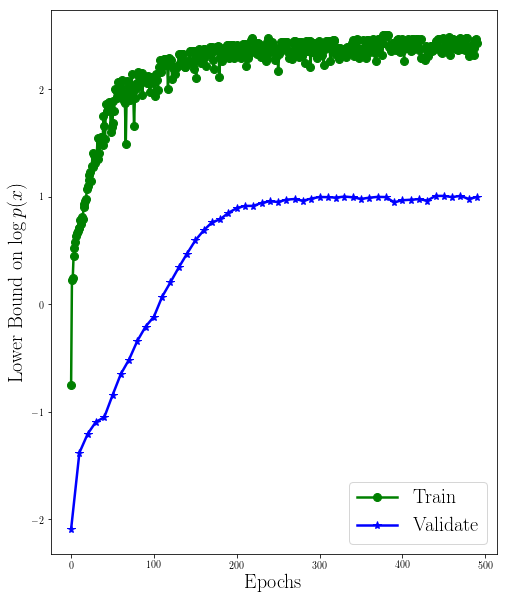

In [15]:
# evaluation
plt.figure(figsize=(8,10))
plt.plot(stats['train_bound'][:,0],-stats['train_bound'][:,1],'-o',color='g',label='Train')
plt.plot(stats['valid_bound'][:,0],-stats['valid_bound'][:,1],'-*',color='b',label='Validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Lower Bound on $\log p(x)$')

In [11]:
## reload from previous run
# reloadFile= pfile.replace('-config.pkl','')+'-EP440-params.npz'
# print 'Loading from : ',reloadFile
# params['validate_only']          = True
# dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-params.npz) / opt (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 34125>>


models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")


	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 35.5306 seconds>>


In [16]:
#Reload the best DMM based on the validation error

epochMin, valMin, idxMin = getLowestError(savedata['valid_bound'])
reloadFile= pfile.replace('-config.pkl','')+'-EP'+str(int(epochMin))+'-params.npz'

print 'Loading from : ',reloadFile
params['validate_only']          = True
dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-params.npz) / opt (./chkpt-ipython-sliding-new//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-500-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP440-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 34125>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>

models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")



	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 24.6093 seconds>>


In [17]:
test_bound = DMM_evaluate.evaluateBound(dmm_best, dataset['test'], batch_size = params['batch_size'])
print("Test bound", test_bound)
print("Validation bound", stats['valid_bound'][-1,1])
print("Train bound", stats['train_bound'][-1,1])

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [1989   10    1],[1989   10]>>
	<<(Evaluate) Validation Bound: -1.0188 [Took 0.3047 seconds]>>
('Test bound', -1.0188025089006736)
('Validation bound', -0.9984490441328676)
('Train bound', -2.4354600627116447)


## Prediction and Test Performance

In [12]:
train_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['train'])

In [13]:
valid_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['valid'])

In [14]:
test_pred, _ = DMM_evaluate.reconstruct(dmm_best, dataset['test'])

In [18]:
def evaluate_rmse(prediction, dataset, idx):
    error_sum = 0
    for i in range(len(prediction)):
        error_sum += (dataset[idx[i]+10][0]-prediction[i][-1][0])**2
    error_sum /= (i+1)
    return np.sqrt(error_sum)

In [23]:
print("RMSE before Reversing MinMaxScaler")
print("Training RMSE:", evaluate_rmse(train_pred, train_all, train_idx))
print("Validation RMSE:", evaluate_rmse(valid_pred, train_all, valid_idx))
print("Test RMSE:", evaluate_rmse(test_pred, test_all, test_idx))

RMSE before Reversing MinMaxScaler
('Training RMSE:', 0.022014472789846102)
('Validation RMSE:', 0.03603397150488418)
('Test RMSE:', 0.03718456769300494)


In [20]:
def evaluate_rmse_inv(prediction, dataset, idx):
    error_sum = 0
    for i in range(len(prediction)):
        error_sum += (scaler.inverse_transform(dataset[idx[i]+10][0])-\
                      scaler.inverse_transform(prediction[i][-1][0]))**2
    error_sum /= (i+1)
    return np.sqrt(error_sum)

In [24]:
print("RMSE Original Scale")
print("Training RMSE:", evaluate_rmse_inv(train_pred, train_all, train_idx))
print("Validation RMSE:", evaluate_rmse_inv(valid_pred, train_all, valid_idx))
print("Test RMSE:", evaluate_rmse_inv(test_pred, test_all, test_idx))

RMSE Original Scale
('Training RMSE:', array([[399.20582653]]))
('Validation RMSE:', array([[653.43247214]]))
('Test RMSE:', array([[674.29714179]]))
